In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy import ndimage
from astropy.modeling import models, fitting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import SZ_functions as SZ


import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
import scipy.integrate as integrate
from astropy.constants import pc, e,c,h,m_e, M_sun, sigma_T
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15

from matplotlib import figure
from matplotlib import ticker
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LinearSegmentedColormap, colorConverter
from matplotlib.ticker import MultipleLocator

#plt.rcParams['text.usetex'] = True

%matplotlib inline

In [2]:

from astropy.constants import pc, e,c,h,m_e,m_p, M_sun, sigma_T
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15

pc = pc.si.value
e = e.si.value
c = c.si.value
h = h.si.value
m_e = m_e.si.value
m_p = m_p.si.value
M_sun = M_sun.si.value
sigma_T = sigma_T.si.value
T_CMB = 2.7255


omg_m = 0.3
omg_l = 0.7
beta = 0.86
f_gas = 0.125

f_h = 0.76

cosmo = FlatLambdaCDM(H0= 70, Om0 = 0.3)
H0 = cosmo.H0.value


In [3]:

mu = 0.7
t_cmb = 2.72
h = 6.62 * 1e-27  # in  cm^2 g s^-1       6.62607015*1e-34 in Joule seconds
k = 1.38 * 1e-16  # in erg K^−1           1.380649*1e-23 in joules/kelvin.


noises_cmbs4 = np.array([1.5, 1.5, 4.8, 11.5])
fwhm_cmbs4 = np.array([2.2, 1.4, 1.0, 0.9])
nu_cmbs4 = np.array([93, 145, 225, 280])

ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.txt", usecols=(0, 1), unpack=True) 


In [4]:

sz_sample, head = SZ.readfits("nclusters_SO_base_CCATp_combined_sky_noise_4.5.fits")

nclusters = np.sum(sz_sample)

sample = SZ.draw_clusters(int(nclusters), sz_sample)

z = sample[0,:]
M_500 = sample[1,:]

print(z.shape)
print(M_500.shape)


(13068,)
(13068,)


Mean Cluster Mass : 586703936031395.5 Solar Mass
Mean Cluster Redshift : 0.43580405394450294
Mass upper limit : 1690257667533554.0
Mass lower limit : 453465719620189.7
Redshift range : 0.826200257634396 - 0.360322678946369


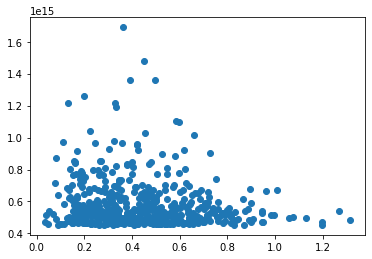

In [289]:

sort_M_500 = np.sort(M_500)

indices_sorted_M_500 = np.argsort(M_500)

selected_indices = indices_sorted_M_500[-500:]

massive_M_500 = sort_M_500[-500:]

red_shifts = z[selected_indices]

m_500 = massive_M_500#/0.70         ####### h^-1 solar mass to solar mass

print("Mean Cluster Mass :", np.mean(m_500), r"Solar Mass")
print("Mean Cluster Redshift :", np.mean(red_shifts))
print("Mass upper limit :", np.max(massive_M_500))
print("Mass lower limit :", np.min(massive_M_500))
print("Redshift range :",red_shifts[0],'-',red_shifts[499] )
plt.plot(red_shifts, m_500, 'o')

In [6]:
#################### Selecting 1000 clusters ##################

selected_indices_1k = indices_sorted_M_500[-1000:]

massive_M_500_1k = sort_M_500[-1000:]

red_shifts_1k = z[selected_indices_1k]

m_500_1k = massive_M_500_1k#/0.70 


In [7]:

r_500 = SZ.calculate_m500_to_r500(red_shifts, m_500)

r_500_mpc =  r_500 * 3.24078e-23


r_500_arcmins = r_500/ (cosmo.angular_diameter_distance(red_shifts).si.value) * 180 / np.pi *60 #SZ.r500_in_arcmins(r_500, red_shifts)  #convert from m to radians to arcmin


E = SZ.calculate_E(red_shifts, 0.3, 0.7)

T_e = SZ.calculate_T_e(m_500,E)


omega = SZ.calculate_omega(red_shifts, omg_m, omg_l)

delta = SZ.calculate_del(omega) 

m_vir = SZ.calculate_m_vir(delta,m_500)

conc_parameter = SZ.calculate_conc_parameter(red_shifts, m_vir)

r_c = (2*r_500)/conc_parameter


r_c_arcmins = SZ.r_c_in_arcmins(r_c, red_shifts)

c_500 = r_500/r_c # r_500 and r_c in meters


f_1 = SZ.calculate_f_1(c_500)


f_2 = SZ.calculate_f_2(c_500)


In [8]:
################## for 1000 clusters #################

r_500_1k = SZ.calculate_m500_to_r500(red_shifts_1k, m_500_1k)

r_500_mpc_1k =  r_500_1k * 3.24078e-23


r_500_arcmins_1k = r_500_1k/ (cosmo.angular_diameter_distance(red_shifts_1k).si.value) * 180 / np.pi *60        #SZ.r500_in_arcmins(r_500, red_shifts)  #convert from m to radians to arcmin


E_1k = SZ.calculate_E(red_shifts_1k, 0.3, 0.7)

T_e_1k = SZ.calculate_T_e(m_500_1k,E_1k)


omega_1k = SZ.calculate_omega(red_shifts_1k, omg_m, omg_l)

delta_1k = SZ.calculate_del(omega_1k) 

m_vir_1k = SZ.calculate_m_vir(delta_1k, m_500_1k)

conc_parameter_1k = SZ.calculate_conc_parameter(red_shifts_1k, m_vir_1k)

r_c_1k = (2*r_500_1k)/conc_parameter_1k


r_c_arcmins_1k = SZ.r_c_in_arcmins(r_c_1k, red_shifts_1k)

c_500_1k = r_500_1k/r_c_1k # r_500 and r_c in meters


f_1_1k = SZ.calculate_f_1(c_500_1k)


f_2_1k = SZ.calculate_f_2(c_500_1k)


In [9]:
#print(r_500_mpc)

(500,)
0.0019523990097838316
0.00021892009675827264


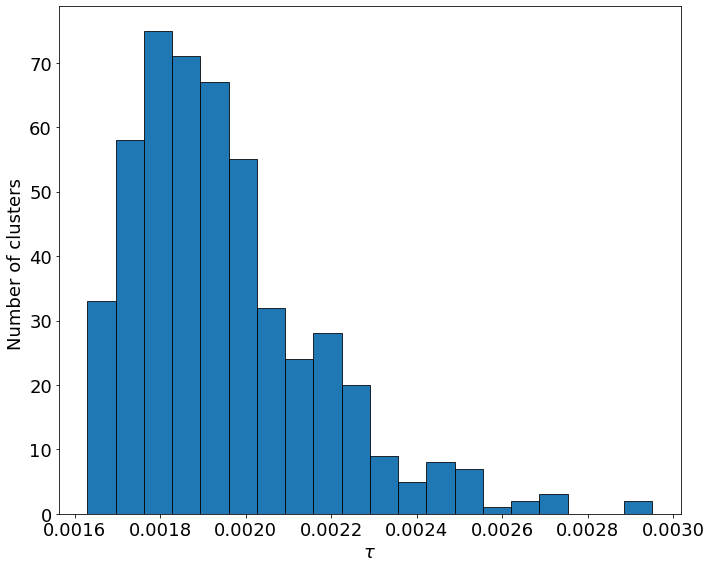

In [290]:

tau = SZ.calculate_tau(m_500, f_1, f_2, f_h, r_c)


print(tau.shape)

fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.hist(tau, bins = 20, histtype='barstacked',edgecolor='black', linewidth=0.8)
#plt.xlim(0,0.01)
#plt.xticks([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,0.008])
plt.xlabel(r"$\tau$", fontsize=18)
plt.ylabel("Number of clusters ", fontsize=18)


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()



print(np.mean(tau))
print(np.std(tau))


In [11]:
#tau_1k = SZ.calculate_tau(m_500_1k, f_1_1k, f_2_1k, f_h, r_c_1k)

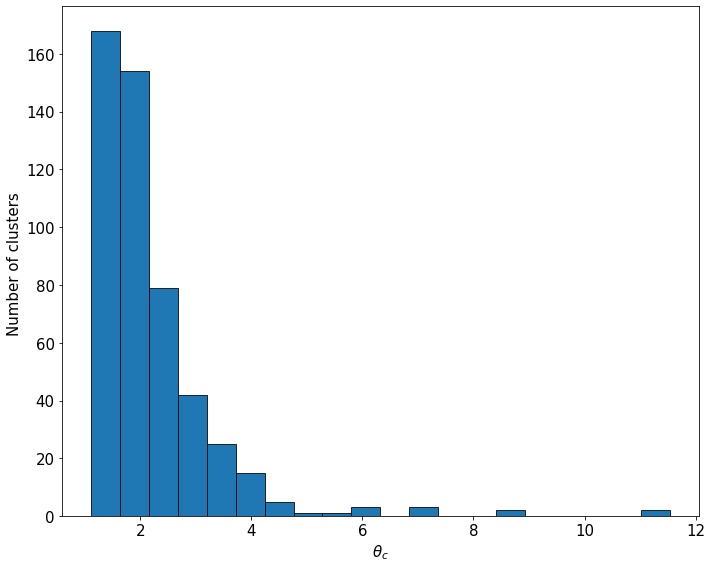

In [12]:

fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.hist(r_c_arcmins, bins = 20, histtype='barstacked',edgecolor='black', linewidth=0.8)
#plt.xlim(0,0.01)
#plt.xticks([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,0.008])
plt.xlabel(r"$\theta_c$", fontsize=15)
plt.ylabel("Number of clusters ", fontsize=15)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()


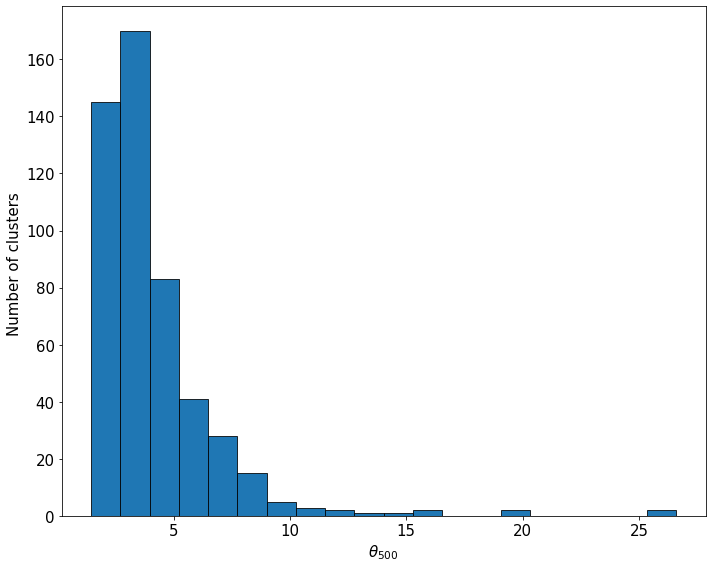

In [13]:

fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.hist(r_500_arcmins, bins = 20, histtype='barstacked',edgecolor='black', linewidth=0.8)
#plt.xlim(0,0.01)
#plt.xticks([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,0.008])
plt.xlabel(r"$\theta_{500}$", fontsize=15)
plt.ylabel("Number of clusters ", fontsize=15)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()



In [14]:

def calculate_cluster_pixel_size(z, r_500, map_size, n_pixels):
    
    pix_size_array = [] 
    
    for i in range(len(z)):
        
        r_500_in_arcmins =  r_500[i]/ (cosmo.angular_diameter_distance(z[i]).si.value) * 180 / np.pi *60  #convert from m to radians to arcmin
        pix_size = r_500_in_arcmins * (map_size/n_pixels) # map size in terms of R_500 e.g., 5R_500 X 5R_00
        pix_size_array.append(pix_size)
        
    return np.array(pix_size_array)

cluster_pix_size = calculate_cluster_pixel_size(red_shifts, r_500, 10, 200)

cluster_pix_size_1k = calculate_cluster_pixel_size(red_shifts_1k, r_500_1k, 10, 200)

pix_size_noise = np.ones(500)*0.25

print(cluster_pix_size_1k.shape)


(1000,)


In [15]:

npix = 200


pix_size = cluster_pix_size

r_core = r_c_arcmins


y_map = SZ.simulate_y_map(npix ,beta, tau, pix_size, T_e, red_shifts, r_core)

tau_map = SZ.simulate_tau_map(npix ,beta, tau, pix_size, T_e, red_shifts, r_core )



In [16]:

# npix = 200


# pix_size_1k = cluster_pix_size_1k

# r_core_1k = r_c_arcmins_1k


# y_map_1k = SZ.simulate_y_map(npix ,beta, tau_1k, pix_size_1k, T_e_1k, red_shifts_1k, r_core_1k)

# tau_map_1k = SZ.simulate_tau_map(npix ,beta, tau_1k, pix_size_1k, T_e_1k, red_shifts_1k, r_core_1k )


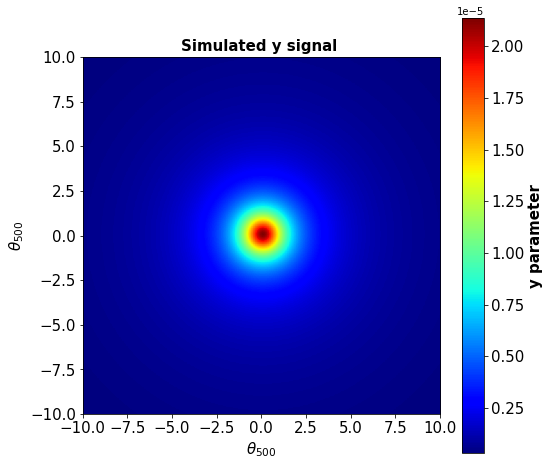

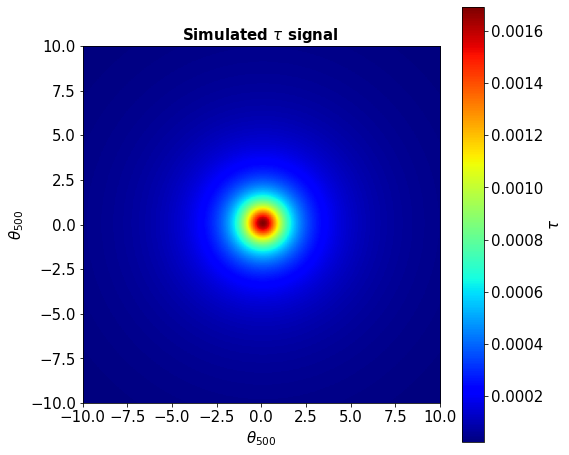

In [17]:

SZ.plot_map_500(8,8,'Simulated y signal ',y_map[5],'y parameter', 200, 0)  
plt.show()

SZ.plot_map_500(8,8,r'Simulated $\tau$ signal ',tau_map[5],r'$\tau$', 200, 0)
plt.show()


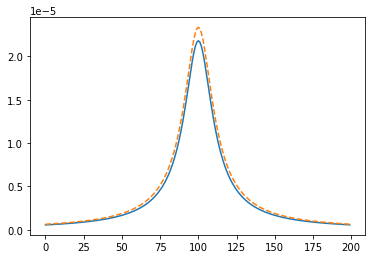

In [18]:
plt.plot(y_map[2][200//2,:])
plt.plot(y_map[20][200//2,:],'--')
plt.show()

In [19]:
print(np.max(pix_size))
print(np.where(pix_size==np.max(pix_size)))

1.3303672587186848
(array([87]),)


In [20]:
%%time

def calculate_scaled_maps(org_num_pixel, pix_size_arcmins, new_pix_size, cluster, z):

    store = []
    
    for i in range(len(z)):
    
        lim = int(org_num_pixel*pix_size_arcmins[i])
        
        x_lim = np.arange(0,lim,pix_size_arcmins[i])
        y_lim = np.arange(0,lim,pix_size_arcmins[i])
        
        interpolated_function = interpolate.RectBivariateSpline(x_lim, y_lim, cluster[i], kx=1, ky=1)
        
        x_interp_lim = np.arange(0, lim, new_pix_size)
        y_interp_lim = np.arange(0, lim, new_pix_size)
        
        scaled_map = interpolated_function(x_interp_lim, y_interp_lim)
        
        no_pixels_interp_map = lim/new_pix_size
        
        crop_lim = no_pixels_interp_map - org_num_pixel
        
        crop_lim = int(crop_lim//2)
        
        cropped_map = scaled_map[crop_lim : crop_lim+org_num_pixel, crop_lim : crop_lim+org_num_pixel]
        
        store.append(cropped_map)
        
    return np.array(store)



y_map_scaled = calculate_scaled_maps(200, r_500_arcmins, 0.5, y_map, red_shifts)

tau_map_scaled = calculate_scaled_maps(200, r_500_arcmins, 0.5, tau_map, red_shifts)



print(y_map_scaled.shape)

(500, 200, 200)
CPU times: user 28.7 s, sys: 3.83 s, total: 32.6 s
Wall time: 32.6 s


In [21]:
#ksz_spec_cmbs4  =  SZ.calculate_ksz_SED(nu_cmbs4, h, k, t_cmb)
tsz_spec_cmbs4  =  SZ.calculate_tsz_SED(nu_cmbs4, h, k, t_cmb)
rksz_spec_cmbs4 =  SZ.calculate_rksz_SED(nu_cmbs4, h, k, mu, t_cmb)
tksz_spec_cmbs4 =  SZ.calculate_tksz_SED(nu_cmbs4, h, k, t_cmb)
rtsz_spec_cmbs4 =  SZ.calculate_rtsz_SED(nu_cmbs4, h, k, t_cmb)

sd_vel = 300

v = SZ.create_gaussian_vel(500, sd_vel)/(3*1e5)


In [22]:
v_1k = SZ.create_gaussian_vel(1000, sd_vel)/(3*1e5)

print(np.mean(v))
print(np.mean(T_e))

-8.633334242681561e-05
8.654872870295446


In [23]:

cmb_temp_map = SZ.make_CMB_T_map(200,0.5,ell,DlTT)

noise_maps = SZ.all_channel_noise_maps(200, red_shifts, pix_size, noises_cmbs4)

print(noise_maps.shape)



(500, 4, 200, 200)


In [24]:


# noise_maps_1k = SZ.all_channel_noise_maps(200, red_shifts_1k, pix_size_1k, noises_cmbs4)

# print(noise_maps_1k.shape)


In [25]:
def pixelate(im, nR, nC):
    
  nR0 = len(im)     # source number of rows 
  nC0 = len(im[0])  # source number of columns 
    
  return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)]


def interpolate_cmb(org_num_pixel, pix_size_arcmins, new_pix_size,z, ell, DlTT):

    store = []
    
    for i in range(len(z)):
    
        lim = int(org_num_pixel*pix_size_arcmins)
        
        x_lim = np.arange(0,lim,pix_size_arcmins)
        y_lim = np.arange(0,lim,pix_size_arcmins)
        
        cmb_temp_map = SZ.make_CMB_T_map(org_num_pixel,pix_size_arcmins,ell,DlTT)
        
        interpolated_function = interpolate.RectBivariateSpline(x_lim, y_lim, cmb_temp_map, kx=2, ky=2)
        
        x_interp_lim = np.arange(0, lim, new_pix_size[i])
        y_interp_lim = np.arange(0, lim, new_pix_size[i])
        
        scaled_map = interpolated_function(x_interp_lim, y_interp_lim)
        
        repixelated_scaled_map = pixelate(scaled_map, org_num_pixel, org_num_pixel)
        
        #no_pixels_interp_map = lim/new_pix_size
        
        #crop_lim = no_pixels_interp_map - org_num_pixel
        
        #crop_lim = int(crop_lim//2)
        
        #cropped_map = scaled_map[crop_lim : crop_lim+org_num_pixel, crop_lim : crop_lim+org_num_pixel]
        
        store.append(repixelated_scaled_map)
        
    return np.array(store)
    
    
cmb_maps_interpolated = interpolate_cmb(200, 0.5, pix_size, red_shifts, ell, DlTT)

print(cmb_maps_interpolated.shape)


(500, 200, 200)


In [26]:
%%time

ksz_maps = SZ.calculate_ksz_maps(tau_map, red_shifts, v, mu, t_cmb)

print(np.array(ksz_maps).shape)




def calculate_cmb_ksz_map(tau_map, z, v, N, pix_size, ell, DlTT, mu, t_cmb ):
    
    cmb_ksz_maps = []
    
    for i in range (len(z)):

        ksz_maps = SZ.calculate_ksz_maps(tau_map, z, v, mu, t_cmb)[i]
        cmb_map =  SZ.make_CMB_T_map(N, pix_size[i],ell,DlTT)                                 # different realisations
        cmb_ksz_map = ksz_maps + cmb_map
        cmb_ksz_maps.append(cmb_ksz_map)
    
    return cmb_ksz_maps



cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, red_shifts, v, 200 , pix_size, ell, DlTT, mu, t_cmb )

print(np.array(cmb_ksz_maps).shape)

print(np.var(cmb_ksz_maps))


(500, 200, 200)
(500, 200, 200)
3862.016018140741
CPU times: user 31.3 s, sys: 7.23 s, total: 38.5 s
Wall time: 38.5 s


In [27]:
# %%time

# ksz_maps_1k = SZ.calculate_ksz_maps(tau_map_1k, red_shifts_1k, v_1k, mu, t_cmb)

# print(np.array(ksz_maps_1k).shape)




# cmb_ksz_maps_1k = calculate_cmb_ksz_map(tau_map_1k, red_shifts_1k, v_1k, 200 , pix_size_1k, ell, DlTT, mu, t_cmb )

# print(np.array(cmb_ksz_maps_1k).shape)

# print(np.var(cmb_ksz_maps_1k))


In [28]:

def cmb_ksz_map_filtered(cmb_ksz_maps, z, order, N ):
    
    filtered_maps = []
    
    for i in range(len(z)):
        
        cmb_ksz_maps_filtering = SZ.poly_filtering(cmb_ksz_maps[i], order, N)
        filtered_maps.append(cmb_ksz_maps_filtering)
        
    return np.array(filtered_maps)



cmb_ksz_maps_filtered = cmb_ksz_map_filtered(cmb_ksz_maps, red_shifts, 2, 200 )

print(cmb_ksz_maps_filtered.shape)



(500, 200, 200)


In [29]:

# cmb_ksz_maps_filtered_1k = cmb_ksz_map_filtered(cmb_ksz_maps_1k, red_shifts_1k, 2, 200 )

# print(cmb_ksz_maps_filtered_1k.shape)


In [30]:

tsz_clusters = SZ.calculate_tsz_map(nu_cmbs4, red_shifts, tsz_spec_cmbs4, y_map, t_cmb)

print(tsz_clusters.shape)




(500, 4, 200, 200)


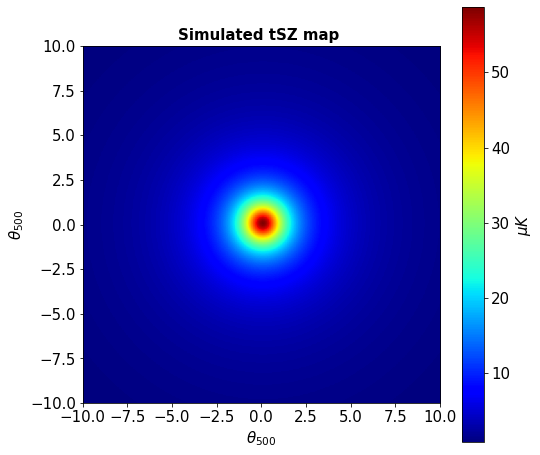

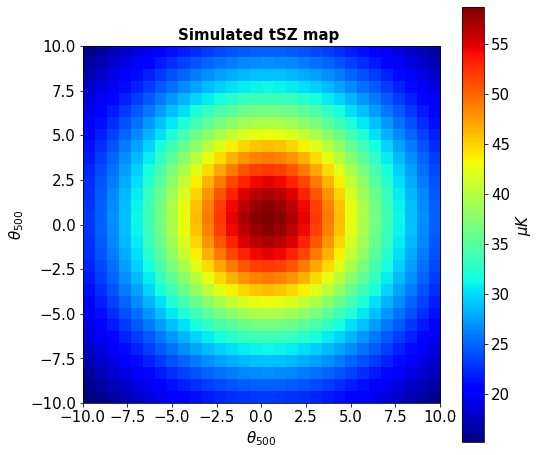

In [31]:
SZ.plot_map_500(8,8,'Simulated tSZ map ',tsz_clusters[5][3],'$\mu K$', 200, 0)
plt.show()

SZ.plot_map_500(8,8,'Simulated tSZ map ',tsz_clusters[5][3][85:115,85:115],'$\mu K$', 200, 0)
plt.show()

In [32]:

rksz_clusters = SZ.calculate_rksz_map(nu_cmbs4, red_shifts, rksz_spec_cmbs4, tau_map, v, t_cmb)

print(rksz_clusters.shape)

# SZ.plot_map(8,8,'Simulated rkSZ map ',rksz_clusters[1][3],'$\mu K$', 200, 0.5)
# plt.show()



(500, 4, 200, 200)


In [33]:

tksz_clusters = SZ.calculate_tksz_map(nu_cmbs4, red_shifts, tksz_spec_cmbs4, y_map, np.absolute(v), mu, t_cmb)

print(tksz_clusters.shape)

# SZ.plot_map(8,8,'Simulated tkSZ map ',tksz_clusters[55][2],'$\mu K$', 200, 0.25)
# plt.show()



(500, 4, 200, 200)


In [34]:

rtsz_clusters = SZ.calculate_rtsz_map(nu_cmbs4, red_shifts, rtsz_spec_cmbs4, y_map, mu, T_e, t_cmb)

print(rtsz_clusters.shape)

# SZ.plot_map(8,8,'Simulated rtSZ map ',rtsz_clusters[300][3],'$\mu K$', 200, 0.25)
# plt.show()



(500, 4, 200, 200)


In [35]:

signal_1 = cmb_ksz_maps
signal_1_filtered = cmb_ksz_maps_filtered

signal_2 = tsz_clusters
signal_3 = rksz_clusters
signal_4 = tksz_clusters
signal_5 = rtsz_clusters

noise_maps = noise_maps


all_signal_maps = SZ.calculate_all_signal_maps(signal_1, signal_2, signal_3, signal_4, signal_5, red_shifts, noise_maps, nu_cmbs4)
all_signal_maps_filtered = SZ.calculate_all_signal_maps(signal_1_filtered, signal_2, signal_3, signal_4, signal_5, red_shifts, noise_maps, nu_cmbs4)


all_signal_maps_no_rtsz = SZ.calculate_all_signal_maps(signal_1, signal_2, signal_3, signal_4, np.zeros((500,200,200)), red_shifts, noise_maps, nu_cmbs4)
all_signal_maps_no_rtsz_filtered = SZ.calculate_all_signal_maps(signal_1_filtered, signal_2, signal_3, signal_4, np.zeros((500,200,200)), red_shifts, noise_maps, nu_cmbs4)

print(all_signal_maps.shape)


(500, 4, 200, 200)


In [36]:
# ################### 1000 clusters ################################


# signal_1_1k = cmb_ksz_maps_1k
# signal_1_filtered_1k = cmb_ksz_maps_filtered_1k

# signal_2_1k = tsz_clusters_1k
# signal_3_1k = rksz_clusters_1k
# signal_4_1k = tksz_clusters_1k
# signal_5_1k = rtsz_clusters_1k

# noise_maps_1k = noise_maps_1k


# all_signal_maps_1k = SZ.calculate_all_signal_maps(signal_1_1k, signal_2_1k, signal_3_1k, signal_4_1k, signal_5_1k, red_shifts_1k, noise_maps_1k, nu_cmbs4)
# all_signal_maps_filtered_1k = SZ.calculate_all_signal_maps(signal_1_filtered_1k, signal_2_1k, signal_3_1k, signal_4_1k, signal_5_1k, red_shifts_1k, noise_maps_1k, nu_cmbs4)


# all_signal_maps_no_rtsz_1k = SZ.calculate_all_signal_maps(signal_1_1k, signal_2_1k, signal_3_1k, signal_4_1k, np.zeros((1000,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)
# all_signal_maps_no_rtsz_filtered_1k = SZ.calculate_all_signal_maps(signal_1_filtered_1k, signal_2_1k, signal_3_1k, signal_4_1k, np.zeros((1000,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)

# print(all_signal_maps_1k.shape)


In [37]:

all_signal_maps_only_tsz = SZ.calculate_all_signal_maps(signal_1, signal_2, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)

all_signal_maps_only_tsz_filtered = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered, signal_2, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)



all_signal_maps_only_rksz = SZ.calculate_all_signal_maps(signal_1, np.zeros((500,4,200,200)), signal_3, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)

all_signal_maps_only_rksz_filtered = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered, np.zeros((500,4,200,200)), signal_3, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)



all_signal_maps_only_tksz = SZ.calculate_all_signal_maps(signal_1, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), signal_4, np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)

all_signal_maps_only_tksz_filtered = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), signal_4, np.zeros((500,4,200,200)), red_shifts, noise_maps, nu_cmbs4)



all_signal_maps_only_rtsz = SZ.calculate_all_signal_maps(signal_1, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), signal_5, red_shifts, noise_maps, nu_cmbs4)

all_signal_maps_only_rtsz_filtered = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), signal_5, red_shifts, noise_maps, nu_cmbs4)


In [38]:




# all_signal_maps_only_rksz_1k = SZ.calculate_all_signal_maps(signal_1_1k, np.zeros((1000,4,200,200)), signal_3_1k, np.zeros((1000,4,200,200)), np.zeros((1000,4,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)

# all_signal_maps_only_rksz_filtered_1k = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered_1k, np.zeros((1000,4,200,200)), signal_3_1k, np.zeros((1000,4,200,200)), np.zeros((1000,4,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)



# all_signal_maps_only_tksz_1k = SZ.calculate_all_signal_maps(signal_1_1k, np.zeros((1000,4,200,200)), np.zeros((1000,4,200,200)), signal_4_1k, np.zeros((1000,4,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)

# all_signal_maps_only_tksz_filtered_1k = SZ.calculate_all_signal_maps(cmb_ksz_maps_filtered_1k, np.zeros((1000,4,200,200)), np.zeros((1000,4,200,200)), signal_4_1k, np.zeros((1000,4,200,200)), red_shifts_1k, noise_maps_1k, nu_cmbs4)





## Input signals

In [39]:

input_tksz = SZ.calculate_input_tksz_signal(red_shifts,np.absolute(v),mu, y_map)

print(input_tksz.shape)


input_rksz = SZ.calculate_input_rksz_signal(red_shifts,v,tau_map)

print(input_tksz.shape)


input_rtsz = SZ.calculate_input_rtsz_signal(red_shifts,y_map, T_e)


(500, 200, 200)
(500, 200, 200)


In [40]:

# input_tksz_1k = SZ.calculate_input_tksz_signal(red_shifts_1k,np.absolute(v_1k),mu, y_map_1k)

# print(input_tksz_1k.shape)


# input_rksz_1k = SZ.calculate_input_rksz_signal(red_shifts_1k,v_1k,tau_map_1k)

# print(input_tksz_1k.shape)


# input_rtsz_1k = SZ.calculate_input_rtsz_signal(red_shifts_1k,y_map_1k, T_e_1k)



# Maps smoothing

In [41]:
%%time 

########################### Smoothing individual signal cluster maps ###################################


tsz_clusters_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, tsz_clusters)

rksz_clusters_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, rksz_clusters)

tksz_clusters_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, tksz_clusters)

rtsz_clusters_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, rtsz_clusters)


########################### Smoothing all signals cluster maps ###################################



all_signals_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps)

all_signals_maps_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_filtered)





all_signals_maps_no_rtsz_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_no_rtsz)

all_signals_maps_no_rtsz_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_no_rtsz_filtered)



############################ Smoothing noise and CMB maps ####################################


noise_maps_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, noise_maps)

cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, cmb_ksz_maps)

cmb_ksz_maps_filtered_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, cmb_ksz_maps_filtered)



############################ Smoothing input signal maps ######################################


y_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, y_map)


tau_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, tau_map)

ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, ksz_maps)


input_rksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, input_rksz)

input_tksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, input_tksz)

input_rtsz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(red_shifts, pix_size, fwhm_cmbs4, input_rtsz)



CPU times: user 2min 14s, sys: 3.01 s, total: 2min 17s
Wall time: 2min 17s


In [42]:
# %%time 

# ############################ 1000 clusters ########################################


# tsz_clusters_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, tsz_clusters_1k)

# rksz_clusters_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, rksz_clusters_1k)

# tksz_clusters_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, tksz_clusters_1k)

# rtsz_clusters_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, rtsz_clusters_1k)

# all_signals_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_1k)


# all_signals_maps_filtered_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_filtered_1k)



# noise_maps_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, noise_maps_1k)


# y_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, y_map_1k)

# print(y_maps_smoothed_1k.shape)

# tau_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, tau_map_1k)

# ksz_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, ksz_maps_1k)

# cmb_ksz_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, cmb_ksz_maps_1k)

# cmb_ksz_maps_filtered_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, cmb_ksz_maps_filtered_1k)

# input_rksz_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, input_rksz_1k)

# input_tksz_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, input_tksz_1k)

# input_rtsz_maps_smoothed_1k = SZ.calculate_smoothed_maps_freq_independent(red_shifts_1k, pix_size_1k, fwhm_cmbs4, input_rtsz_1k)



In [43]:
%%time 

all_signals_maps_only_tsz_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_tsz)

all_signals_maps_only_tsz_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_tsz_filtered)


all_signals_maps_only_rksz_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_rksz)

all_signals_maps_only_rksz_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_rksz_filtered)



all_signals_maps_only_tksz_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_tksz)

all_signals_maps_only_tksz_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_tksz_filtered)



all_signals_maps_only_rtsz_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_rtsz)

all_signals_maps_only_rtsz_filtered_smoothed = SZ.calculate_smoothed_maps(red_shifts, pix_size, fwhm_cmbs4, all_signal_maps_only_rtsz_filtered)


CPU times: user 1min 41s, sys: 2.4 s, total: 1min 43s
Wall time: 1min 43s


In [44]:
# %%time 


# all_signals_maps_only_rksz_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_only_rksz_1k)

# all_signals_maps_only_rksz_filtered_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_only_rksz_filtered_1k)



# all_signals_maps_only_tksz_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_only_tksz_1k)

# all_signals_maps_only_tksz_filtered_smoothed_1k = SZ.calculate_smoothed_maps(red_shifts_1k, pix_size_1k, fwhm_cmbs4, all_signal_maps_only_tksz_filtered_1k)



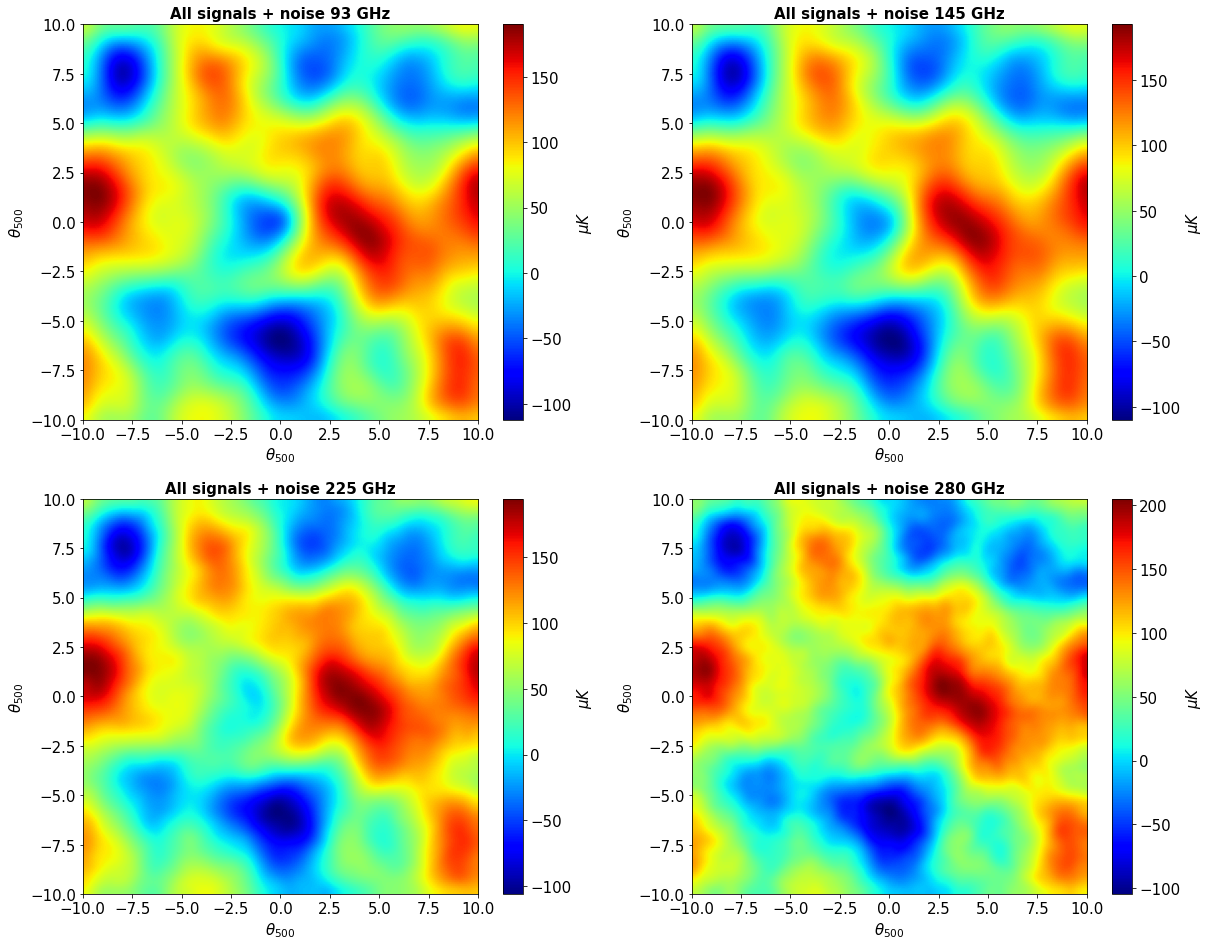

In [45]:
for i in range(len(nu_cmbs4)):
    
    plt.subplot(2, 2, i + 1)
    SZ.plot_map_500(20,16,f"All signals + noise {str(nu_cmbs4[i])} GHz",
             all_signals_maps_smoothed[300][i],"$\mu K$", 200, 0.50)
    
  
plt.show()



# Maps stacking 

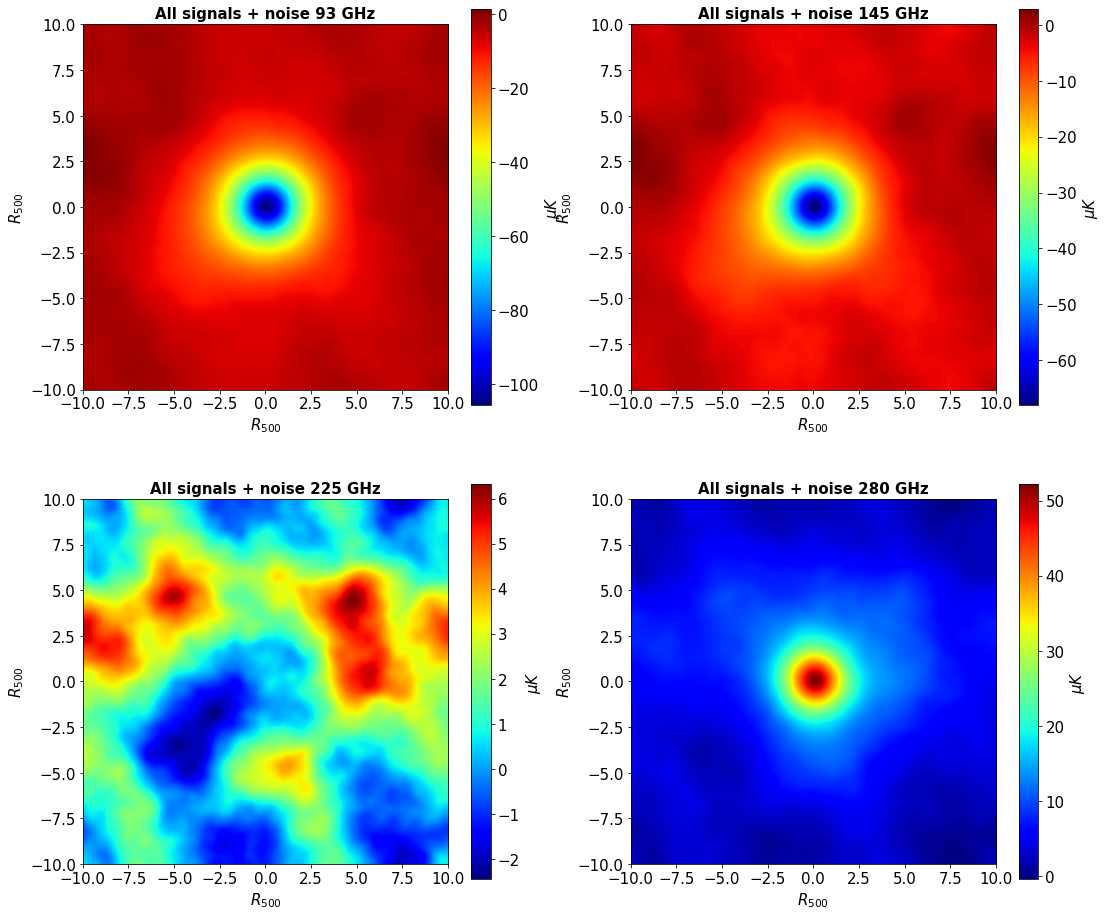

In [46]:


tsz_clusters_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, tsz_clusters_maps_smoothed)

rksz_clusters_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, rksz_clusters_maps_smoothed)

tksz_clusters_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, tksz_clusters_maps_smoothed)

rtsz_clusters_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, rtsz_clusters_maps_smoothed)

all_signal_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_smoothed)

all_signal_maps_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_filtered_smoothed)


all_signal_maps_no_rtsz_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_no_rtsz_smoothed)

all_signal_maps_no_rtsz_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_no_rtsz_filtered_smoothed)

noise_maps_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, noise_maps_smoothed)



y_maps_smoothed_stacked = np.sum(y_maps_smoothed, axis = 0)/len(red_shifts)

tau_maps_smoothed_stacked = np.sum(tau_maps_smoothed, axis = 0)/len(red_shifts)

ksz_maps_smoothed_stacked =  np.sum(ksz_maps_smoothed, axis = 0)/ len(red_shifts)

cmb_ksz_maps_smoothed_stacked =  np.sum(cmb_ksz_maps_smoothed, axis = 0)/len(red_shifts)

cmb_ksz_maps_filtered_smoothed_stacked =  np.sum(cmb_ksz_maps_filtered_smoothed, axis = 0)/len(red_shifts)

input_rksz_maps_smoothed_stacked = np.sum(input_rksz_maps_smoothed, axis = 0)/len(red_shifts)

input_tksz_maps_smoothed_stacked = np.sum(input_tksz_maps_smoothed, axis = 0)/len(red_shifts)

input_rtsz_maps_smoothed_stacked = np.sum(input_rtsz_maps_smoothed, axis = 0)/len(red_shifts)




all_signal_maps_only_tsz_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_tsz_smoothed)

all_signal_maps_only_tsz_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_tsz_filtered_smoothed)


all_signal_maps_only_rksz_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_rksz_smoothed)

all_signal_maps_only_rksz_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_rksz_filtered_smoothed)



all_signal_maps_only_tksz_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_tksz_smoothed)

all_signal_maps_only_tksz_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_tksz_filtered_smoothed)


all_signal_maps_only_rtsz_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_rtsz_smoothed)

all_signal_maps_only_rtsz_filtered_smoothed_stacked = SZ.all_maps_stacking(red_shifts, nu_cmbs4, all_signals_maps_only_rtsz_filtered_smoothed)








def plot_map(x,y,map_title,map_plot,cbar_label, N):
    
    plt.gcf().set_size_inches(x,y)

    plt.title(map_title, fontsize=15, fontweight='bold')
    image = plt.imshow(map_plot, cmap = 'jet', origin = 'lower')
    cb = plt.colorbar(image)
    cb.set_label(label = cbar_label, fontsize=15, fontweight='bold')
    cb.ax.tick_params(labelsize=15)
    
    X_width = N   # horizontal map width in degrees
    Y_width = N   # vertical map width in degrees
    

    image.set_extent([-X_width/20,X_width/20,-Y_width/20,Y_width/20])
    plt.ylabel(r'$R_{500}$', fontsize=15)
    plt.xlabel(r'$R_{500}$', fontsize=15) 
    ax = plt.gca()


    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)




for i in range(len(nu_cmbs4)):
    
    plt.subplot(2, 2, i + 1)
    plot_map(18,16,f"All signals + noise {str(nu_cmbs4[i])} GHz",
             all_signal_maps_smoothed_stacked[i],"$\mu K$", 200)

    

In [47]:

# y_maps_smoothed_stacked_1k = np.sum(y_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)

# tau_maps_smoothed_stacked_1k = np.sum(tau_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)

# ksz_maps_smoothed_stacked_1k =  np.sum(ksz_maps_smoothed_1k, axis = 0)/ len(red_shifts_1k)

# cmb_ksz_maps_smoothed_stacked_1k =  np.sum(cmb_ksz_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)

# cmb_ksz_maps_filtered_smoothed_stacked_1k =  np.sum(cmb_ksz_maps_filtered_smoothed_1k, axis = 0)/len(red_shifts_1k)

# input_rksz_maps_smoothed_stacked_1k = np.sum(input_rksz_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)

# input_tksz_maps_smoothed_stacked_1k = np.sum(input_tksz_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)

# input_rtsz_maps_smoothed_stacked_1k = np.sum(input_rtsz_maps_smoothed_1k, axis = 0)/len(red_shifts_1k)





# all_signal_maps_only_rksz_smoothed_stacked_1k = SZ.all_maps_stacking(red_shifts_1k, nu_cmbs4, all_signals_maps_only_rksz_smoothed_1k)

# all_signal_maps_only_rksz_filtered_smoothed_stacked_1k = SZ.all_maps_stacking(red_shifts_1k, nu_cmbs4, all_signals_maps_only_rksz_filtered_smoothed_1k)



# all_signal_maps_only_tksz_smoothed_stacked_1k = SZ.all_maps_stacking(red_shifts_1k, nu_cmbs4, all_signals_maps_only_tksz_smoothed_1k)

# all_signal_maps_only_tksz_filtered_smoothed_stacked_1k = SZ.all_maps_stacking(red_shifts_1k, nu_cmbs4, all_signals_maps_only_tksz_filtered_smoothed_1k)



## Input map variances

In [48]:

print("Variance CMB:", np.var(cmb_ksz_maps_smoothed_stacked),'\n')
print("Variance noise map:", np.var(noise_maps_smoothed_stacked),'\n')
print("Variance tSZ:", np.var(tsz_clusters_maps_smoothed_stacked),'\n')
print("Variance rkSZ:", np.var(rksz_clusters_maps_smoothed_stacked),'\n')
print("Variance tkSZ:", np.var(tksz_clusters_maps_smoothed_stacked),'\n')
print("Variance rtSZ:", np.var(rtsz_clusters_maps_smoothed_stacked),'\n')


Variance CMB: 3.384711457654304 

Variance noise map: 0.007411450509069796 

Variance tSZ: 136.36007452191353 

Variance rkSZ: 6.844316732775568e-08 

Variance tkSZ: 0.00024069040849877132 

Variance rtSZ: 2.436844859005908 



In [370]:

def hist_fit(array, bins):
    
    hist, bin_edges = np.histogram(array, bins=bins)
    bin_centres = (bin_edges[0:-1] + bin_edges[1:])/2            #subtract by median to correct for offset

    #Guassian function to be fit to the data
    def gaussian(x, *p):
        
        a, mu, sigma = p       #a = 1/(sigma*np.sqrt(2*np.pi))
        gauss = a*np.exp((-1/2)*((x - mu)/sigma)**2)
        
        return gauss

    
   
    popt, pcov = curve_fit(gaussian, bin_centres, hist, p0=(np.max(hist), np.mean(array), np.std(array)), sigma = np.sqrt(hist+1)) # p0 is the initial guess for the fitting coefficients

    hist_fit = gaussian(bin_centres, *popt)


    print('Mean fit = ', popt[1],'\n')
    print('Standard Deviation fit = ', popt[2],'\n')

       
    return(hist_fit, bin_centres)




def ilc_run(image,a,factor):

    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    corr_image = np.corrcoef(image_reshaped)
    cov_inverse = np.linalg.inv(cov_image)

    
    weights = (cov_inverse @  a.T) / (a.T @ cov_inverse @ a)
          
    reconstructed_map = np.zeros(image[0].shape)
    
    for i in range(nf):
    
        reconstructed_map = reconstructed_map +  (weights[i] * image[i])  / factor 
        
    return reconstructed_map


def ilc_weights(image,a):

    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    corr_image = np.corrcoef(image_reshaped)
    cov_inverse = np.linalg.inv(cov_image)

    weights = (cov_inverse @  a.T) / (a.T @ cov_inverse @ a)
    #weights = (a.T @ cov_inverse) / (a.T @ cov_inverse @ a)
    
    return weights


def ilc_run_each_cluster(input_clusters_smoothed, a, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        ilc_extracted_each_cluster = ilc_run(input_clusters_smoothed[i] ,a ,factor)
        
        if (offset == True):
            
            ilc_extracted_each_cluster = ilc_extracted_each_cluster - np.median(ilc_extracted_each_cluster)
            map_array.append(ilc_extracted_each_cluster)
            
        else:
        
            map_array.append(ilc_extracted_each_cluster)
        
    return (np.array(map_array)) 


def ilc_run_each_cluster_bias_corr(input_clusters_smoothed, a, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        ilc_extracted_each_cluster = ilc_run(input_clusters_smoothed[i] ,a[i] ,factor)
        
        if (offset == True):
            
            ilc_extracted_each_cluster = ilc_extracted_each_cluster - np.median(ilc_extracted_each_cluster)
            map_array.append(ilc_extracted_each_cluster)
            
        else:
        
            map_array.append(ilc_extracted_each_cluster)
        
    return (np.array(map_array))


def ilc_noise_each_signals(signal_1, signal_2, signal_3, signal_4, weights, nu):
    
    N = signal_1.shape[2]
    
    reconstructed_map = np.zeros((N,N))
    
    for i in range(len(nu)):
        
        signal_noise = weights[i] * (signal_1 + signal_2[i] + signal_3[i] + signal_4[i])
        reconstructed_map = reconstructed_map + signal_noise
        
    return reconstructed_map



def ilc_signals_each(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, smoothed_signal_4, ilc_weights, nu):

    keep = []

    for i in range(len(z)):

        each_signal_noise = SZ.ilc_noise_all_signals(smoothed_signal_1[i], smoothed_signal_2[i], smoothed_signal_3[i], smoothed_signal_4[i], ilc_weights[i], nu)
        keep.append(each_signal_noise)
    
    return(np.array(keep))


def ilc_noise_each(z, ilc_weights, smoothed_noise_maps, nu):

    keep = []

    for i in range(len(z)):

        each_instrumental_noise = SZ.ilc_noise(ilc_weights[i], smoothed_noise_maps[i], nu)
        keep.append(each_instrumental_noise)
    
    return(np.array(keep))



        
def ilc_each_cluster_weight(input_clusters_smoothed, a, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        ilc_weights_each_cluster = ilc_weights(input_clusters_smoothed[i] ,a)
        weight_list.append(ilc_weights_each_cluster)

    return (np.array(weight_list))


def ilc_each_cluster_weight_bias_corr(input_clusters_smoothed, a, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        ilc_weights_each_cluster = ilc_weights(input_clusters_smoothed[i] ,a[i])
        weight_list.append(ilc_weights_each_cluster)

    return (np.array(weight_list))

def cilc_run_1(image,a,b):

    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    corr_image = np.corrcoef(image_reshaped)
    cov_inverse = np.linalg.inv(cov_image)

    weights = (((b.T @ cov_inverse @ b) * (a.T @ cov_inverse)) - ((a.T @ cov_inverse @ b)*(b.T @ cov_inverse))) / ((a.T @ cov_inverse @ a)*(b.T@cov_inverse@b) - (a.T @ cov_inverse @ b) **2)

          
    reconstructed_map = np.zeros(image[0].shape)
    
    for i in range(nf):
    
        reconstructed_map = reconstructed_map +  weights[i] * image[i]   
        
    return reconstructed_map

######################################################################################################################################################################################################

def cilc_weights_1(image, a, b):

    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    corr_image = np.corrcoef(image_reshaped)

    cov_inverse = np.linalg.inv(cov_image)

    weights = (((b.T @ cov_inverse @ b) * (a.T @ cov_inverse)) - ((a.T @ cov_inverse @ b)*(b.T @ cov_inverse))) / ((a.T @ cov_inverse @ a)*(b.T@cov_inverse@b) - (a.T @ cov_inverse @ b) **2)
    
    return weights



def cilc_run_each_cluster(input_clusters_smoothed, a, b, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        cilc_extracted_each_cluster = cilc_run_1(input_clusters_smoothed[i] ,a ,b)/(factor)
        
        if (offset == True):
            
            cilc_extracted_each_cluster = cilc_extracted_each_cluster - np.median(cilc_extracted_each_cluster)
            map_array.append(cilc_extracted_each_cluster)
            
        else:
        
            map_array.append(cilc_extracted_each_cluster)
        
    return (np.array(map_array))


def cilc_run_each_cluster_bcorr(input_clusters_smoothed, a, b, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        cilc_extracted_each_cluster = cilc_run_1(input_clusters_smoothed[i] ,a ,b[i])/(factor)
        
        if (offset == True):
            
            cilc_extracted_each_cluster = cilc_extracted_each_cluster - np.median(cilc_extracted_each_cluster)
            map_array.append(cilc_extracted_each_cluster)
            
        else:
        
            map_array.append(cilc_extracted_each_cluster)
        
    return (np.array(map_array)) 

def cilc_run_each_cluster_bcorr_1(input_clusters_smoothed, a, b, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        cilc_extracted_each_cluster = cilc_run_1(input_clusters_smoothed[i] ,a[i] ,b)/(factor)
        
        if (offset == True):
            
            cilc_extracted_each_cluster = cilc_extracted_each_cluster - np.median(cilc_extracted_each_cluster)
            map_array.append(cilc_extracted_each_cluster)
            
        else:
        
            map_array.append(cilc_extracted_each_cluster)
        
    return (np.array(map_array)) 
        

def cilc_weight_each(input_clusters_smoothed, a, b, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        cilc_weights_each_cluster = cilc_weights_1(input_clusters_smoothed[i] ,a, b)
        weight_list.append(cilc_weights_each_cluster)

    return (np.array(weight_list))




def cilc_weight_each_bcorr(input_clusters_smoothed, a, b, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        cilc_weights_each_cluster = cilc_weights_1(input_clusters_smoothed[i] ,a, b[i])
        weight_list.append(cilc_weights_each_cluster)

    return (np.array(weight_list))


def cilc_weight_each_bcorr_1(input_clusters_smoothed, a, b, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        cilc_weights_each_cluster = cilc_weights_1(input_clusters_smoothed[i] ,a[i], b)
        weight_list.append(cilc_weights_each_cluster)

    return (np.array(weight_list))



def cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, smoothed_noises, cilc_weights, nu ):

    keep = []
    
    for i in range(len(z)):
        
        cilc_each_noise_map = SZ.cilc_noise(smoothed_signal_1[i], smoothed_signal_2[i], smoothed_signal_3[i], smoothed_noises[i], cilc_weights[i], nu)
        keep.append(cilc_each_noise_map)
        
    return np.array(keep)


def cilc_each_cmb(z, cilc_weights, smoothed_cmb_maps, nu ):

    keep = []
    
    for i in range(len(z)):
        
        cilc_each_cmb_map = SZ.cilc_cmb(cilc_weights[i], smoothed_cmb_maps[i], nu)
        keep.append(cilc_each_cmb_map)
        
    return np.array(keep)


###############################################################################################################################################


def gilc_weights(image, A, e):

    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    corr_image = np.corrcoef(image_reshaped)

    cov_inverse = np.linalg.inv(cov_image)

    weights = np.transpose(e)@(np.linalg.inv(A@cov_inverse@np.transpose(A)))@A@cov_inverse
    
    
    return weights


def cilc_run_2(image,A,e):
    
    nf = np.array(image).shape[0]
    npix = np.array(image).shape[1]
    
    image_reshaped = np.array(image).reshape(nf, npix*npix)
    cov_image = np.cov(image_reshaped)
    
    cov_inverse = np.linalg.inv(cov_image)

    weights = np.transpose(e)@(np.linalg.inv(A@cov_inverse@np.transpose(A)))@A@cov_inverse


    reconstructed_map = np.zeros(image[0].shape)

    for i in range(nf):
    
        reconstructed_map = reconstructed_map +  weights[i] * image[i]   

    return reconstructed_map



def gilc_run_each_cluster(input_clusters_smoothed, A, e, z, factor, offset = False):
    
    map_array = []
    
    for i in range(len(z)):
        
        gilc_extracted_each_cluster = cilc_run_2(input_clusters_smoothed[i] ,A ,e)/(factor)
        
        if (offset == True):
            
            gilc_extracted_each_cluster = gilc_extracted_each_cluster - np.median(gilc_extracted_each_cluster)
            map_array.append(gilc_extracted_each_cluster)
            
        else:
        
            map_array.append(gilc_extracted_each_cluster)
        
    return (np.array(map_array))     
        

def gilc_weight_each(input_clusters_smoothed, A, e, z):
    
    weight_list = []
    
    for i in range(len(z)):
    
        gilc_weights_each_cluster = gilc_weights(input_clusters_smoothed[i] ,A, e)
        weight_list.append(gilc_weights_each_cluster)

    return (np.array(weight_list))


# Signal extraction

## Mixing vectors

In [50]:

a_ksz = np.ones(4)

a_tsz = np.array(tsz_spec_cmbs4) * t_cmb

a_rksz = np.array(rksz_spec_cmbs4) * t_cmb

a_tksz = np.array(tksz_spec_cmbs4) * t_cmb

a_rtsz = np.array(rtsz_spec_cmbs4) * t_cmb

def rel_tsz_spec(z, a_tsz, a_rtsz, t_e):
    
    spec = []
    
    for i in range(len(z)):
        
        tsz_rtsz_spec = a_tsz + (a_rtsz*(t_e[i]/511))     #rtsz_spec[i] * picked_y_map * (t_e[j]/511) * t_cmb * 1e6
        spec.append(tsz_rtsz_spec)
    
    return np.array(spec)

a_tsz_rtsz = rel_tsz_spec(red_shifts, a_tsz, a_rtsz, T_e)

a_tsz_rtsz_stacked = np.sum(a_tsz_rtsz, axis = 0)/len(red_shifts)

print(a_tsz_rtsz_stacked.shape)

(4,)


## kSZ 

### Using ILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{\text{iKSZ}} = 1 $

In [51]:
####################### Calculating ILC weights #########################

a_ksz = np.ones(4)

ilc_weights_ksz = SZ.ilc_weights(all_signal_maps_smoothed_stacked, a_ksz)


weights = [-0.08061431 -0.03613692  1.29910409 -0.18235286] 

sum weights X a = 0.9999999999999775 



In [52]:
# ################## Extracting kSZ signal ###################


# ilc_extracted_ksz = SZ.ilc_run(all_signal_maps_smoothed_stacked, a_ksz, factor=1)

# SZ.plot_map_500(8,8,f"kSZ extracted",ilc_extracted_ksz,"$\mu K$", 200, 0.50)
# plt.show()

# plt.plot(ilc_extracted_ksz[100,100:])
# plt.plot(ksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')


# Using cILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{iKSZ} = 1 $ and $w_i a_{iTSZ} = 0 $

In [53]:
############ Calculating CILC weights ###############

cilc_weights_ksz = SZ.cilc_weights_1(all_signal_maps_smoothed_stacked, a_ksz, a_tsz)


Weights =  [-1.9719966   2.63273724  0.86983952 -0.53058017]
sum weights X a = 1.0000000000000138 

sum weights X b = -2.4424906541753444e-15 



In [54]:
# ########### Extracting kSZ signal ##############


# cilc_extracted_ksz = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_ksz, a_tsz)

# SZ.plot_map_500(8,8,r"kSZ",cilc_extracted_ksz,r"$\mu K$", 200, 0)
# plt.show()


# y tSZ

### Using ILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{\text{iTSZ}} = 1 $

In [55]:
############## Calculating ILC weights #######################


a_tsz = np.array(tsz_spec_cmbs4) * t_cmb


ilc_weights_tsz = SZ.ilc_weights(all_signal_maps_smoothed_stacked ,a_tsz)

print(ilc_weights_tsz*a_tsz,'\n')



ilc_weights_tsz_single = SZ.ilc_weights(all_signals_maps_smoothed[498] ,a_tsz)

print(ilc_weights_tsz_single*a_tsz,'\n')


ilc_weights_tsz_no_rtsz = SZ.ilc_weights(all_signal_maps_no_rtsz_smoothed_stacked ,a_tsz)


print(np.sum(ilc_weights_tsz*a_rtsz)*(np.mean(T_e)/511),'\n')




weights = [ 5.07954502 -7.16870656  1.16259387  0.93396852] 

sum weights X a = 0.9999999999999325 

[-21.69899478  19.75140699   0.38307717   2.56451062] 

weights = [ 2.25153569 -3.37006657  0.72157777  0.39883868] 

sum weights X a = 0.999999999999998 

[-9.61819632  9.28529518  0.23776142  1.09513972] 

weights = [-15.40912895  22.35723351  -6.10021115  -0.44287007] 

sum weights X a = 1.0000000000036802 

-0.9324509891888595 



In [56]:
# ########################### stacked then run ILC ##################################

# ilc_extracted_y_tsz = SZ.ilc_run(all_signal_maps_smoothed_stacked ,a_tsz ,factor=1e6)

# SZ.plot_map_500(8,8,"Extracted y from all signals + noise ",ilc_extracted_y_tsz,"y", 200,0)
# plt.show()

# plt.plot(ilc_extracted_y_tsz[100,100:])
# plt.plot(y_maps_smoothed_stacked[100,100:],'--')
# plt.xlabel('radial distance')
# plt.ylabel('y')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [57]:
ilc_extracted_each_y_tsz = ilc_run_each_cluster(all_signals_maps_smoothed ,a_tsz , red_shifts, factor=1e6)

weights = [-0.29349476  0.06013779  0.28260352 -0.03891122] 

sum weights X a = 1.0000000000000002 



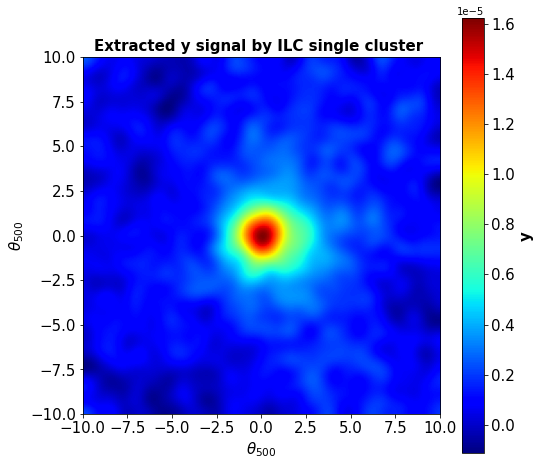

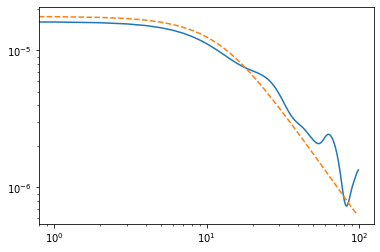

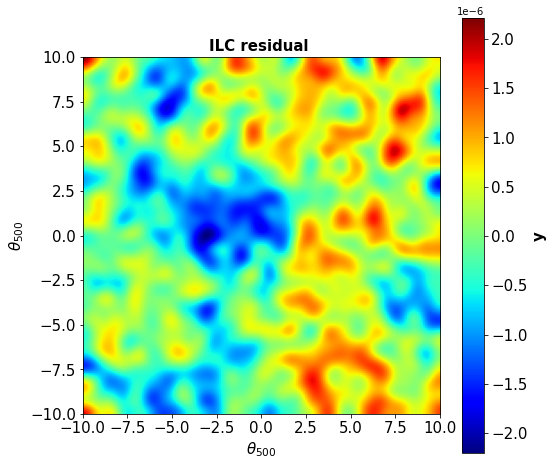

In [233]:
############################## On a single cluster #####################################


ilc_extracted_y_tsz_single = SZ.ilc_run(all_signals_maps_smoothed[10] ,a_tsz_rtsz[10] ,factor=1e6)

ilc_res_y_tsz_single = ilc_extracted_y_tsz_single - y_maps_smoothed[10]


SZ.plot_map_500(8,8,"Extracted y signal by ILC single cluster ",ilc_extracted_y_tsz_single,"y", 200,0) 
plt.show()


plt.plot(ilc_extracted_y_tsz_single[100,100:])
plt.plot(y_maps_smoothed[10][100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



SZ.plot_map_500(8,8,"ILC residual ",ilc_res_y_tsz_single,"y", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tsz_y_single_res_ilc.png", dpi =150)  
# plt.show()


weights = [-15.40912895  22.35723351  -6.10021115  -0.44287007] 

sum weights X a = 1.0000000000036802 

weights = [-3.26134752  6.40270853 -5.06600518  2.32288233] 

sum weights X a = 1.0000000000113536 



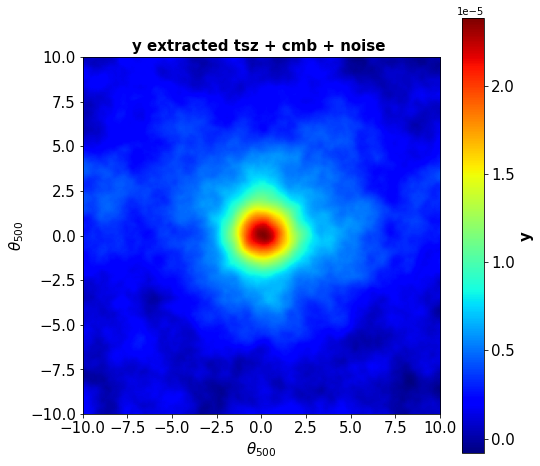

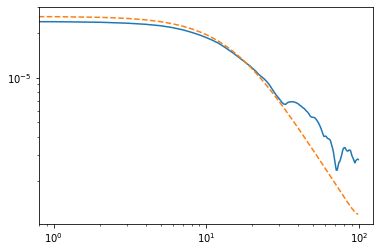

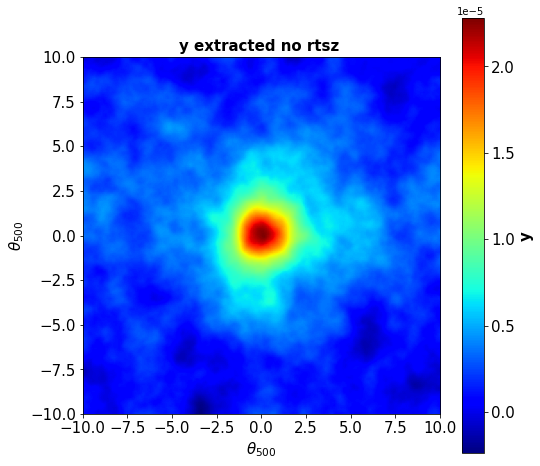

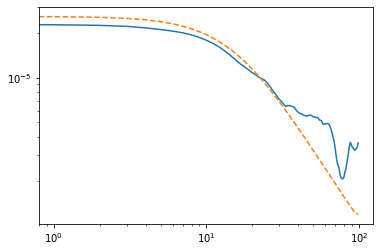

In [59]:

ilc_extracted_y_tsz_no_rtsz = SZ.ilc_run(all_signal_maps_no_rtsz_smoothed_stacked ,a_tsz ,factor=1e6)





################################################################################################################################################################################

ilc_extracted_y_tsz_only = SZ.ilc_run(all_signal_maps_only_tsz_smoothed_stacked ,a_tsz ,factor=1e6)

SZ.plot_map_500(8,8,"y extracted tsz + cmb + noise ",ilc_extracted_y_tsz_only,"y", 200,0)
plt.show()

plt.plot(ilc_extracted_y_tsz_only[100,100:])
plt.plot(y_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()


#ilc_extracted_y_tsz_only_filtered = SZ.ilc_run(all_signal_maps_only_tsz_filtered_smoothed_stacked ,a_tsz ,factor=1e6)


SZ.plot_map_500(8,8,"y extracted no rtsz ",ilc_extracted_y_tsz_no_rtsz,"y", 200,0)
plt.show()

plt.plot(ilc_extracted_y_tsz_no_rtsz[100,100:])
plt.plot(y_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()


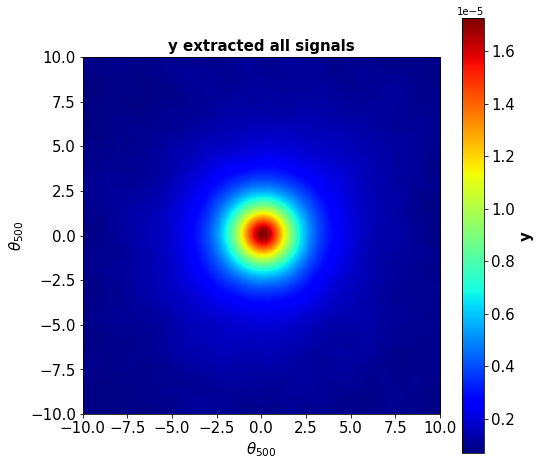

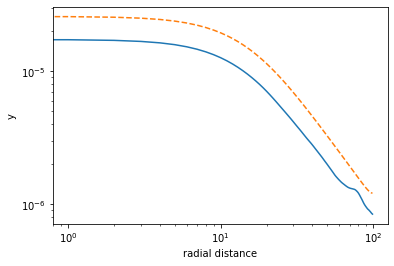

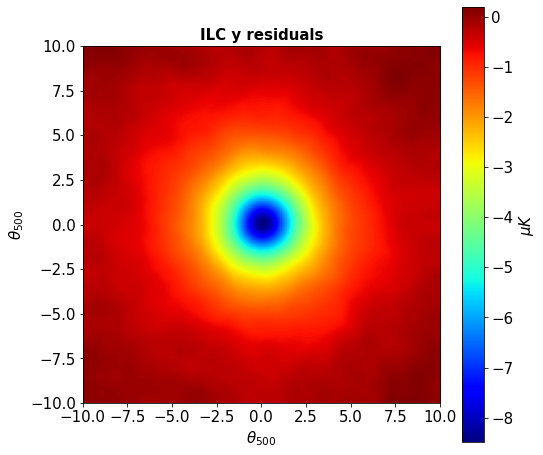

1.230769187983633


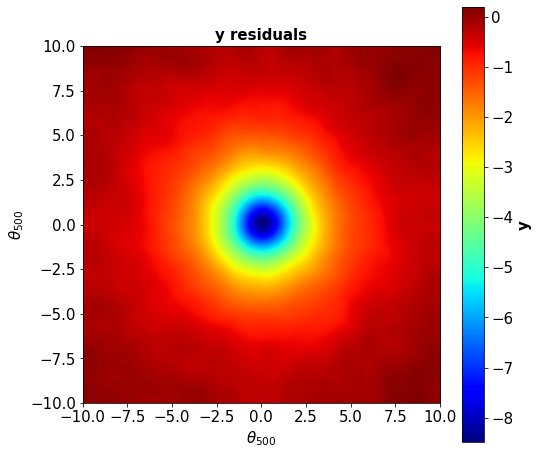

0.25942822474620075
True


In [60]:
################################### Extracted y by running ILC on each cluster and stacking ####################################




ilc_weights_each_tsz = ilc_each_cluster_weight(all_signals_maps_smoothed, a_tsz, red_shifts)

ilc_extracted_each_y_tsz = ilc_run_each_cluster(all_signals_maps_smoothed ,a_tsz , red_shifts, factor=1e6) 

ilc_extracted_each_stacked_y_tsz = np.sum(ilc_extracted_each_y_tsz, axis = 0)/len(red_shifts)



SZ.plot_map_500(8,8,"y extracted all signals",ilc_extracted_each_stacked_y_tsz,"y", 200,0)
plt.show()

plt.plot(ilc_extracted_each_stacked_y_tsz[100,100:])
plt.plot(y_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radial distance')
plt.ylabel('y')
plt.show()

##################### ILC residual =  ILC signal - input y signal ######################################



ilc_residual_y_tsz =  ilc_extracted_each_stacked_y_tsz - y_maps_smoothed_stacked

SZ.plot_map_500(8,8,"ILC y residuals",ilc_residual_y_tsz*1e6,"$\mu K$", 200,0)
plt.show()

print(np.std(ilc_residual_y_tsz*1e6))



#################### ILC noises = weights * CMB+kSZ + rksz + tksz + rtsz + noise  ##################


ilc_signals_noises_each_tsz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, rksz_clusters_maps_smoothed, tksz_clusters_maps_smoothed, rtsz_clusters_maps_smoothed, ilc_weights_each_tsz, nu_cmbs4)

ilc_instrumental_noises_each_tsz = ilc_noise_each(red_shifts, ilc_weights_each_tsz, noise_maps_smoothed, nu_cmbs4)

ilc_noise_each_tsz = ilc_signals_noises_each_tsz + ilc_instrumental_noises_each_tsz

ilc_noise_each_stacked_tsz = np.sum(ilc_noise_each_tsz, axis = 0)/len(red_shifts)


SZ.plot_map_500(8,8,"y residuals",ilc_noise_each_stacked_tsz,"y", 200,0)
plt.show()




############################ ILC noises = weight * (CMB + instrumental) ###########################


ilc_error_noises_cmb_tsz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), ilc_weights_each_tsz, nu_cmbs4)


ilc_error_noises_instrumental_tsz = ilc_noise_each(red_shifts, ilc_weights_each_tsz, noise_maps_smoothed, nu_cmbs4)


ilc_error_noises_tsz = ilc_error_noises_cmb_tsz + ilc_error_noises_instrumental_tsz


ilc_error_noises_stacked_tsz = np.sum(ilc_error_noises_tsz, axis = 0)/len(red_shifts)



print(np.std(ilc_error_noises_stacked_tsz))
print(np.allclose(ilc_residual_y_tsz, ilc_noise_each_stacked_tsz/1e6))

## rtSZ bias correction

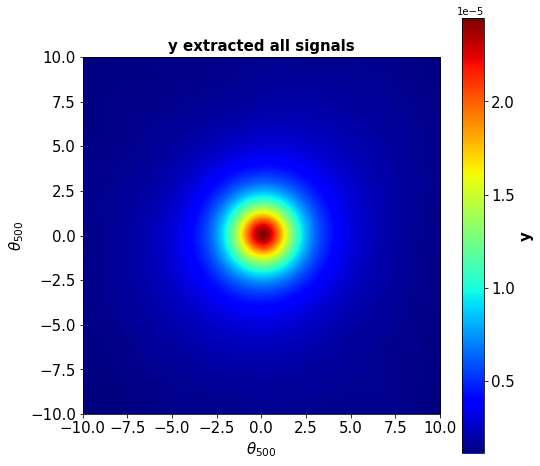

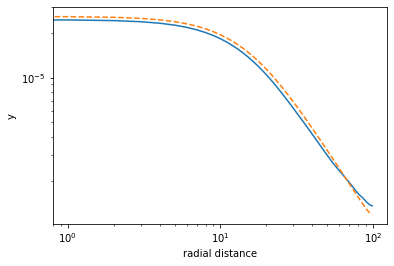

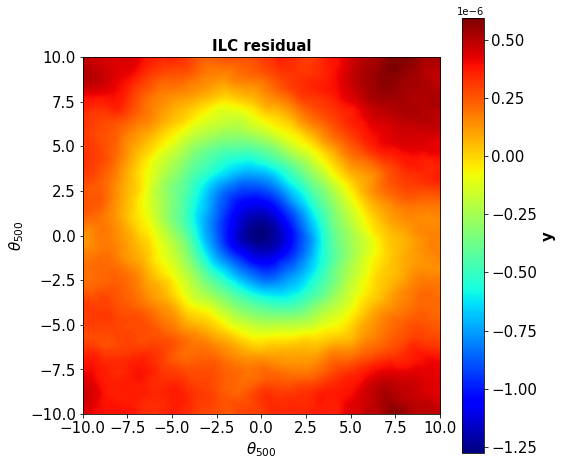

True


In [351]:
################################### Extracted y by running ILC on each cluster and stacking ####################################


ilc_weights_each_tsz_bias_corr = ilc_each_cluster_weight_bias_corr(all_signals_maps_smoothed, a_tsz_rtsz, red_shifts)

ilc_extracted_each_y_tsz_bias_corr = ilc_run_each_cluster_bias_corr(all_signals_maps_smoothed ,a_tsz_rtsz , red_shifts, factor=1e6, offset= False) 

ilc_extracted_each_stacked_y_tsz_bias_corr = np.sum(ilc_extracted_each_y_tsz_bias_corr, axis = 0)/len(red_shifts)



SZ.plot_map_500(8,8,"y extracted all signals",ilc_extracted_each_stacked_y_tsz_bias_corr,"y", 200,0)
plt.show()

plt.plot(ilc_extracted_each_stacked_y_tsz_bias_corr[100,100:])
plt.plot(y_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radial distance')
plt.ylabel('y')
plt.show()


################################### ILC residual =  ILC - input y #########################################


ilc_residual_tsz_bias = ilc_extracted_each_stacked_y_tsz_bias_corr - y_maps_smoothed_stacked

SZ.plot_map_500(8,8,"ILC residual",ilc_residual_tsz_bias,"y", 200,0)
plt.show()


################################## ILC noises = weights * CMB+kSZ + rksz + tksz + noise  ##################



ilc_signals_noises_each_tsz_bias_corr = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, rksz_clusters_maps_smoothed, tksz_clusters_maps_smoothed, np.zeros((500, 4 ,200,200)), ilc_weights_each_tsz_bias_corr, nu_cmbs4)

ilc_instrumental_noises_each_tsz_bias_corr = ilc_noise_each(red_shifts, ilc_weights_each_tsz_bias_corr, noise_maps_smoothed, nu_cmbs4)

ilc_noise_each_tsz_bias_corr = ilc_signals_noises_each_tsz_bias_corr + ilc_instrumental_noises_each_tsz_bias_corr

ilc_noise_each_stacked_tsz_bias_corr = np.sum(ilc_noise_each_tsz_bias_corr, axis = 0)/len(red_shifts)



################################ Checking : ILC residual == ILC noises ###################################


print(np.allclose(ilc_residual_y_tsz_bias_corr,ilc_noise_each_stacked_tsz_bias_corr/1e6 ))




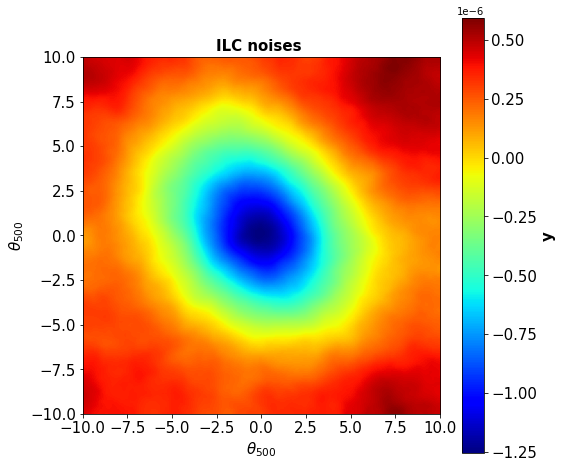

rms residuals =  0.39936368221415686 mu K_CMB

SNR =  64.3680595355262 

SNR brighest pixels =  785.7122985972586 



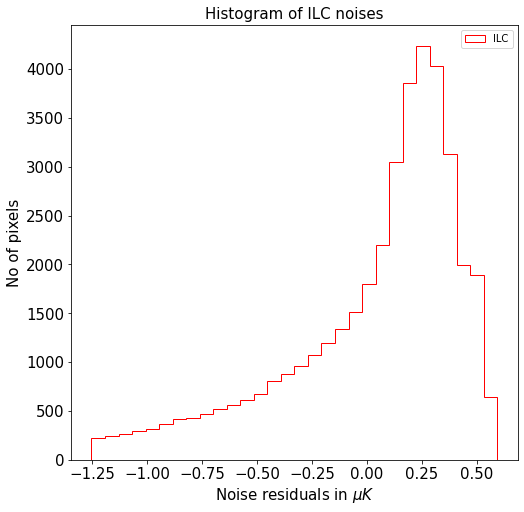

In [380]:
############################ ILC error noises = weight * (CMB + instrumental) ###########################


ilc_error_noises_cmb_tsz_bias_corr = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), ilc_weights_each_tsz_bias_corr, nu_cmbs4)


ilc_error_noises_instrumental_tsz_bias_corr = ilc_noise_each(red_shifts, ilc_weights_each_tsz_bias_corr, noise_maps_smoothed, nu_cmbs4)


ilc_error_noises_tsz_bias_corr = ilc_error_noises_cmb_tsz_bias_corr + ilc_error_noises_instrumental_tsz_bias_corr


ilc_error_noises_stacked_tsz_bias_corr = np.sum(ilc_error_noises_tsz_bias_corr, axis = 0)/len(red_shifts)



SZ.plot_map_500(8,8,"ILC noises ",ilc_error_noises_stacked_tsz_bias_corr/1e6,"y", 200,0)
plt.show()


############################### SNR ###############################################################


############################### Noises =  instrumental + other signals #####################################


ilc_rms_residual_tsz_all_signals = np.sqrt(np.mean((ilc_error_noises_stacked_tsz_bias_corr)**2))/(1e6)            # from muK to unitless 

ilc_rms_residual_tsz_all_signals_CB = ilc_rms_residual_tsz_all_signals/np.sqrt(n_cb)



############### Signal = Central bin of smoothed rkSZ map ###############

signal_y_tsz = y_maps_smoothed[0] # unitless

CB_signal_y_tsz = SZ.radial_profile(signal_y_tsz, 20, 0.25)[0]


################ SNR = Central bin value of the signal/rms noise ################


ilc_snr_tsz_all_signals = CB_signal_y_tsz/ilc_rms_residual_tsz_all_signals

ilc_snr_tsz_all_signals_CB = CB_signal_y_tsz/ilc_rms_residual_tsz_all_signals_CB



print(r"rms residuals = ", ilc_rms_residual_tsz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_tsz_all_signals,'\n')
print("SNR brighest pixels = ",ilc_snr_tsz_all_signals_CB,'\n')


######################## Stacked #########################################

fig = plt.figure(figsize=(8,8))
ax = plt.gca()



plt.hist(ilc_error_noises_stacked_tsz_bias_corr.ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')


plt.title("Histogram of ILC noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)






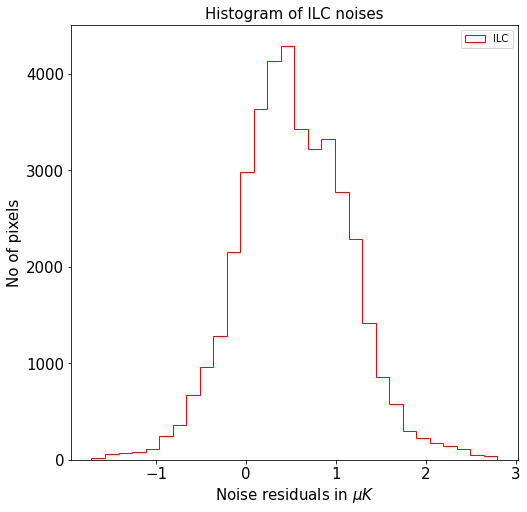

In [348]:
############################################## For a single cluster ########################################


fig = plt.figure(figsize=(8,8))
ax = plt.gca()



plt.hist(ilc_error_noises_tsz_bias_corr[200].ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')


plt.title("Histogram of ILC noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)






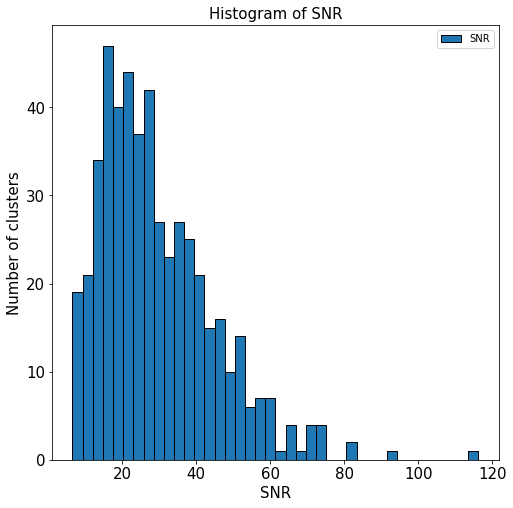

In [355]:

def snr_each_cluster(z, ilc_error_noises, signal_y_tsz):

    snr_each = []
    noise_each = []
    
    
    for i in range(len(z)):
        
        noise_cmb_wn = np.sqrt(np.mean((ilc_error_noises[i])**2))
        noise_each.append(noise_cmb_wn)
        signal_cb = SZ.radial_profile(signal_y_tsz[i], 20, 0.25)[0]
        snr = signal_cb/(noise_cmb_wn/1e6)
        snr_each.append(snr)
        
    return (np.array(snr_each),np.array(noise_each))


snr_each_cluster_tsz, noises_each_cluster_tsz = snr_each_cluster(red_shifts, ilc_error_noises_tsz_bias_corr, y_maps_smoothed)

#print(snr_each_cluster_tsz)


fig = plt.figure(figsize=(8,8))
ax = plt.gca()

plt.hist(snr_each_cluster_tsz, bins=40,  histtype ='barstacked', edgecolor = 'black', label = 'SNR')

plt.title("Histogram of SNR", fontsize=15)
plt.xlabel('SNR', fontsize=15)
plt.ylabel("Number of clusters", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)


In [63]:
# plt.gcf().set_size_inches(8,8)

# hist_fit_tsz_ilc, bin_centres_tsz_ilc = hist_fit(ilc_extracted_each_stacked_y_tsz, 40)

# plt.hist(ilc_extracted_each_stacked_y_tsz.ravel(), bins=40, histtype ='step')

# plt.plot(bin_centres_tsz_ilc, hist_fit_tsz_ilc, 'k')

In [64]:
# ####################  Noises in ILC map: sum ( ilc weights * CMB+kSZ + rksz + tksz + rtsz + noise) ################################


# ilc_noises_tsz_signals = SZ.ilc_noise_all_signals(cmb_ksz_maps_smoothed_stacked, rksz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, ilc_weights_tsz, nu_cmbs4)

# ilc_noises_tsz_instrumental = SZ.ilc_noise(ilc_weights_tsz, noise_maps_smoothed_stacked, nu_cmbs4)

# ilc_noises_tsz = ilc_noises_tsz_signals + ilc_noises_tsz_instrumental


# #################### Check : Extracted ilc signal -  input signal == weight * noises #########################


# ilc_ch_tsz = ilc_extracted_y_tsz - y_maps_smoothed_stacked

# np.allclose(ilc_ch_tsz, ilc_noises_tsz/1e6)



In [65]:
# ####################  Noises in ILC map: sum ( ilc weights * CMB+kSZ + rksz + tksz + rtsz + noise) ################################


# ilc_noises_tsz_signalss = SZ.ilc_noise_all_signals(cmb_ksz_maps_smoothed[5], rksz_clusters_maps_smoothed[5], tksz_clusters_maps_smoothed[5], rtsz_clusters_maps_smoothed[5], weighty_array[5], nu_cmbs4)

# ilc_noises_tsz_instrumentals = SZ.ilc_noise(weighty_array[5], noise_maps_smoothed[5], nu_cmbs4)

# ilc_noises_tszs = ilc_noises_tsz_signalss + ilc_noises_tsz_instrumentals


# #################### Check : Extracted ilc signal -  input signal == weight * noises #########################


# ilc_ch_tszs = SZ.ilc_run(all_signals_maps_smoothed[5] ,a_tsz ,factor=1e6) - y_maps_smoothed[5]

# np.allclose(ilc_ch_tszs, ilc_noises_tszs/1e6)



# Using cILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{iTSZ} = 1 $ and $w_i a_{iKSZ} = 0 $

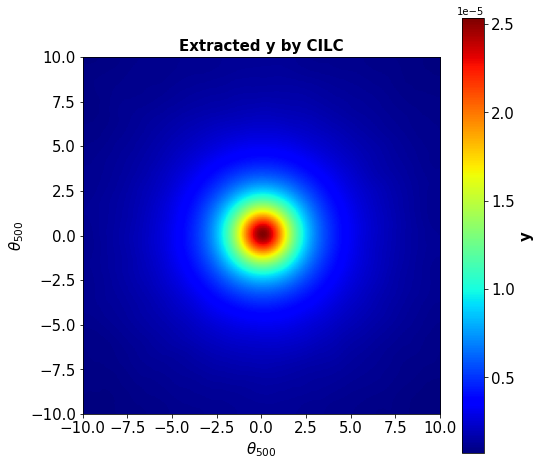

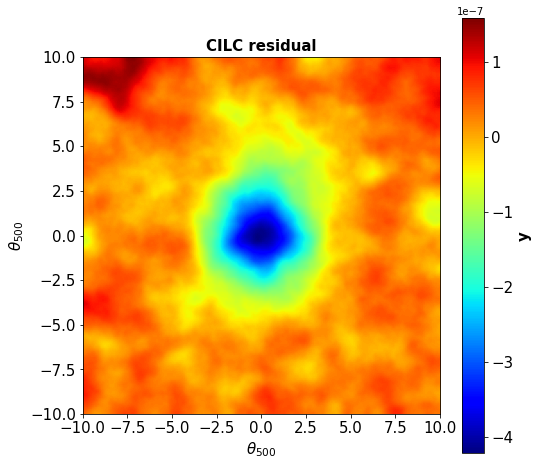

In [376]:

######################### Running CILC on individual clusters ###################################




cilc_weights_each_tsz_bias_corr = cilc_weight_each_bcorr_1(all_signals_maps_smoothed, a_tsz_rtsz,a_ksz, red_shifts)

cilc_extracted_each_y_tsz_bias_corr = cilc_run_each_cluster_bcorr_1(all_signals_maps_smoothed ,a_tsz_rtsz , a_ksz,  red_shifts, factor=1e6, offset= False) 

cilc_extracted_each_stacked_y_tsz_bias_corr = np.sum(cilc_extracted_each_y_tsz_bias_corr, axis = 0)/len(red_shifts)



SZ.plot_map_500(8,8,r"Extracted y by CILC",cilc_extracted_each_stacked_y_tsz_bias_corr,r"y", 200,0)
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tsz_cilc_single.png", dpi =150)
plt.show()


###################### Residual =  CILC - input #################################


cilc_residual_tsz = cilc_extracted_each_stacked_y_tsz_bias_corr - y_maps_smoothed_stacked         # no unit


SZ.plot_map_500(8,8,r"CILC residual",cilc_residual_tsz,r"y", 200,0)
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tsz_res_cilc_single.png", dpi =150)
plt.show()


In [67]:

# cilc_extracted_y_tsz_1 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_tsz, a_ksz)/1e6

# SZ.plot_map_500(8,8,r"y",cilc_extracted_y_tsz_1,r"y", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_y_tsz_1[100,100:])
# plt.plot(y_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')



### $w_i a_{iTSZ} = 1$  and $w_i a_{iRTSZ} = 0 $

In [68]:

cilc_weights_tsz_2 = SZ.cilc_weights_1(all_signal_maps_smoothed_stacked, a_tsz, a_rtsz)


Weights =  [-2.20636897  4.44298134 -3.63312954  1.82578907]
sum weights X a = 1.0000000000010534 

sum weights X b = 5.826450433232822e-13 



In [69]:

# cilc_extracted_y_tsz_2 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_tsz, a_rtsz)/1e6

# SZ.plot_map_500(8,8,r"y",cilc_extracted_y_tsz_2,r"y", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_y_tsz_2[100,100:])
# plt.plot(y_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')


In [70]:
# SZ.plot_map_500(8,8,r"y",cilc_extracted_y_tsz_2[85:115,85:115],r"y", 200, 0.50)
# plt.show()

In [71]:
# plt.gcf().set_size_inches(8,8)


# hist_fit_tsz_cilc, bin_centres_tsz_cilc = hist_fit(cilc_extracted_y_tsz_2, 100)

# plt.hist(cilc_extracted_y_tsz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tsz_cilc, hist_fit_tsz_cilc, 'k')



## $v^2 \tau $ rkSZ Signal

### Using ILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{\text{iRKSZ}} = 1 $

In [72]:

a_rksz = np.array(rksz_spec_cmbs4) * t_cmb

ilc_weights_rksz = SZ.ilc_weights(all_signal_maps_smoothed_stacked, a_rksz)

ilc_weights_rksz_filtered = SZ.ilc_weights(all_signal_maps_filtered_smoothed_stacked, a_rksz)

ilc_weights_rksz_no_rtsz = SZ.ilc_weights(all_signal_maps_no_rtsz_smoothed_stacked, a_rksz)

ilc_weights_rksz_no_rtsz_filtered = SZ.ilc_weights(all_signal_maps_no_rtsz_filtered_smoothed_stacked, a_rksz)



weights = [ 11.55325627 -16.31327248   2.71712343   2.11501826] 

sum weights X a = 1.000000000000004 

weights = [ 11.36224487 -15.9788469    2.53654938   2.16804615] 

sum weights X a = 1.0000000000000124 

weights = [-6.68747331  9.53384364 -0.85380504 -0.52050002] 

sum weights X a = 1.0000000000003126 

weights = [-7.61319048 11.79143325 -3.2555976   0.5794953 ] 

sum weights X a = 1.0000000000001426 



In [73]:
# ####################### Running ILC on stacked maps #############################



# ilc_extracted_rksz = SZ.ilc_run(all_signal_maps_smoothed_stacked, a_rksz, factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$",ilc_extracted_rksz,r"$v^2\tau$", 200, 0.50)
# plt.show()

# plt.plot(ilc_extracted_rksz[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# ilc_extracted_rksz_filtered = SZ.ilc_run(all_signal_maps_filtered_smoothed_stacked ,a_rksz ,factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$ filtered ",ilc_extracted_rksz_filtered,r"$v^2\tau$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_rksz_filtered[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# ###################################################################################################################################

# ilc_extracted_rksz_only = SZ.ilc_run(all_signal_maps_only_rksz_smoothed_stacked ,a_rksz ,factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$ extracted rksz + cmb + noise ",ilc_extracted_rksz_only,r"$v^2\tau$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_rksz_only[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# ilc_extracted_rksz_only_filtered = SZ.ilc_run(all_signal_maps_only_rksz_filtered_smoothed_stacked ,a_rksz ,factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$ extracted rksz + cmb + noise ",ilc_extracted_rksz_only_filtered,r"$v^2\tau$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_rksz_only_filtered[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')



In [74]:

# ilc_extracted_rksz_no_rtsz = SZ.ilc_run(all_signal_maps_no_rtsz_smoothed_stacked, a_rksz, factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$",ilc_extracted_rksz_no_rtsz,r"$v^2\tau$", 200, 0.50)
# plt.show()

# plt.plot(ilc_extracted_rksz_no_rtsz[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# ilc_extracted_rksz_no_rtsz_filtered = SZ.ilc_run(all_signal_maps_no_rtsz_filtered_smoothed_stacked ,a_rksz ,factor=1e6)

# SZ.plot_map_500(8,8,r"$v^2\tau$ filtered ",ilc_extracted_rksz_no_rtsz_filtered,r"$v^2\tau$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_rksz_no_rtsz_filtered[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


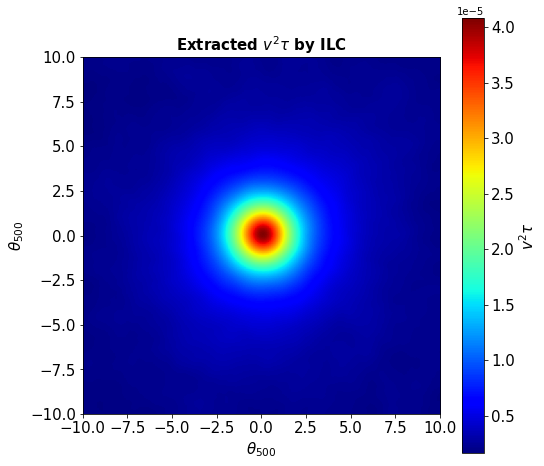

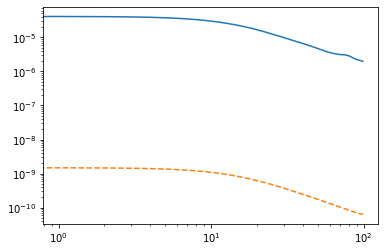

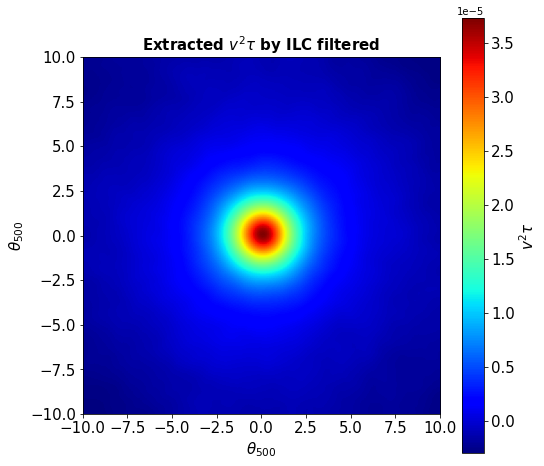

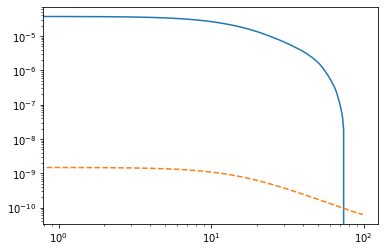

In [75]:
######################### Running ILC on individual clusters ###################################


ilc_weights_each_rksz = ilc_each_cluster_weight(all_signals_maps_smoothed, a_rksz, red_shifts)

ilc_weights_each_filtered_rksz = ilc_each_cluster_weight(all_signals_maps_filtered_smoothed, a_rksz, red_shifts)




ilc_extracted_each_rksz = ilc_run_each_cluster(all_signals_maps_smoothed, a_rksz, red_shifts, 1e6, offset = False)  

ilc_extracted_each_stacked_rksz = np.sum(ilc_extracted_each_rksz, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ by ILC",ilc_extracted_each_stacked_rksz,r"$v^2\tau$", 200,0)
plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_ilc.png", dpi =150)
plt.show()


plt.plot(ilc_extracted_each_stacked_rksz[100,100:])
plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()


############################  Filtered  #########################################



ilc_extracted_each_filtered_rksz = ilc_run_each_cluster(all_signals_maps_filtered_smoothed, a_rksz, red_shifts, 1e6, offset = True)  


ilc_extracted_each_filtered_stacked_rksz = np.sum(ilc_extracted_each_filtered_rksz, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ by ILC filtered ",ilc_extracted_each_filtered_stacked_rksz,r"$v^2\tau$", 200,0)
plt.show()


plt.plot(ilc_extracted_each_filtered_stacked_rksz[100,100:])
plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



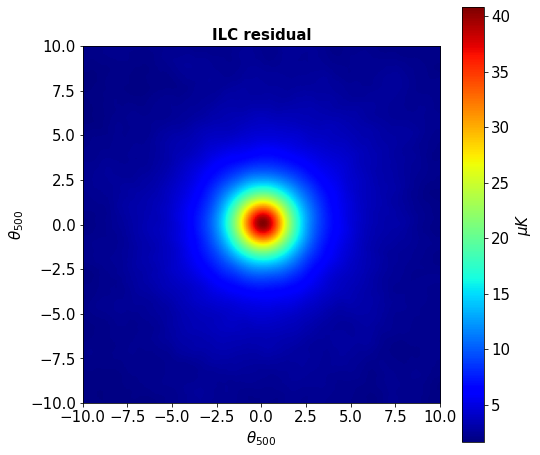

True


In [76]:
############################ ILC residual #########################



ilc_residual_rksz = ilc_extracted_each_stacked_rksz - input_rksz_maps_smoothed_stacked           # no unit


SZ.plot_map_500(8,8,r"ILC residual",ilc_residual_rksz*1e6,r"$\mu K$", 200,0)
plt.show()





########################## ILC residual =  weight * (tSZ + rtSZ + instrumental noise) ############################################




ilc_signals_noises_each_rksz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, tsz_clusters_maps_smoothed, tksz_clusters_maps_smoothed, rtsz_clusters_maps_smoothed, ilc_weights_each_rksz, nu_cmbs4)

ilc_instrumental_noises_each_rksz = ilc_noise_each(red_shifts, ilc_weights_each_rksz, noise_maps_smoothed, nu_cmbs4)

ilc_total_noise_each_rksz = ilc_signals_noises_each_rksz + ilc_instrumental_noises_each_rksz

ilc_total_noise_each_stacked_rksz = np.sum(ilc_total_noise_each_rksz, axis = 0)/len(red_shifts)



print(np.allclose(ilc_residual_rksz,ilc_total_noise_each_stacked_rksz/1e6))




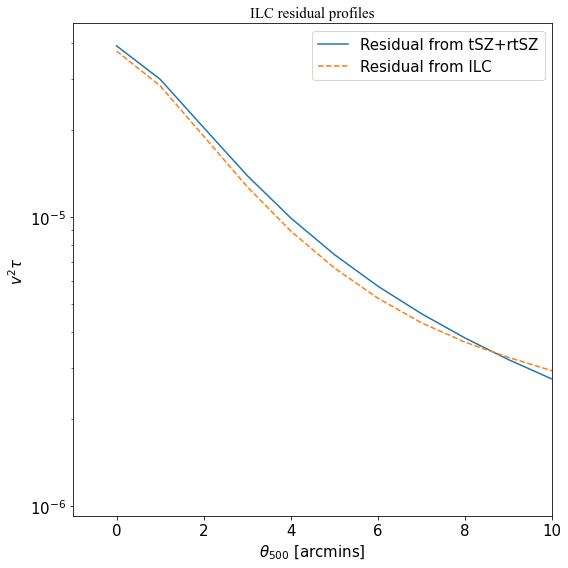

In [369]:
####################### Checking main contribution comes from tSZ+rtSZ #########################

ilc_signals_noises_maj_contribution_rksz = ilc_signals_each(red_shifts, np.zeros((500,200,200)), tsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), rtsz_clusters_maps_smoothed, ilc_weights_each_rksz, nu_cmbs4)

ilc_signals_noises_maj_contribution_stacked_rksz = np.sum(ilc_signals_noises_maj_contribution_rksz, axis = 0)/len(red_shifts)


# SZ.plot_map_500(8,8,r"ILC residual",ilc_signals_noises_maj_contribution_stacked_rksz/1e6,r"$\mu K$", 200,0)
# plt.show()


################################# Matching profiles ############################################

plt.plot(SZ.radial_profile(ilc_signals_noises_maj_contribution_stacked_rksz/1e6, 20, 0.25), label = 'Residual from tSZ+rtSZ')
plt.plot(SZ.radial_profile(ilc_residual_rksz, 20, 0.25),'--', label = 'Residual from ILC')


plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2 \tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("ILC residual profiles", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.show()


In [78]:
# ######################### pixel histogram of extracted ILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_each_rksz_ilc, bin_centres_each_rksz_ilc = hist_fit(ilc_extracted_each_stacked_rksz, 50)

# plt.hist(ilc_extracted_each_stacked_rksz.ravel(), bins=50, histtype ='step')

# plt.plot(bin_centres_each_rksz_ilc, hist_fit_each_rksz_ilc, 'k')


In [79]:
# ######################### pixel histogram of extracted ILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_ilc, bin_centres_rksz_ilc = hist_fit(ilc_extracted_rksz, 100)

# plt.hist(ilc_extracted_rksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_ilc, hist_fit_rksz_ilc, 'k')



In [80]:
# ####################  Noises in ILC map: sum ( ilc weights * CMB+kSZ + tsz + tksz + rtsz + noise) ################################



# ilc_noises_rksz_signals = SZ.ilc_noise_all_signals(cmb_ksz_maps_smoothed_stacked, tsz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, ilc_weights_rksz, nu_cmbs4)

# ilc_noises_rksz_instrumental = SZ.ilc_noise(ilc_weights_rksz, noise_maps_smoothed_stacked, nu_cmbs4)

# ilc_noises_rksz = ilc_noises_rksz_signals + ilc_noises_rksz_instrumental


# #################### Check : Extracted ilc signal -  input signal == weight * noises #########################


# ilc_chk_rksz  = ilc_extracted_rksz - input_rksz_maps_smoothed_stacked

# print(np.allclose(ilc_chk_rksz, ilc_noises_rksz/1e6))



# ####################  Noises in ILC map: sum ( ilc weights * filtered CMB+kSZ + tsz + tksz + rtsz + noise) ################################



# ilc_noises_rksz_signals_filtered = SZ.ilc_noise_all_signals(cmb_ksz_maps_filtered_smoothed_stacked, tsz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, ilc_weights_rksz_filtered, nu_cmbs4)

# ilc_noises_rksz_instrumental_filtered = SZ.ilc_noise(ilc_weights_rksz_filtered, noise_maps_smoothed_stacked, nu_cmbs4)

# ilc_noises_rksz_filtered = ilc_noises_rksz_signals_filtered + ilc_noises_rksz_instrumental_filtered


# #################### Check : Extracted ilc signal -  input signal == weight * noises #########################


# ilc_chk_rksz_filtered  = ilc_extracted_rksz_filtered - input_rksz_maps_smoothed_stacked

# np.allclose(ilc_chk_rksz_filtered, ilc_noises_rksz_filtered/1e6)



In [81]:

# SZ.plot_map_500(8,8,r"ILC residual",ilc_noises_rksz,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_ilc, bin_centres_res_rksz_ilc = hist_fit(ilc_noises_rksz, 50)

# plt.title("Pixel histogram of ILC residual")

# plt.hist(ilc_noises_rksz.ravel(), bins=50, histtype ='step')

# plt.plot(bin_centres_res_rksz_ilc, hist_fit_res_rksz_ilc, 'k')


## Using cILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{iRKSZ} = 1 $ and $w_i a_{iKSZ} = 0 $

In [82]:
#################### CILC weights #############################

cilc_weights_rksz_1 = SZ.cilc_weights_1(all_signal_maps_smoothed_stacked, a_rksz, a_ksz)


Weights =  [ 12.14335989 -17.13513958   2.75603412   2.23574557]
sum weights X a = 0.9999999999999938 

sum weights X b = 2.220446049250313e-15 



In [83]:
# ################### Extracting v^2 tau #################################


# cilc_extracted_rksz_1 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_rksz, a_ksz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$",cilc_extracted_rksz_1,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_1[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [84]:
# ######################### pixel histogram of extracted CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_cilc_1, bin_centres_rksz_cilc_1 = hist_fit(cilc_extracted_rksz_1, 50)

# plt.title("Pixel histogram of CILC extracted signal")

# plt.hist(cilc_extracted_rksz_1.ravel(), bins=50, histtype ='step')

# plt.plot(bin_centres_rksz_cilc_1, hist_fit_rksz_cilc_1, 'k')


In [85]:
# ####################  Noises in CILC map: sum ( ilc weights * tsz + tksz + rtsz + noise) ################################


# cilc_noises_rksz_1 = SZ.cilc_noise(tsz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, noise_maps_smoothed_stacked, cilc_weights_rksz_1, nu_cmbs4)


# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_rksz_1 = cilc_extracted_rksz_1 - input_rksz_maps_smoothed_stacked

# np.allclose(cilc_chk_rksz_1, cilc_noises_rksz_1/(1e6))



In [86]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_rksz_1,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_cilc_1, bin_centres_res_rksz_cilc_1 = hist_fit(cilc_noises_rksz_1, 50)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_rksz_1.ravel(), bins=50, histtype ='step')

# plt.plot(bin_centres_res_rksz_cilc_1, hist_fit_res_rksz_cilc_1, 'k')


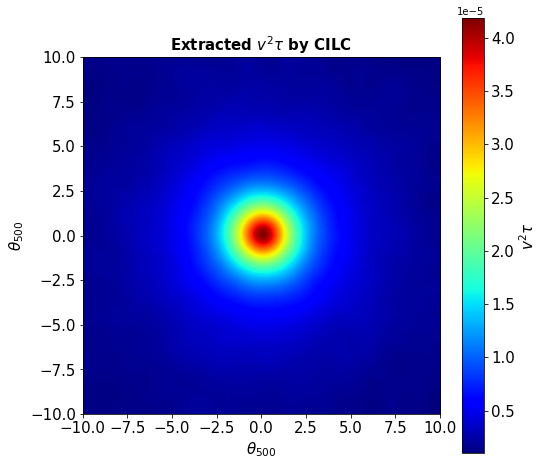

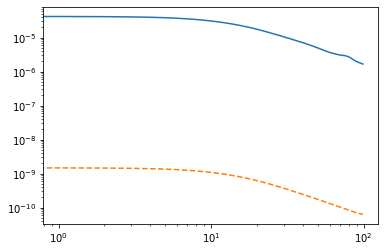

In [87]:
######################### Running CILC on individual clusters ###################################



cilc_weights_each_rksz_1 = cilc_weight_each(all_signals_maps_smoothed, a_rksz, a_ksz, red_shifts)


cilc_extracted_each_rksz_1 = cilc_run_each_cluster(all_signals_maps_smoothed, a_rksz, a_ksz, red_shifts, 1e6, offset = False)  


cilc_extracted_each_stacked_rksz_1 = np.sum(cilc_extracted_each_rksz_1, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ by CILC",cilc_extracted_each_stacked_rksz_1,r"$v^2\tau$", 200,0)
plt.show()


plt.plot(cilc_extracted_each_stacked_rksz_1[100,100:])
plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



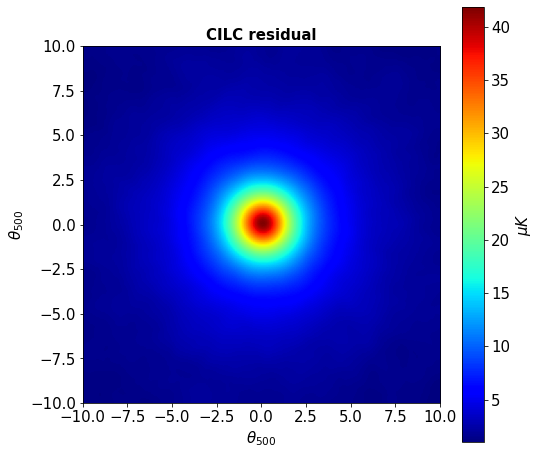

True


In [88]:
############################ CILC residual =  extracted CILC - input signal  #########################


cilc_residual_rksz_1 = cilc_extracted_each_stacked_rksz_1 - input_rksz_maps_smoothed_stacked           # no unit


SZ.plot_map_500(8,8,r"CILC residual",cilc_residual_rksz_1*1e6,r"$\mu K$", 200,0)
plt.show()



########################## CILC residual noises =  weight * tsz + tksz + rtsz + noises #################################


cilc_noises_each_rksz_1 = cilc_each_noise(red_shifts, tsz_clusters_maps_smoothed, tksz_clusters_maps_smoothed, rtsz_clusters_maps_smoothed, noise_maps_smoothed, cilc_weights_each_rksz_1, nu_cmbs4)

cilc_noises_each_stacked_rksz_1 =  np.sum(cilc_noises_each_rksz_1, axis = 0)/len(red_shifts)


print(np.allclose(cilc_residual_rksz_1, cilc_noises_each_stacked_rksz_1/1e6))


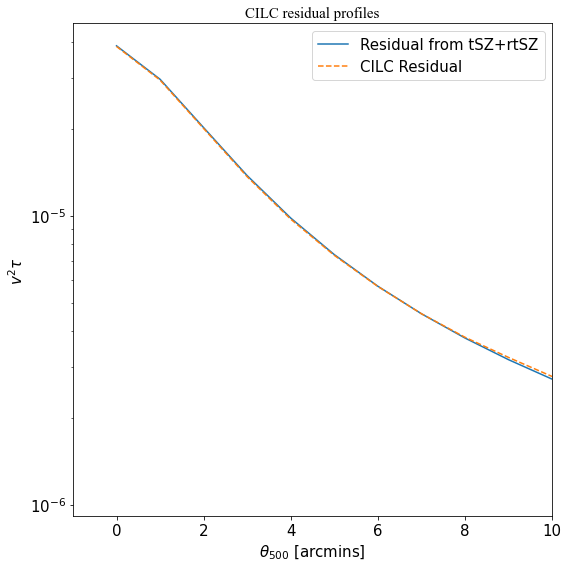

In [368]:
####################### Checking main contribution comes from tSZ+rtSZ #########################

cilc_signals_noises_maj_contribution_rksz = cilc_each_noise(red_shifts, tsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), rtsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), cilc_weights_each_rksz_1, nu_cmbs4)

cilc_signals_noises_maj_contribution_stacked_rksz = np.sum(cilc_signals_noises_maj_contribution_rksz, axis = 0)/len(red_shifts)


# SZ.plot_map_500(8,8,r"CILC residual",cilc_signals_noises_maj_contribution_stacked_rksz/1e6,r"$v^2 \tau$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_res_main_cilc.png", dpi =150)
# plt.show()


#################################### Matching profiles #########################################

plt.plot(SZ.radial_profile(cilc_signals_noises_maj_contribution_stacked_rksz/1e6, 20, 0.25), label = 'Residual from tSZ+rtSZ')
plt.plot(SZ.radial_profile(cilc_residual_rksz_1, 20, 0.25),'--', label = 'CILC Residual')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2 \tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("CILC residual profiles", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_cilc_res_profile.png", dpi =150)
plt.show()

### $w_i a_{iRKSZ} = 1 $ and $w_i a_{iTSZ} + w_i a_{iRTSZ}  = 0 $

In [90]:
#################### CILC weights #######################

cilc_weights_each_rksz_2 = cilc_weight_each_bcorr(all_signals_maps_smoothed, a_rksz, a_tsz_rtsz, red_shifts)

cilc_weights_each_filtered_rksz_2 = cilc_weight_each_bcorr(all_signals_maps_filtered_smoothed, a_rksz, a_tsz_rtsz, red_shifts)



In [91]:
# #################### Extracting v^2 tau signal #######################


# cilc_extracted_rksz_2 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_rksz, a_tsz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$",cilc_extracted_rksz_2,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_2[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()




# cilc_extracted_rksz_filtered_2 = SZ.cilc_run_1(all_signal_maps_filtered_smoothed_stacked, a_rksz, a_tsz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$ filtered",cilc_extracted_rksz_filtered_2,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_filtered_2[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')


In [92]:

# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_cilc_2, bin_centres_rksz_cilc_2 = hist_fit(cilc_extracted_rksz_2, 100)

# plt.title("Pixel histogram of extracted CILC")

# plt.hist(cilc_extracted_rksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_cilc_2, hist_fit_rksz_cilc_2, 'k')


In [93]:
# ####################  Noises in CILC map: sum ( ilc weights * CMB+kSZ + tksz + rtsz + noise) ################################

# cilc_noises_rksz_signals_1 = SZ.cilc_noise(np.zeros((4,200,200)), tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, noise_maps_smoothed_stacked, cilc_weights_rksz_2, nu_cmbs4)

# cilc_noises_rksz_cmb_1 = SZ.cilc_cmb(cilc_weights_rksz_2, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# cilc_noises_rksz_2 = cilc_noises_rksz_signals_1 + cilc_noises_rksz_cmb_1



# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_rksz_2 = cilc_extracted_rksz_2 - input_rksz_maps_smoothed_stacked

# np.allclose(cilc_chk_rksz_2, cilc_noises_rksz_2/(1e6))


In [94]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_rksz_2,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_cilc_2, bin_centres_res_rksz_cilc_2 = hist_fit(cilc_noises_rksz_2, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_rksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_rksz_cilc_2, hist_fit_res_rksz_cilc_2, 'k')


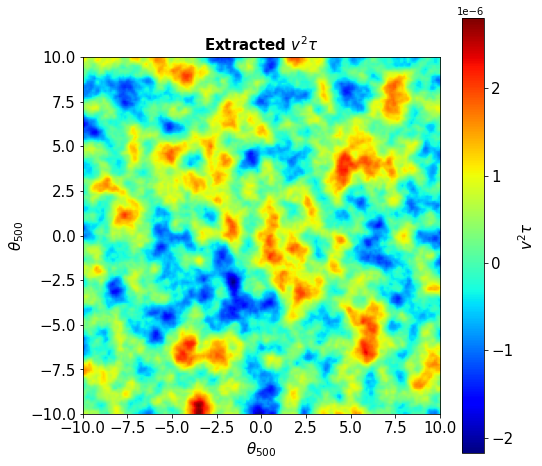

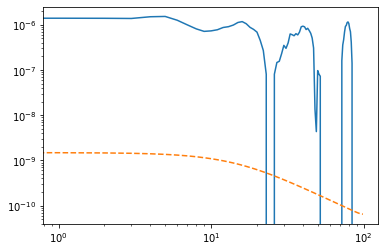

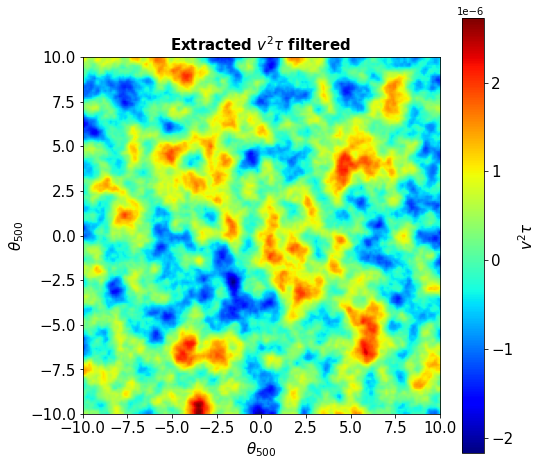

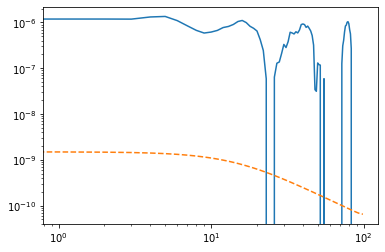

In [95]:
######################### Running CILC on individual clusters ###################################


cilc_extracted_each_rksz_2 = cilc_run_each_cluster_bcorr(all_signals_maps_smoothed, a_rksz, a_tsz_rtsz, red_shifts, 1e6, offset = False)  


cilc_extracted_each_stacked_rksz_2 = np.sum(cilc_extracted_each_rksz_2, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$",cilc_extracted_each_stacked_rksz_2,r"$v^2\tau$", 200,0)

plt.show()


plt.plot(cilc_extracted_each_stacked_rksz_2[100,100:])
plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



########################### On filtered CMB ############################################


cilc_extracted_each_filtered_rksz_2 = cilc_run_each_cluster_bcorr(all_signals_maps_filtered_smoothed, a_rksz, a_tsz_rtsz, red_shifts, 1e6, offset = False)  


cilc_extracted_each_filtered_stacked_rksz_2 = np.sum(cilc_extracted_each_filtered_rksz_2, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ filtered ",cilc_extracted_each_filtered_stacked_rksz_2,r"$v^2\tau$", 200,0)
plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_cilc_filtered_2.png", dpi =150)
plt.show()


plt.plot(cilc_extracted_each_filtered_stacked_rksz_2[100,100:])
plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



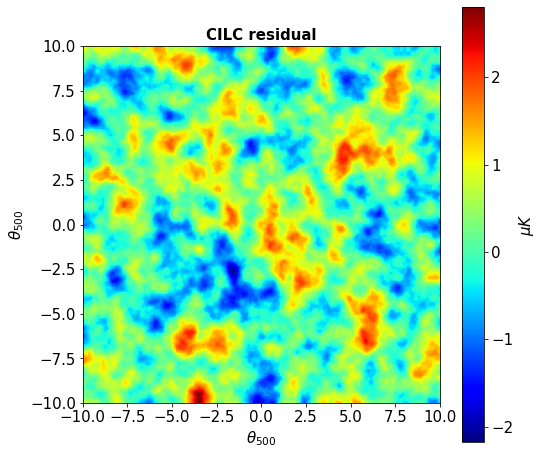

False


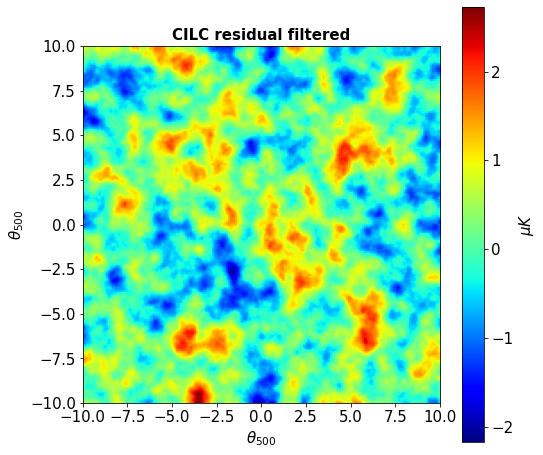

False


In [96]:
############################ CILC residual #########################


cilc_residual_rksz_2 = cilc_extracted_each_stacked_rksz_2 - input_rksz_maps_smoothed_stacked           # no unit



SZ.plot_map_500(8,8,r"CILC residual",cilc_residual_rksz_2*1e6,r"$\mu K$", 200,0)
plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_res_cilc_2.png", dpi =150)
plt.show()





cilc_signal_noises_each_rksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), tksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_rksz_2, nu_cmbs4)

cilc_cmb_noises_each_rksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_rksz_2, cmb_ksz_maps_smoothed, nu_cmbs4 )

cilc_noises_each_rksz_2 = cilc_signal_noises_each_rksz_2 + cilc_cmb_noises_each_rksz_2


print(np.allclose(cilc_residual_rksz_2, cilc_noises_each_rksz_2/1e6))


############################ filtered ##############################


cilc_residual_filtered_rksz_2 = cilc_extracted_each_filtered_stacked_rksz_2 - input_rksz_maps_smoothed_stacked           # no unit



SZ.plot_map_500(8,8,r"CILC residual filtered",cilc_residual_filtered_rksz_2*1e6,r"$\mu K$", 200,0)
plt.show()




cilc_signal_noises_each_filtered_rksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), tksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_filtered_rksz_2, nu_cmbs4)

cilc_cmb_noises_each_filtered_rksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_filtered_rksz_2, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

cilc_noises_each_filtered_rksz_2 = cilc_signal_noises_each_filtered_rksz_2 + cilc_cmb_noises_each_filtered_rksz_2


print(np.allclose(cilc_residual_filtered_rksz_2, cilc_noises_each_filtered_rksz_2/1e6))



In [97]:
# #################### Extracting v^2 tau signal #############################


# cilc_extracted_rksz_3 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_rksz, a_rtsz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$",cilc_extracted_rksz_3,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_3[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')


In [98]:

# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_cilc_3, bin_centres_rksz_cilc_3 = hist_fit(cilc_extracted_rksz_3, 100)

# plt.title("Pixel histogram of extracted CILC")

# plt.hist(cilc_extracted_rksz_3.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_cilc_3, hist_fit_rksz_cilc_3, 'k')



In [99]:
# ####################  Noises in CILC map: sum ( ilc weights * CMB+kSZ + tsz + tksz + noise) ################################

# cilc_noises_rksz_signals_2 = SZ.cilc_noise(tsz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, np.zeros((4,200,200)), noise_maps_smoothed_stacked, cilc_weights_rksz_3, nu_cmbs4)

# cilc_noises_rksz_cmb_2 = SZ.cilc_cmb(cilc_weights_rksz_3, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# cilc_noises_rksz_3 = cilc_noises_rksz_signals_2 + cilc_noises_rksz_cmb_2


# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_rksz_3 = cilc_extracted_rksz_3 - input_rksz_maps_smoothed_stacked

# np.allclose(cilc_chk_rksz_3, cilc_noises_rksz_3/(1e6))



In [100]:
# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_rksz_3,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_cilc_3, bin_centres_res_rksz_cilc_3 = hist_fit(cilc_noises_rksz_3, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_rksz_3.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_rksz_cilc_3, hist_fit_res_rksz_cilc_3, 'k')


# Constraining 2 parameters 

## $w_i a_{iRKSZ} = 1 $ and $w_i a_{iTSZ} = 0,  w_i a_{iRTSZ} = 0$

In [101]:
############# Calculating gILC weights ##############

A_rksz_1 = np.array([a_rksz, a_tsz, a_rtsz])

e_rksz_1 = np.array([1,0,0]) 

gilc_weights_rksz_1 = SZ.cilc_weights_2(all_signal_maps_smoothed_stacked, A_rksz_1, e_rksz_1)


gilc_weights_rksz_filtered_1 = SZ.cilc_weights_2(all_signal_maps_filtered_smoothed_stacked, A_rksz_1, e_rksz_1)


Weights =  [-1.84160676  1.87035261  3.3126896  -1.38586599]
Weights X a =  1.425037865487866e-11
Weights =  [-2.54831598  4.22179998  0.01181001  0.27027546]
Weights X a =  1.501876401022173e-11


In [102]:
# ############## Extracting v^2 tau signal #####################


# gilc_extracted_rksz_1 = SZ.cilc_run_2(all_signal_maps_smoothed_stacked, A_rksz_1, e_rksz_1)/(1e6)

# SZ.plot_map_500(8,8,r"$v^2 \tau$",gilc_extracted_rksz_1,r"$v^2 \tau$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_rksz_1[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.show()


# gilc_extracted_rksz_filtered_1 = SZ.cilc_run_2(all_signal_maps_filtered_smoothed_stacked, A_rksz_1, e_rksz_1)/(1e6)

# SZ.plot_map_500(8,8,r"$v^2 \tau$",gilc_extracted_rksz_filtered_1,r"$v^2 \tau$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_rksz_filtered_1[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')


In [103]:
# ######################### pixel histogram of extracted gILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_gilc_1, bin_centres_rksz_gilc_1 = hist_fit(gilc_extracted_rksz_1, 100)

# plt.title("Pixel histogram of extracted gILC")

# plt.hist(gilc_extracted_rksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_gilc_1, hist_fit_rksz_gilc_1, 'k')


In [104]:
# ####################  Noises in gILC map: sum ( gilc weights * CMB+kSZ + rksz + noise) ################################


# gilc_noises_rksz_signals_1 = SZ.cilc_noise(np.zeros((4,200,200)), tksz_clusters_maps_smoothed_stacked, np.zeros((4,200,200)), noise_maps_smoothed_stacked, gilc_weights_rksz_1, nu_cmbs4)

# gilc_noises_rksz_cmb_1 = SZ.cilc_cmb(gilc_weights_rksz_1, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# gilc_noises_rksz_1 = gilc_noises_rksz_signals_1 + gilc_noises_rksz_cmb_1


# #################### Check : Extracted gilc signal -  input signal == weight * gilc noises #########################  

# gilc_chk_rksz_1 = gilc_extracted_rksz_1 - input_rksz_maps_smoothed_stacked

# np.allclose(gilc_chk_rksz_1, gilc_noises_rksz_1/(1e6))



In [105]:

# SZ.plot_map_500(8,8,r"gILC residual",gilc_noises_rksz_1,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_gilc_1, bin_centres_res_rksz_gilc_1 = hist_fit(gilc_noises_rksz_1, 100)

# plt.title("Pixel histogram of gILC residual")

# plt.hist(gilc_noises_rksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_rksz_gilc_1, hist_fit_res_rksz_gilc_1, 'k')


In [106]:
# ######################### Running gILC on individual clusters ###################################


# gilc_weights_each_rksz_1 = gilc_weight_each(all_signals_maps_smoothed, A_rksz_1, e_rksz_1, red_shifts)


# gilc_extracted_each_rksz_1 = gilc_run_each_cluster(all_signals_maps_smoothed, A_rksz_1, e_rksz_1, red_shifts, 1e6, offset = True)  


# gilc_extracted_each_stacked_rksz_1 = np.sum(gilc_extracted_each_rksz_1, axis = 0)/len(red_shifts)




# SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ by CILC",gilc_extracted_each_stacked_rksz_1,r"$v^2\tau$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_stacked_rksz_1[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# ######################### Filtered ############################################


# gilc_weights_each_filtered_rksz_1 = gilc_weight_each(all_signals_maps_filtered_smoothed, A_rksz_1, e_rksz_1, red_shifts)


# gilc_extracted_each_filtered_rksz_1 = gilc_run_each_cluster(all_signals_maps_filtered_smoothed, A_rksz_1, e_rksz_1, red_shifts, 1e6, offset = True)  


# gilc_extracted_each_filtered_stacked_rksz_1 = np.sum(gilc_extracted_each_filtered_rksz_1, axis = 0)/len(red_shifts)




# SZ.plot_map_500(8,8,r"Extracted $v^2 \tau$ by CILC filtered ",gilc_extracted_each_filtered_stacked_rksz_1,r"$v^2\tau$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_filtered_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_filtered_stacked_rksz_1[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [107]:
# ############################ CILC residual #########################

# gilc_residual_rksz_1 = gilc_extracted_each_stacked_rksz_1 - input_rksz_maps_smoothed_stacked           # no unit

# SZ.plot_map_500(8,8,r"CILC residual",gilc_residual_rksz_1*1e6,r"$\mu K$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_res_gilc.png", dpi =150)
# plt.show()





# gilc_signal_noises_each_rksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), tksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_rksz_1, nu_cmbs4)

# gilc_cmb_noises_each_rksz_1 = cilc_each_cmb(red_shifts, gilc_weights_each_rksz_1, cmb_ksz_maps_smoothed, nu_cmbs4 )

# gilc_noises_each_rksz_1 = gilc_signal_noises_each_rksz_1 + gilc_cmb_noises_each_rksz_1


# ############################ filtered ##############################


# gilc_residual_filtered_rksz_1 = gilc_extracted_each_filtered_stacked_rksz_1 - input_rksz_maps_smoothed_stacked           # no unit

# SZ.plot_map_500(8,8,r"CILC residual filtered",gilc_residual_filtered_rksz_1*1e6,r"$\mu K$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_cilc.png", dpi =150)
# plt.show()




# gilc_signal_noises_each_filtered_rksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), tksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_filtered_rksz_1, nu_cmbs4)

# gilc_cmb_noises_each_filtered_rksz_1 = cilc_each_cmb(red_shifts, gilc_weights_each_filtered_rksz_1, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

# gilc_noises_each_filtered_rksz_1 = gilc_signal_noises_each_filtered_rksz_1 + gilc_cmb_noises_each_filtered_rksz_1




# ########################### gILC error noises ####################################


# gilc_error_noises_intrumental_filtered_rksz = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_filtered_rksz_1, nu_cmbs4)

# gilc_error_noises_cmb_filtered_rksz = cilc_each_cmb(red_shifts, gilc_weights_each_filtered_rksz_1, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

# gilc_error_noises_filtered_rksz = gilc_error_noises_intrumental_filtered_rksz + gilc_error_noises_cmb_filtered_rksz

# gilc_error_noises_stacked_filtered_rksz = np.sum(gilc_error_noises_filtered_rksz, axis = 0)/len(red_shifts)



## Histogram of different noise residuals 

In [264]:

############################ ILC error noises = weight * (CMB + instrumental) ###########################


ilc_error_noises_cmb_rksz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), ilc_weights_each_rksz, nu_cmbs4)

ilc_error_noises_instrumental_rksz = ilc_noise_each(red_shifts, ilc_weights_each_rksz, noise_maps_smoothed, nu_cmbs4)

ilc_error_noises_rksz =  ilc_error_noises_instrumental_rksz +  ilc_error_noises_cmb_rksz

ilc_error_noises_stacked_rksz = np.sum(ilc_error_noises_rksz, axis = 0)/len(red_shifts)




############################ CILC error noises 1 = weights * (CMB + instrumental) ###########################


cilc_error_noises_instrumental_rksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_rksz_1, nu_cmbs4)

cilc_error_noises_rksz_1 = cilc_error_noises_instrumental_rksz_1

cilc_error_noises_stacked_rksz_1 = np.sum(cilc_error_noises_rksz_1, axis = 0)/len(red_shifts)





############################ CILC error noises 2 = weights * (CMB + instrumental) ####################################


cilc_error_noises_intrumental_filtered_rksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_filtered_rksz_2, nu_cmbs4)

cilc_error_noises_cmb_filtered_rksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_filtered_rksz_2, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

cilc_error_noises_filtered_rksz_2 = cilc_error_noises_intrumental_filtered_rksz_2 + cilc_error_noises_cmb_filtered_rksz_2

cilc_error_noises_stacked_filtered_rksz_2 = np.sum(cilc_error_noises_filtered_rksz_2, axis = 0)/len(red_shifts)


############################################### SNR #################################################



################################ ILC Noises =  instrumental + CMB #########################################


ilc_rms_residual_rksz = np.sqrt(np.mean((ilc_error_noises_stacked_rksz)**2))/1e6         # unitless


################################ Signal = Central bin of smoothed stacked v^2 tau signal ###############


signal_v2_tau_rksz = input_rksz_maps_smoothed_stacked    # unitless

CB_signal_v2_tau_rksz = SZ.radial_profile(signal_v2_tau_rksz, 20, 0.20)[0]
print("Signal in CB = ",CB_signal_v2_tau_rksz,'\n' )


################################ SNR = Central bin value of the signal/rms noise ################


ilc_snr_rksz_all_signals = CB_signal_v2_tau_rksz/ilc_rms_residual_rksz


print(r"ILC rms residuals = ", ilc_rms_residual_rksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_rksz_all_signals,'\n')


############################### CILC Noises =  instrumental ######################################


cilc_rms_residual_rksz_1 = np.sqrt(np.mean((cilc_error_noises_stacked_rksz_1)**2))/1e6         # unitless



############################## SNR = Central bin value of the signal/rms noise ################


cilc_snr_rksz_1 = CB_signal_v2_tau_rksz/cilc_rms_residual_rksz_1



print(r"CILC rms residuals: CMB+kSZ-->0 = ", cilc_rms_residual_rksz_1*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_rksz_1,'\n')



############################## CILC Noises =  instrumental + CMB ####################



cilc_rms_residual_rksz_2 = np.sqrt(np.mean((cilc_error_noises_stacked_filtered_rksz_2)**2))/1e6         # unitless



############################## SNR = Central bin value of the signal/rms noise ################


cilc_snr_rksz_2 = CB_signal_v2_tau_rksz/cilc_rms_residual_rksz_2



print(r"CILC rms residuals: tSZ+rtSZ--> = ", cilc_rms_residual_rksz_2*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_rksz_2,'\n')



Signal in CB =  1.3703216327361411e-09 

ILC rms residuals =  0.6171372858957633 mu K_CMB

SNR =  0.002220448616626922 

CILC rms residuals: CMB+kSZ-->0 =  0.15758846591614983 mu K_CMB

SNR =  0.008695570610258153 

CILC rms residuals: tSZ+rtSZ--> =  0.6723465083821789 mu K_CMB

SNR =  0.002038118166231653 



0.668678343387922 0.1570622615503706 0.6146636068624762


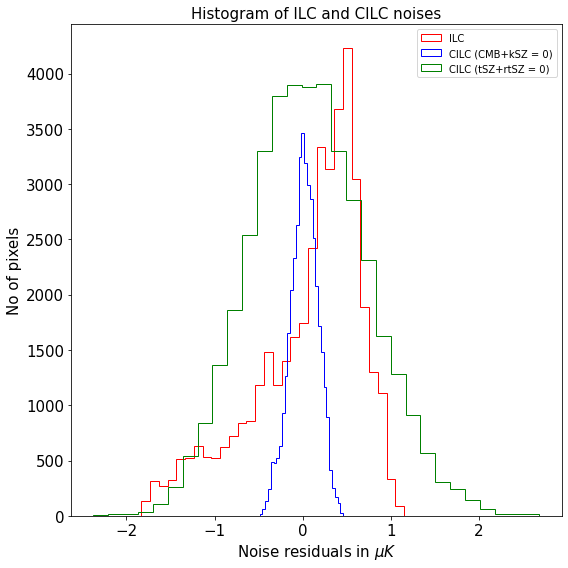

In [109]:
######################## Stacked #########################################

fig = plt.figure(figsize=(8,8))
ax = plt.gca()



plt.hist(ilc_error_noises_stacked_rksz.ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_stacked_rksz_1.ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC (CMB+kSZ = 0)')
plt.hist(cilc_error_noises_stacked_filtered_rksz_2.ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC (tSZ+rtSZ = 0)')

plt.title("Histogram of ILC and CILC noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()
plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/hist_rksz_errors.png", dpi =150)

print(np.std(cilc_error_noises_stacked_filtered_rksz_2), np.std(cilc_error_noises_stacked_rksz_1), np.std(ilc_error_noises_stacked_rksz) )


sigma CILC: tSZ+rtSZ--> 0 = 0.6389179416515831 

sigma CILC: CMB+kSZ--> 0 = 0.1570622615503706 

sigma ILC = 0.1473783177869218 



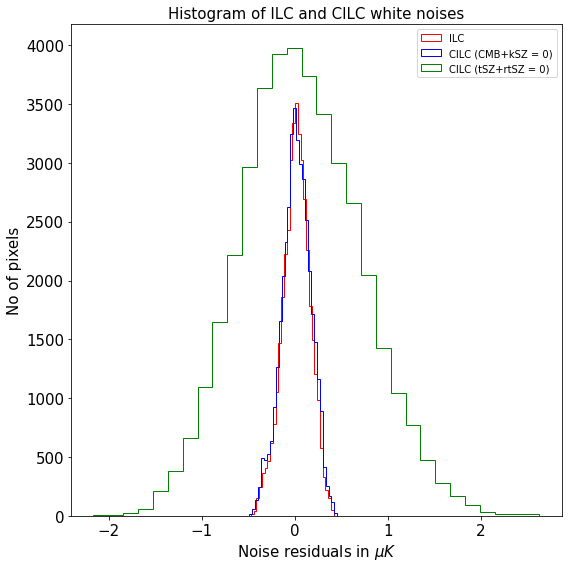

In [265]:

############################ ILC error noises = weight * instrumental ###########################


ilc_error_noises_rksz_instrumental_only =  ilc_error_noises_instrumental_rksz

ilc_error_noises_stacked_rksz_instrumental_only = np.sum(ilc_error_noises_rksz_instrumental_only, axis = 0)/len(red_shifts)


############################ CILC error noises 1 = weights * instrumental noise ###########################


cilc_error_noises_stacked_rksz_1 = np.sum(cilc_error_noises_rksz_1, axis = 0)/len(red_shifts)


########################### CILC error noises 2 = weights * (CMB + instrumental) ####################################

cilc_error_noises_filtered_rksz_instrumental_only_2 = cilc_error_noises_intrumental_filtered_rksz_2 

cilc_error_noises_stacked_filtered_rksz_instrumental_only_2 = np.sum(cilc_error_noises_filtered_rksz_instrumental_only_2, axis = 0)/len(red_shifts)


######################## Stacked #########################################

fig = plt.figure(figsize=(8,8))
ax = plt.gca()





plt.hist(ilc_error_noises_stacked_rksz_instrumental_only.ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_stacked_rksz_1.ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC (CMB+kSZ = 0)')
plt.hist(cilc_error_noises_stacked_filtered_rksz_instrumental_only_2.ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC (tSZ+rtSZ = 0)')

plt.title("Histogram of ILC and CILC white noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/hist_tksz_errors.png", dpi =150)


print("sigma CILC: tSZ+rtSZ--> 0 =",np.std(cilc_error_noises_stacked_filtered_rksz_instrumental_only_2), '\n')
print("sigma CILC: CMB+kSZ--> 0 =",np.std(cilc_error_noises_stacked_rksz_1), '\n')
print("sigma ILC =",np.std(ilc_error_noises_stacked_rksz_instrumental_only), '\n')




sigma CILC: tSZ+rtSZ--> 0 = 7.1429012948371975 

sigma CILC: CMB+kSZ--> 0 = 6.10662170691702 

sigma ILC = 6.083782475632201 



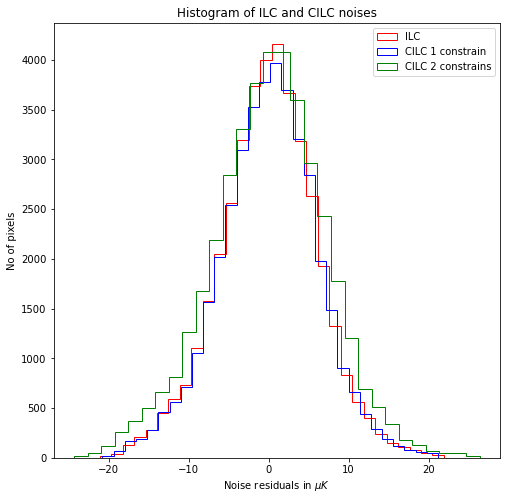

In [266]:
######################## Single cluster #########################################


plt.gcf().set_size_inches(8,8)



plt.hist(ilc_error_noises_rksz[498].ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_rksz_1[498].ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC 1 constrain')
plt.hist(cilc_error_noises_filtered_rksz_2[498].ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC 2 constrains')

plt.title("Histogram of ILC and CILC noises")
plt.xlabel('Noise residuals in $\mu K$')
plt.ylabel("No of pixels")
plt.legend()




print("sigma CILC: tSZ+rtSZ--> 0 =",np.std(cilc_error_noises_filtered_rksz_2[498]), '\n')
print("sigma CILC: CMB+kSZ--> 0 =",np.std(cilc_error_noises_rksz_1[498]), '\n')
print("sigma ILC =",np.std(ilc_error_noises_rksz[498]), '\n')



In [365]:

# ilc_weights_rksz_single = SZ.ilc_weights(all_signals_maps_smoothed[1] ,a_rksz)


# ilc_noises_rksz_signalssss = SZ.ilc_noise_all_signals(cmb_ksz_maps_smoothed[1], np.zeros((4,200,200)), np.zeros((4,200,200)), np.zeros((4,200,200)), ilc_weights_rksz_single, nu_cmbs4)

# ilc_noises_rksz_instrumentalsss = SZ.ilc_noise(ilc_weights_rksz_single, noise_maps_smoothed[1], nu_cmbs4)

# ilc_noises_rkszsss = ilc_noises_rksz_signalssss + ilc_noises_rksz_instrumentalsss

# print(np.std(ilc_noises_rkszsss))


In [112]:
# ############## Extracting v^2 tau signal #####################


# gilc_extracted_rksz = SZ.cilc_run_2(all_signal_maps_smoothed_stacked, A_rksz, e_rksz)/(1e6)

# SZ.plot_map_500(8,8,r"$v^2 \tau$",gilc_extracted_rksz,r"$v^2 \tau$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_rksz[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')


In [113]:
# ######################### pixel histogram of extracted gILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_gilc, bin_centres_rksz_gilc = hist_fit(gilc_extracted_rksz, 100)

# plt.title("Pixel histogram of extracted gILC")

# plt.hist(gilc_extracted_rksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_gilc, hist_fit_rksz_gilc, 'k')


In [114]:
# ####################  Noises in gILC map: sum ( cilc weights * tksz + tsz + noise) ################################


# gilc_noises_rksz = SZ.cilc_noise(tsz_clusters_maps_smoothed_stacked, tksz_clusters_maps_smoothed_stacked, np.zeros((4,200,200)), noise_maps_smoothed_stacked, gilc_weights_rksz, nu_cmbs4)


# #################### Check : Extracted gilc signal -  input signal == weight * cilc noises #########################  

# gilc_chk_rksz = gilc_extracted_rksz - input_rksz_maps_smoothed_stacked

# np.allclose(gilc_chk_rksz, gilc_noises_rksz/(1e6))



In [115]:

# SZ.plot_map_500(8,8,r"gILC residual",gilc_noises_rksz,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_gilc, bin_centres_res_rksz_gilc = hist_fit(gilc_noises_rksz, 100)

# plt.title("Pixel histogram of gILC residual")

# plt.hist(gilc_noises_rksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_rksz_gilc, hist_fit_res_rksz_gilc, 'k')


# $v\tau\theta_e$ tkSZ signal

### Using ILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{\text{iTKSZ}} = 1 $

In [116]:
################# Calculating ILC weights ###################


a_tksz = np.array(tksz_spec_cmbs4) * t_cmb

ilc_weights_tksz = SZ.ilc_weights(all_signal_maps_smoothed_stacked, a_tksz)

ilc_weights_tksz_filtered = SZ.ilc_weights(all_signal_maps_filtered_smoothed_stacked, a_tksz)



weights = [ 0.1688385  -0.23061658  0.02040781  0.04105858] 

sum weights X a = 0.9999999999999996 

weights = [ 0.16914745 -0.23146529  0.02122528  0.0405515 ] 

sum weights X a = 0.9999999999999998 



In [117]:
# ################# Extracting v tau theta_e signal ########################


# ilc_extracted_tksz = SZ.ilc_run(all_signal_maps_smoothed_stacked, a_tksz, factor=1e6*mu)

# SZ.plot_map_500(8,8,r"$v\tau\theta_e$ ",ilc_extracted_tksz,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(ilc_extracted_tksz[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()



# ilc_extracted_tksz_filtered = SZ.ilc_run(all_signal_maps_filtered_smoothed_stacked, a_tksz, factor=1e6*mu)

# SZ.plot_map_500(8,8,r"$v\tau\theta_e$ filtered ",ilc_extracted_tksz_filtered,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(ilc_extracted_tksz_filtered[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# #############################################################################################################################################################



# ilc_extracted_tksz_only = SZ.ilc_run(all_signal_maps_only_tksz_smoothed_stacked ,a_tksz ,factor=1e6*mu)

# SZ.plot_map_500(8,8,r"$v\tau\theta_e$ extracted from tksz + cmb + noise ",ilc_extracted_tksz_only,r"$v\tau\theta_e$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_tksz_only[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# ilc_extracted_tksz_only_filtered = SZ.ilc_run(all_signal_maps_only_tksz_filtered_smoothed_stacked ,a_tksz ,factor=1e6*mu)


# SZ.plot_map_500(8,8,r"$v\tau\theta_e$ extracted tksz + cmb + noise ",ilc_extracted_tksz_only_filtered,r"$v\tau\theta_e$", 200,0)
# plt.show()

# plt.plot(ilc_extracted_tksz_only_filtered[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [118]:
# ######################### pixel histogram of extracted ILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_tksz_ilc, bin_centres_tksz_ilc = hist_fit(ilc_extracted_tksz, 100)

# plt.title("Pixel histogram of extracted CILC ")

# plt.hist(ilc_extracted_tksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_ilc, hist_fit_tksz_ilc, 'k')



In [119]:
# ####################  Noises in ILC map: sum ( ilc weights * CMB+kSZ + tsz + rksz + rtsz + noise) ################################


# ilc_noises_tksz_signals = SZ.ilc_noise_all_signals(cmb_ksz_maps_smoothed_stacked, tsz_clusters_maps_smoothed_stacked, rksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, ilc_weights_tksz, nu_cmbs4)

# ilc_noises_tksz_instrumental = SZ.ilc_noise(ilc_weights_tksz, noise_maps_smoothed_stacked, nu_cmbs4)

# ilc_noises_tksz = ilc_noises_tksz_signals + ilc_noises_tksz_instrumental



# #################### Check : Extracted ilc signal -  input signal == weight * noises #########################


# ilc_chk_tksz  = ilc_extracted_tksz - input_tksz_maps_smoothed_stacked

# np.allclose(ilc_chk_tksz, ilc_noises_tksz/(1e6*mu))



In [120]:

# SZ.plot_map_500(8,8,r"ILC residual",ilc_noises_rksz,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual ILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_ilc, bin_centres_res_tksz_ilc = hist_fit(ilc_noises_tksz, 100)

# plt.title("Pixel histogram of ILC residual")

# plt.hist(ilc_noises_tksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_ilc, hist_fit_res_tksz_ilc, 'k')


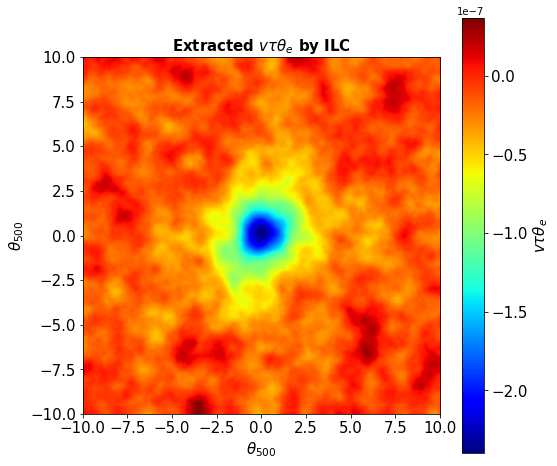

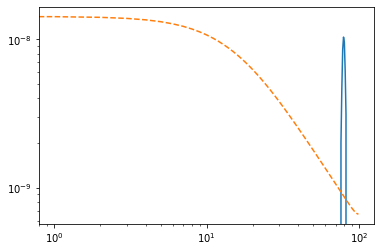

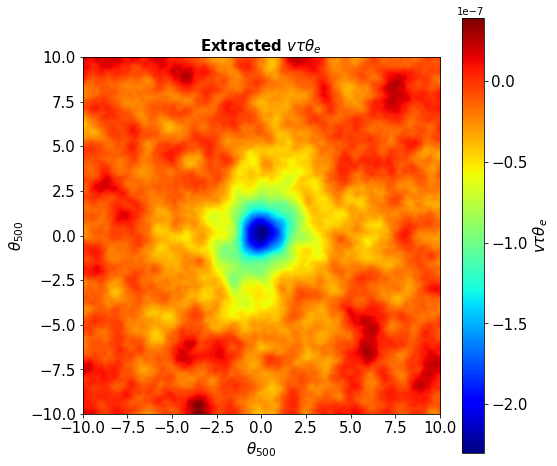

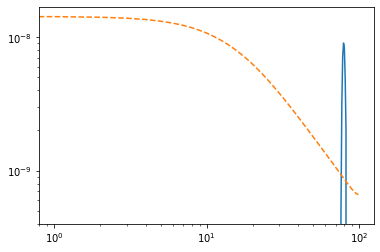

In [121]:

######################### Running ILC on individual clusters ###################################


ilc_weights_each_tksz = ilc_each_cluster_weight(all_signals_maps_smoothed, a_tksz, red_shifts)

ilc_weights_each_filtered_tksz = ilc_each_cluster_weight(all_signals_maps_filtered_smoothed, a_tksz, red_shifts)


ilc_extracted_each_tksz = ilc_run_each_cluster(all_signals_maps_smoothed, a_tksz, red_shifts, (1e6*mu), offset = False)  


ilc_extracted_each_stacked_tksz = np.sum(ilc_extracted_each_tksz, axis = 0)/len(red_shifts)




#########################################################################################




SZ.plot_map_500(8,8,r"Extracted $v \tau \theta_e$ by ILC",ilc_extracted_each_stacked_tksz,r"$v\tau\theta_e$", 200,0)
plt.show()


plt.plot(ilc_extracted_each_stacked_tksz[100,100:])
plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()




ilc_extracted_each_filtered_tksz = ilc_run_each_cluster(all_signals_maps_filtered_smoothed, a_tksz, red_shifts, (1e6*mu), offset = False)  


ilc_extracted_each_stacked_filtered_tksz = np.sum(ilc_extracted_each_filtered_tksz, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v \tau\theta_e$",ilc_extracted_each_stacked_filtered_tksz,r"$v\tau\theta_e$", 200,0)
plt.show()


plt.plot(ilc_extracted_each_stacked_filtered_tksz[100,100:])
plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')



In [122]:
# ########################## 1000 clusters ##########################################


# ilc_weights_each_tksz_1k = ilc_each_cluster_weight(all_signals_maps_smoothed_1k, a_tksz, red_shifts_1k)

# ilc_weights_each_filtered_tksz_1k = ilc_each_cluster_weight(all_signals_maps_filtered_smoothed_1k, a_tksz, red_shifts_1k)


# ilc_extracted_each_tksz_1k = ilc_run_each_cluster(all_signals_maps_smoothed_1k, a_tksz, red_shifts_1k, 1e6*mu, offset = True)  


# ilc_extracted_each_stacked_tksz_1k = np.sum(ilc_extracted_each_tksz_1k, axis = 0)/len(red_shifts_1k)


# #########################################################################################




# SZ.plot_map_500(8,8,r"Extracted $v \tau \theta_e$ by ILC",ilc_extracted_each_stacked_tksz_1k,r"$v\tau\theta_e$", 200,0)
# #plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_ilc.png", dpi =150)
# plt.show()


# plt.plot(ilc_extracted_each_stacked_tksz[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked_1k[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()




# ilc_extracted_each_filtered_tksz_1k = ilc_run_each_cluster(all_signals_maps_filtered_smoothed_1k, a_tksz, red_shifts_1k, 1e6*mu, offset = True)  


# ilc_extracted_each_stacked_filtered_tksz_1k = np.sum(ilc_extracted_each_filtered_tksz_1k, axis = 0)/len(red_shifts_1k)




# SZ.plot_map_500(8,8,r"Extracted $v \tau\theta_e$",ilc_extracted_each_stacked_filtered_tksz_1k,r"$v\tau\theta_e$", 200,0)
# plt.show()


# plt.plot(ilc_extracted_each_stacked_filtered_tksz_1k[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked_1k[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')


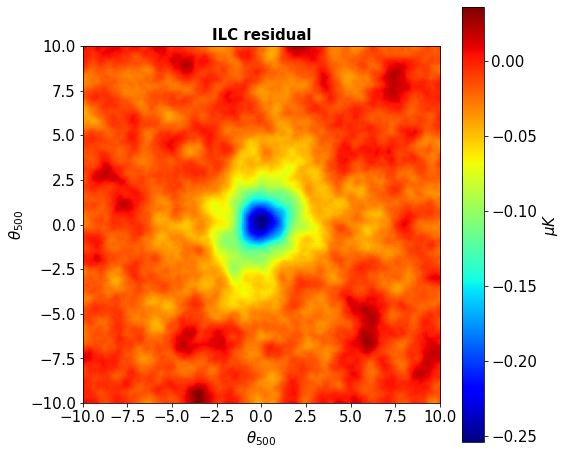

True


In [367]:
############################ ILC residual #########################

ilc_residual_tksz = ilc_extracted_each_stacked_tksz - input_tksz_maps_smoothed_stacked           # no unit


SZ.plot_map_500(8,8,r"ILC residual",ilc_residual_tksz*1e6,r"$\mu K$", 200,0)
plt.show()



########################## ILC residual =  weight * (tSZ + rksz + rtSZ + instrumental noise) ############################################



ilc_signals_noises_each_tksz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, tsz_clusters_maps_smoothed, rksz_clusters_maps_smoothed, rtsz_clusters_maps_smoothed, ilc_weights_each_tksz, nu_cmbs4)

ilc_signals_instrumental_noises_each_tksz = ilc_noise_each(red_shifts, ilc_weights_each_tksz, noise_maps_smoothed, nu_cmbs4)

ilc_noises_each_tksz = ilc_signals_noises_each_tksz + ilc_signals_instrumental_noises_each_tksz

ilc_noises_each_stacked_tksz = np.sum(ilc_noises_each_tksz, axis = 0)/len(red_shifts)


#SZ.plot_map_500(8,8,r"ILC residual",ilc_noises_each_stacked_tksz,r"$\mu K$", 200,0)

#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_res_ilc.png", dpi =150)

plt.show()

print(np.allclose(ilc_residual_tksz,ilc_noises_each_stacked_tksz/(1e6*mu) ))



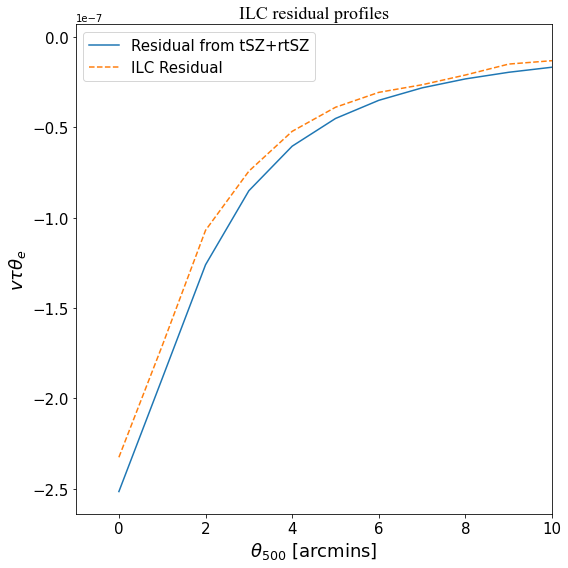

In [366]:
####################### Checking main contribution comes from tSZ+rtSZ #########################

ilc_signals_noises_maj_contribution_tksz = ilc_signals_each(red_shifts, np.zeros((500,200,200)), tsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), rtsz_clusters_maps_smoothed, ilc_weights_each_tksz, nu_cmbs4)

ilc_signals_noises_maj_contribution_stacked_tksz = np.sum(ilc_signals_noises_maj_contribution_tksz, axis = 0)/len(red_shifts)


# SZ.plot_map_500(8,8,r"ILC residual",ilc_signals_noises_maj_contribution_stacked_tksz/1e6,r"$v\tau\theta_e$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_res_main_ilc.png", dpi =150)
# plt.show()



#################################### Matching profiles #########################################


plt.plot(SZ.radial_profile(ilc_signals_noises_maj_contribution_stacked_tksz/(1e6*mu), 20, 0.25), label = 'Residual from tSZ+rtSZ')
plt.plot(SZ.radial_profile(ilc_residual_tksz, 20, 0.25),'--', label = 'ILC Residual')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v \tau\theta_e$", fontsize=18)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=18)
plt.title("ILC residual profiles", fontsize=18, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.show()


In [364]:
# ######################### pixel histogram of extracted ILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_each_tksz_ilc, bin_centres_each_tksz_ilc = hist_fit(ilc_extracted_each_stacked_tksz, 100)

# plt.hist(ilc_extracted_each_stacked_tksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_each_tksz_ilc, hist_fit_each_tksz_ilc, 'k')


In [126]:
# for i in range(len(red_shifts)):
    
#     ccv = ilc_extracted_tksz_each[i]
#     SZ.plot_map_500(8,8,r"Extracted $v \tau \theta_e$",ccv,r"$v\tau\theta_e$", 200,0)
#     plt.show()


#     plt.plot(ccv[100,100:])
#     plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()

    

## Using cILC on all signals + noise maps, each map smoothed to 2.2' and stacked 
### $w_i a_{iTKSZ} = 1 $ and $w_i a_{i CMB+KSZ} = 0 $


In [127]:
######### CILC weights ################

cilc_weights_tksz_1 = SZ.cilc_weights_1(all_signal_maps_smoothed_stacked, a_tksz ,a_ksz)


Weights =  [ 0.16949233 -0.2315554   0.02089643  0.04116665]
sum weights X a = 0.9999999999999996 

sum weights X b = 1.3877787807814457e-17 



In [128]:
# ######### Extracting v tau theta_e signal #########


# cilc_extracted_tksz_1 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked ,a_tksz ,a_ksz)/(1e6*mu)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$",cilc_extracted_tksz_1,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(cilc_extracted_tksz_1[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')


In [129]:
# ######################### pixel histogram of extracted CILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# plt.title("Pixel histogram of extracted CILC ")

# hist_fit_tksz_cilc_1, bin_centres_tksz_cilc_1 = hist_fit(cilc_extracted_tksz_1, 100)

# plt.hist(cilc_extracted_tksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_cilc_1, hist_fit_tksz_cilc_1, 'k')



In [130]:
# ####################  Noises in CILC map: sum ( cilc weights * tsz + rksz + rtsz + noise) ################################


# cilc_noises_tksz_1 = SZ.cilc_noise(tsz_clusters_maps_smoothed_stacked, rksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked , noise_maps_smoothed_stacked, cilc_weights_tksz_1, nu_cmbs4)



# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_tksz_1 = cilc_extracted_tksz_1 - input_tksz_maps_smoothed_stacked

# np.allclose(cilc_chk_tksz_1, cilc_noises_tksz_1/(1e6*mu))


In [131]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_tksz_1,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_cilc_1, bin_centres_res_tksz_cilc_1 = hist_fit(cilc_noises_tksz_1, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_tksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_cilc_1, hist_fit_res_tksz_cilc_1, 'k')


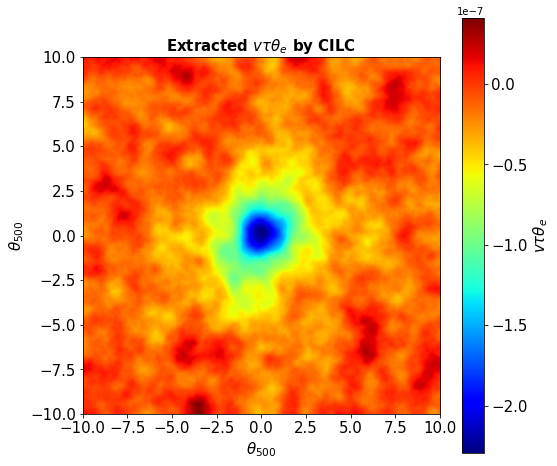

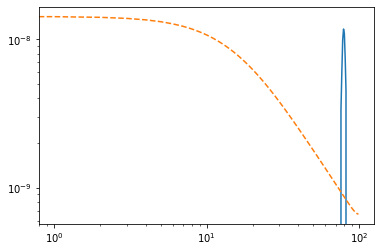

In [132]:
######################### Running CILC on individual clusters ###################################


cilc_weights_each_tksz_1 = cilc_weight_each(all_signals_maps_smoothed, a_tksz, a_ksz, red_shifts)



cilc_extracted_each_tksz_1 = cilc_run_each_cluster(all_signals_maps_smoothed, a_tksz, a_ksz, red_shifts, (1e6*mu), offset = False)  


cilc_extracted_each_stacked_tksz_1 = np.sum(cilc_extracted_each_tksz_1, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v\tau\theta_e$ by CILC",cilc_extracted_each_stacked_tksz_1,r"$v\tau\theta_e$", 200,0)
plt.show()


plt.plot(cilc_extracted_each_stacked_tksz_1[100,100:])
plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



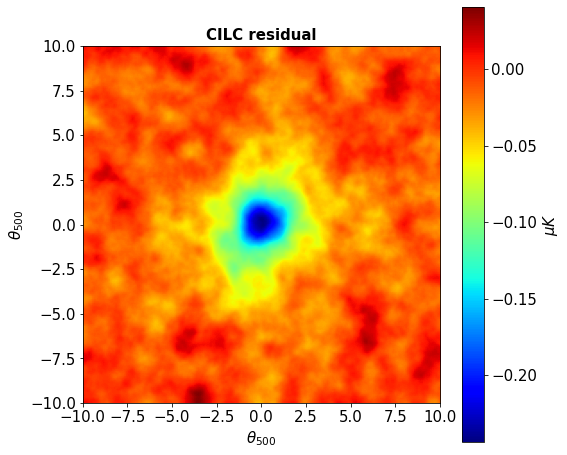

True


In [363]:
############################ CILC residual #########################

cilc_residual_tksz_1 = cilc_extracted_each_stacked_tksz_1 - input_tksz_maps_smoothed_stacked           # no unit

SZ.plot_map_500(8,8,r"CILC residual",cilc_residual_tksz_1*1e6,r"$\mu K$", 200,0)

plt.show()



##################################  CILC residuals #########################################


cilc_noises_each_tksz_1 = cilc_each_noise(red_shifts, tsz_clusters_maps_smoothed, rksz_clusters_maps_smoothed, rtsz_clusters_maps_smoothed, noise_maps_smoothed, cilc_weights_each_tksz_1, nu_cmbs4)

cilc_noises_each_stacked_tksz_1 = np.sum(cilc_noises_each_tksz_1, axis = 0)/len(red_shifts)


################################### Check: CILC residual == weight * tsz + rksz + rtsz + wn ###################################


print(np.allclose(cilc_residual_tksz_1, cilc_noises_each_stacked_tksz_1/(1e6*mu)))


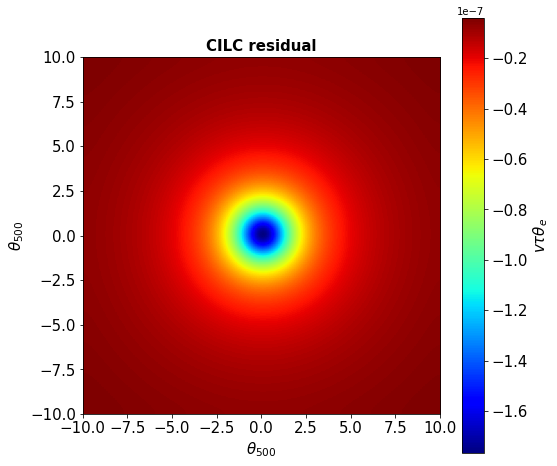

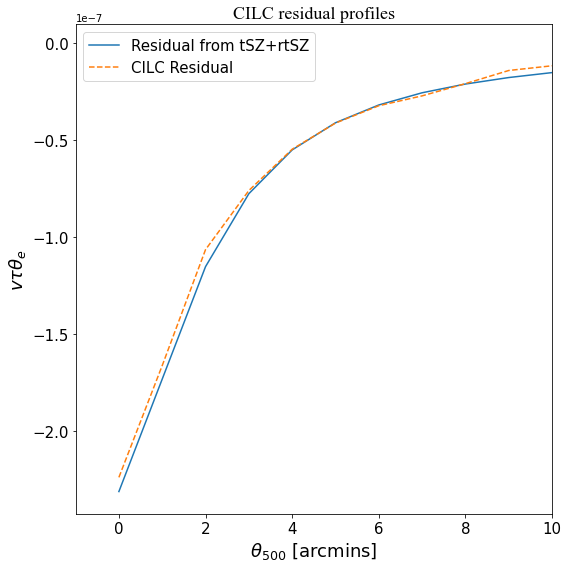

In [210]:
####################### Checking main contribution comes from tSZ+rtSZ #########################


cilc_signals_noises_maj_contribution_tksz = cilc_each_noise(red_shifts, tsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), rtsz_clusters_maps_smoothed, np.zeros((500,4,200,200)), cilc_weights_each_tksz_1, nu_cmbs4)

cilc_signals_noises_maj_contribution_stacked_tksz = np.sum(cilc_signals_noises_maj_contribution_tksz, axis = 0)/len(red_shifts)


SZ.plot_map_500(8,8,r"CILC residual",cilc_signals_noises_maj_contribution_stacked_tksz/1e6,r"$v\tau\theta_e$", 200,0)
plt.show()


#################################### Matching profiles #########################################


plt.plot(SZ.radial_profile(cilc_signals_noises_maj_contribution_stacked_tksz/(1e6*mu), 20, 0.25), label = 'Residual from tSZ+rtSZ')
plt.plot(SZ.radial_profile(cilc_residual_tksz_1, 20, 0.25),'--', label = 'CILC Residual')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v \tau\theta_e$", fontsize=18)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=18)
plt.title("CILC residual profiles", fontsize=18, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.show()


In [362]:
# ######################### pixel histogram of extracted CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_each_tksz_cilc, bin_centres_each_tksz_cilc = hist_fit(cilc_extracted_each_stacked_tksz_1, 100)

# plt.hist(cilc_extracted_each_stacked_tksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_each_tksz_cilc, hist_fit_each_tksz_ilc, 'k')


### $w_i a_{iTKSZ} = 1 $ and $w_i a_{iTSZ} + w_i a_{iRTSZ}  = 0 $

In [136]:
#################### CILC weights #######################

cilc_weights_each_tksz_2 = cilc_weight_each_bcorr(all_signals_maps_smoothed, a_tksz, a_tsz_rtsz, red_shifts)

cilc_weights_each_filtered_tksz_2 = cilc_weight_each_bcorr(all_signals_maps_filtered_smoothed, a_tksz, a_tsz_rtsz, red_shifts)



In [137]:
# #################### Extracting v^2 tau signal #######################


# cilc_extracted_rksz_2 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked, a_rksz, a_tsz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$",cilc_extracted_rksz_2,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_2[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()




# cilc_extracted_rksz_filtered_2 = SZ.cilc_run_1(all_signal_maps_filtered_smoothed_stacked, a_rksz, a_tsz)/1e6

# SZ.plot_map_500(8,8,r"$v^2 \tau$ filtered",cilc_extracted_rksz_filtered_2,r"$v^2 \tau$", 200, 0.50)
# plt.show()


# plt.plot(cilc_extracted_rksz_filtered_2[100,100:])
# plt.plot(input_rksz_maps_smoothed_stacked[100,100:])
# plt.xscale('log')
# plt.yscale('log')


In [138]:

# plt.gcf().set_size_inches(8,8)

# hist_fit_rksz_cilc_2, bin_centres_rksz_cilc_2 = hist_fit(cilc_extracted_rksz_2, 100)

# plt.title("Pixel histogram of extracted CILC")

# plt.hist(cilc_extracted_rksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_rksz_cilc_2, hist_fit_rksz_cilc_2, 'k')


In [139]:
# ####################  Noises in CILC map: sum ( ilc weights * CMB+kSZ + tksz + rtsz + noise) ################################

# cilc_noises_rksz_signals_1 = SZ.cilc_noise(np.zeros((4,200,200)), tksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, noise_maps_smoothed_stacked, cilc_weights_rksz_2, nu_cmbs4)

# cilc_noises_rksz_cmb_1 = SZ.cilc_cmb(cilc_weights_rksz_2, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# cilc_noises_rksz_2 = cilc_noises_rksz_signals_1 + cilc_noises_rksz_cmb_1



# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_rksz_2 = cilc_extracted_rksz_2 - input_rksz_maps_smoothed_stacked

# np.allclose(cilc_chk_rksz_2, cilc_noises_rksz_2/(1e6))


In [140]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_rksz_2,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_rksz_cilc_2, bin_centres_res_rksz_cilc_2 = hist_fit(cilc_noises_rksz_2, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_rksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_rksz_cilc_2, hist_fit_res_rksz_cilc_2, 'k')


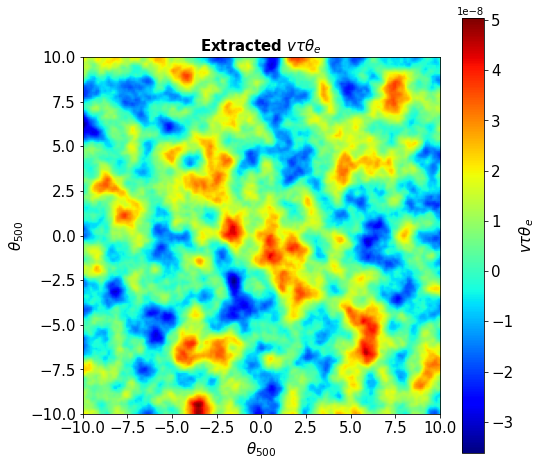

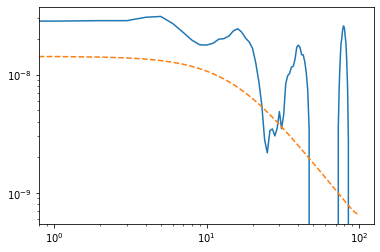

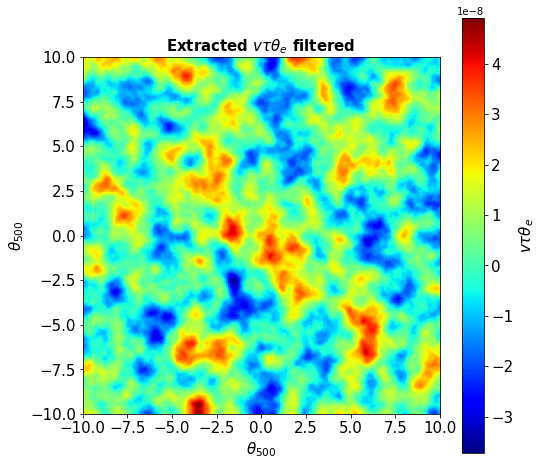

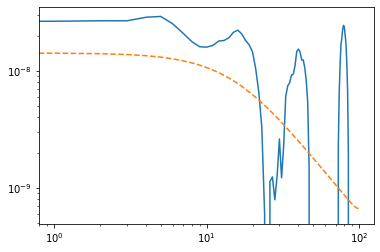

In [294]:
######################### Running CILC on individual clusters ###################################


cilc_extracted_each_tksz_2 = cilc_run_each_cluster_bcorr(all_signals_maps_smoothed, a_tksz, a_tsz_rtsz, red_shifts, (mu*1e6), offset = False)  


cilc_extracted_each_stacked_tksz_2 = np.sum(cilc_extracted_each_tksz_2, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v \tau \theta_e$",cilc_extracted_each_stacked_tksz_2,r"$v\tau\theta_e$", 200,0)
plt.show()


plt.plot(cilc_extracted_each_stacked_tksz_2[100,100:])
plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



########################### On filtered CMB ############################################


cilc_extracted_each_filtered_tksz_2 = cilc_run_each_cluster_bcorr(all_signals_maps_filtered_smoothed, a_tksz, a_tsz_rtsz, red_shifts, (mu*1e6), offset = False)  


cilc_extracted_each_filtered_stacked_tksz_2 = np.sum(cilc_extracted_each_filtered_tksz_2, axis = 0)/len(red_shifts)




SZ.plot_map_500(8,8,r"Extracted $v \tau \theta_e$ filtered ",cilc_extracted_each_filtered_stacked_tksz_2,r"$v\tau\theta_e$", 200,0)
plt.show()


plt.plot(cilc_extracted_each_filtered_stacked_tksz_2[100,100:])
plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
plt.xscale('log')
plt.yscale('log')
plt.show()



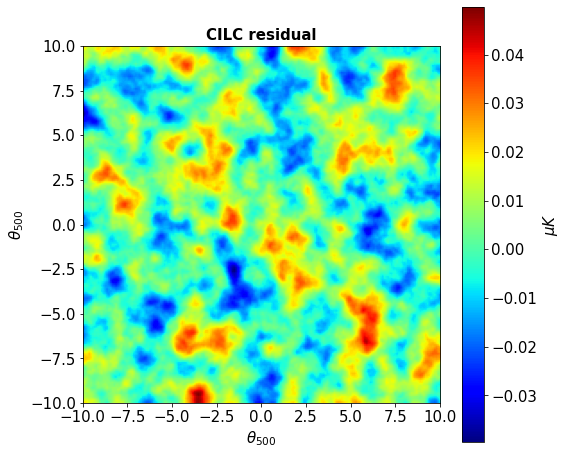

True


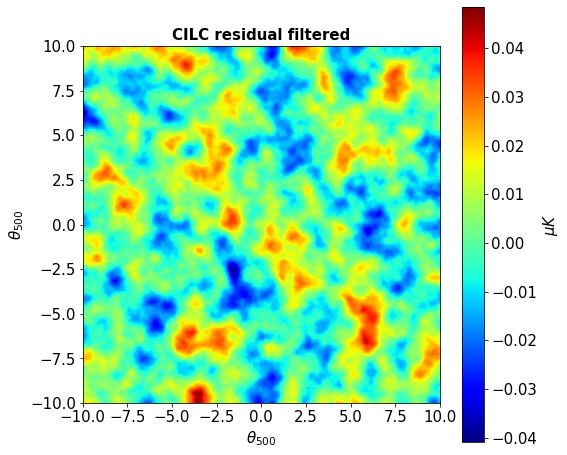

True


In [142]:
############################ CILC residual = Extracted CILC - input signal  #########################



cilc_residual_tksz_2 = cilc_extracted_each_stacked_tksz_2 - input_tksz_maps_smoothed_stacked           # no unit


SZ.plot_map_500(8,8,r"CILC residual",cilc_residual_tksz_2*1e6,r"$\mu K$", 200,0)
plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_res_cilc_2.png", dpi =150)
plt.show()


############################ CILC noises = weight * CMB+kSZ + rkSZ + noise  #########################


cilc_signal_noises_each_tksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), rksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_tksz_2, nu_cmbs4)

cilc_cmb_noises_each_tksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_tksz_2, cmb_ksz_maps_smoothed, nu_cmbs4 )

cilc_noises_each_tksz_2 = cilc_signal_noises_each_tksz_2 + cilc_cmb_noises_each_tksz_2

cilc_noises_each_stacked_tksz_2 = np.sum(cilc_noises_each_tksz_2, axis = 0)/len(red_shifts)




########################## Check:  CILC residual == CILC noises ####################################



print(np.allclose(cilc_residual_tksz_2, cilc_noises_each_stacked_tksz_2/(mu*1e6) ))





############################ filtered ##############################


cilc_residual_filtered_tksz_2 = cilc_extracted_each_filtered_stacked_tksz_2 - input_tksz_maps_smoothed_stacked           # no unit



SZ.plot_map_500(8,8,r"CILC residual filtered",cilc_residual_filtered_tksz_2*1e6,r"$\mu K$", 200,0)
plt.show()




cilc_signal_noises_each_filtered_tksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), rksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_filtered_tksz_2, nu_cmbs4)

cilc_cmb_noises_each_filtered_tksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_filtered_tksz_2, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

cilc_noises_each_filtered_tksz_2 = cilc_signal_noises_each_filtered_tksz_2 + cilc_cmb_noises_each_filtered_tksz_2

cilc_noises_each_filtered_stacked_tksz_2 = np.sum(cilc_noises_each_filtered_tksz_2, axis = 0)/len(red_shifts)



print(np.allclose(cilc_residual_filtered_tksz_2, cilc_noises_each_filtered_stacked_tksz_2/(1e6*mu) ))



In [143]:
# ################ Extracting v tau theta_e signal #####################


# cilc_extracted_tksz_2 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked ,a_tksz ,a_tsz)/(1e6*mu)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$",cilc_extracted_tksz_2,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(cilc_extracted_tksz_2[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()



# cilc_extracted_tksz_filtered_2 = SZ.cilc_run_1(all_signal_maps_filtered_smoothed_stacked ,a_tksz ,a_tsz)/(1e6*mu)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$ filtered",cilc_extracted_tksz_filtered_2,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(cilc_extracted_tksz_filtered_2[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')


In [144]:
# ######################### pixel histogram of extracted CILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# plt.title("Pixel histogram of extracted CILC ")

# hist_fit_tksz_cilc_2, bin_centres_tksz_cilc_2 = hist_fit(cilc_extracted_tksz_2, 100)

# plt.hist(cilc_extracted_tksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_cilc_2, hist_fit_tksz_cilc_2, 'k')


In [145]:
# ####################  Noises in ILC map: sum ( cilc weights * CMB+kSZ + rksz + rtsz + noise) ################################


# cilc_noises_tksz_signals_1 = SZ.cilc_noise(np.zeros((4,200,200)), rksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, noise_maps_smoothed_stacked, cilc_weights_tksz_2, nu_cmbs4)

# cilc_noises_tksz_cmb_1 = SZ.cilc_cmb(cilc_weights_tksz_2, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# cilc_noises_tksz_2 = cilc_noises_tksz_signals_1 + cilc_noises_tksz_cmb_1



# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 


# cilc_chk_tksz_2 = cilc_extracted_tksz_2 - input_tksz_maps_smoothed_stacked

# np.allclose(cilc_chk_tksz_2, cilc_noises_tksz_2/(1e6*mu))


In [146]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_tksz_2,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_cilc_2, bin_centres_res_tksz_cilc_2 = hist_fit(cilc_noises_tksz_2, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_tksz_2.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_cilc_2, hist_fit_res_tksz_cilc_2, 'k')


In [147]:
# ################ Extracting v tau theta_e signal ################

# cilc_extracted_tksz_3 = SZ.cilc_run_1(all_signal_maps_smoothed_stacked ,a_tksz ,a_rtsz)/(1e6*mu)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$",cilc_extracted_tksz_3,r"$v\tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(cilc_extracted_tksz_3[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')


In [148]:
# ######################### pixel histogram of extracted CILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# plt.title("Pixel histogram of extracted CILC ")

# hist_fit_tksz_cilc_3, bin_centres_tksz_cilc_3 = hist_fit(cilc_extracted_tksz_3, 100)

# plt.hist(cilc_extracted_tksz_3.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_cilc_3, hist_fit_tksz_cilc_3, 'k')



In [149]:
# ####################  Noises in CILC map: sum ( cilc weights * CMB+kSZ + rksz + tsz + noise) ################################

# cilc_noises_tksz_signals_2 = SZ.cilc_noise(tsz_clusters_maps_smoothed_stacked, rksz_clusters_maps_smoothed_stacked,np.zeros((4,200,200)), noise_maps_smoothed_stacked, cilc_weights_tksz_3, nu_cmbs4)

# cilc_noises_tksz_cmb_2 = SZ.cilc_cmb(cilc_weights_tksz_3, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# cilc_noises_tksz_3 = cilc_noises_tksz_signals_2 + cilc_noises_tksz_cmb_2


# #################### Check : Extracted cilc signal -  input signal == weight * cilc noises ######################### 

# cilc_chk_tksz_3 = cilc_extracted_tksz_3 - input_tksz_maps_smoothed_stacked

# np.allclose(cilc_chk_tksz_3, cilc_noises_tksz_3/(1e6*mu))


In [150]:

# SZ.plot_map_500(8,8,r"CILC residual",cilc_noises_tksz_3,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_cilc_3, bin_centres_res_tksz_cilc_3 = hist_fit(cilc_noises_tksz_3, 100)

# plt.title("Pixel histogram of CILC residual")

# plt.hist(cilc_noises_tksz_3.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_cilc_3, hist_fit_res_tksz_cilc_3, 'k')


## Contraining 2 parameters

### $w_i a_{iTKSZ} = 1 $ and $w_i a_{iKSZ} = 0,  w_i a_{iTSZ} = 0$

In [361]:
# ############# Calculating gILC weights #################

# A_tksz = np.array([a_tksz, a_ksz, a_tsz])

# e_tksz = np.array([1,0,0]) 

# gilc_weights_tksz = SZ.cilc_weights_2(all_signal_maps_smoothed_stacked, A_tksz, e_tksz)


In [152]:
# ############# Extracting v tau theta_e signal #############


# gilc_extracted_tksz = SZ.cilc_run_2(all_signal_maps_smoothed_stacked, A_tksz, e_tksz)/(mu*1e6)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$",gilc_extracted_tksz,r"$v \tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_tksz[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')


In [153]:
# ######################### pixel histogram of extracted gILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# hist_fit_tksz_gilc, bin_centres_tksz_gilc = hist_fit(gilc_extracted_tksz, 100)

# plt.title("Pixel histogram of extracted gILC")

# plt.hist(gilc_extracted_tksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_gilc, hist_fit_tksz_gilc, 'k')


In [154]:
# ####################  Noises in gILC map: sum ( cilc weights * CMB+kSZ + rksz + tsz + noise) ################################


# gilc_noises_tksz = SZ.cilc_noise(np.zeros((4,200,200)), rksz_clusters_maps_smoothed_stacked, rtsz_clusters_maps_smoothed_stacked, noise_maps_smoothed_stacked, gilc_weights_tksz, nu_cmbs4)


# #################### Check : Extracted gilc signal -  input signal == weight * cilc noises #########################  

# gilc_chk_tksz = gilc_extracted_tksz - input_tksz_maps_smoothed_stacked

# np.allclose(gilc_chk_tksz, gilc_noises_tksz/(1e6*mu))



In [155]:

# SZ.plot_map_500(8,8,r"gILC residual",gilc_noises_tksz,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_gilc, bin_centres_res_tksz_gilc = hist_fit(gilc_noises_tksz, 100)

# plt.title("Pixel histogram of gILC residual")

# plt.hist(gilc_noises_tksz.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_gilc, hist_fit_res_tksz_gilc, 'k')


### $w_i a_{iTKSZ} = 1 $ and $w_i a_{iTSZ} = 0,  w_i a_{iRTSZ} = 0$

In [360]:
# ############# Calculating gILC weights #################

# A_tksz_1 = np.array([a_tksz, a_tsz, a_rtsz])

# e_tksz_1 = np.array([1,0,0]) 

# gilc_weights_tksz_1 = SZ.cilc_weights_2(all_signal_maps_smoothed_stacked, A_tksz_1, e_tksz_1)

# gilc_weights_tksz_filtered_1 = SZ.cilc_weights_2(all_signal_maps_filtered_smoothed_stacked, A_tksz_1, e_tksz_1)


In [157]:
# ############# Extracting v tau theta_e signal #############


# gilc_extracted_tksz_1 = SZ.cilc_run_2(all_signal_maps_smoothed_stacked, A_tksz_1, e_tksz_1)/(mu*1e6)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$",gilc_extracted_tksz_1,r"$v \tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_tksz_1[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.show()



# gilc_extracted_tksz_filtered_1 = SZ.cilc_run_2(all_signal_maps_filtered_smoothed_stacked, A_tksz_1, e_tksz_1)/(mu*1e6)

# SZ.plot_map_500(8,8,r"$v \tau\theta_e$ filtered ",gilc_extracted_tksz_filtered_1,r"$v \tau\theta_e$", 200, 0.50)
# plt.show()

# plt.plot(gilc_extracted_tksz_filtered_1[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# # plt.xscale('log')
# # plt.yscale('log')


In [158]:
# ######################### pixel histogram of extracted gILC signal ##############################

# plt.gcf().set_size_inches(8,8)

# hist_fit_tksz_gilc_1, bin_centres_tksz_gilc_1 = hist_fit(gilc_extracted_tksz_1, 100)

# plt.title("Pixel histogram of extracted gILC")

# plt.hist(gilc_extracted_tksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_tksz_gilc_1, hist_fit_tksz_gilc_1, 'k')


In [159]:
# ####################  Noises in gILC map: sum ( gilc weights * CMB+kSZ + rksz + noise) ################################


# gilc_noises_tksz_signals_1 = SZ.cilc_noise(np.zeros((4,200,200)), rksz_clusters_maps_smoothed_stacked, np.zeros((4,200,200)), noise_maps_smoothed_stacked, gilc_weights_tksz_1, nu_cmbs4)

# gilc_noises_tksz_cmb_1 = SZ.cilc_cmb(gilc_weights_tksz_1, cmb_ksz_maps_smoothed_stacked, nu_cmbs4)

# gilc_noises_tksz_1 = gilc_noises_tksz_signals_1 + gilc_noises_tksz_cmb_1


# #################### Check : Extracted gilc signal -  input signal == weight * gilc noises #########################  

# gilc_chk_tksz_1 = gilc_extracted_tksz_1 - input_tksz_maps_smoothed_stacked

# np.allclose(gilc_chk_tksz_1, gilc_noises_tksz_1/(1e6*mu))



In [160]:

# SZ.plot_map_500(8,8,r"gILC residual",gilc_noises_tksz_1,r"$\mu K$", 200, 0)
# plt.show()

# ######################### pixel histogram of residual CILC signal ##############################


# plt.gcf().set_size_inches(8,8)

# hist_fit_res_tksz_gilc_1, bin_centres_res_tksz_gilc_1 = hist_fit(gilc_noises_tksz_1, 100)

# plt.title("Pixel histogram of gILC residual")

# plt.hist(gilc_noises_tksz_1.ravel(), bins=100, histtype ='step')

# plt.plot(bin_centres_res_tksz_gilc_1, hist_fit_res_tksz_gilc_1, 'k')


In [161]:
# ######################### Running gILC on individual clusters ###################################


# gilc_weights_each_tksz_1 = gilc_weight_each(all_signals_maps_smoothed, A_tksz_1, e_tksz_1, red_shifts)


# gilc_extracted_each_tksz_1 = gilc_run_each_cluster(all_signals_maps_smoothed, A_tksz_1, e_tksz_1, red_shifts, 1e6*mu, offset = True)  


# gilc_extracted_each_stacked_tksz_1 = np.sum(gilc_extracted_each_tksz_1, axis = 0)/len(red_shifts)




# SZ.plot_map_500(8,8,r"Extracted $v\tau\theta_e$ by gILC ",gilc_extracted_each_stacked_tksz_1,r"$v\tau\theta_e$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_stacked_tksz_1[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()




# gilc_weights_each_filtered_tksz_1 = gilc_weight_each(all_signals_maps_filtered_smoothed, A_tksz_1, e_tksz_1, red_shifts)

# gilc_extracted_each_filtered_tksz_1 = gilc_run_each_cluster(all_signals_maps_filtered_smoothed, A_tksz_1, e_tksz_1, red_shifts, 1e6*mu, offset = True)  


# gilc_extracted_each_filtered_stacked_tksz_1 = np.sum(gilc_extracted_each_filtered_tksz_1, axis = 0)/len(red_shifts)




# SZ.plot_map_500(8,8,r"Extracted $v\tau\theta_e$ by gILC filtered ",gilc_extracted_each_filtered_stacked_tksz_1,r"$v\tau\theta_e$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_filtered_stacked_tksz_1[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [162]:
# ######################### Running gILC on individual 1000 clusters ###################################


# gilc_weights_each_tksz_1_1k = gilc_weight_each(all_signals_maps_smoothed_1k, A_tksz_1, e_tksz_1, red_shifts_1k)


# gilc_extracted_each_tksz_1_1k = gilc_run_each_cluster(all_signals_maps_smoothed_1k, A_tksz_1, e_tksz_1, red_shifts_1k, 1e6*mu, offset = True)  


# gilc_extracted_each_stacked_tksz_1_1k = np.sum(gilc_extracted_each_tksz_1_1k, axis = 0)/len(red_shifts_1k)




# SZ.plot_map_500(8,8,r"Extracted $v\tau\theta_e$ 1000 by CILC ",gilc_extracted_each_stacked_tksz_1_1k,r"$v\tau\theta_e$", 200,0)
# #plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_stacked_tksz_1_1k[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked_1k[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()




# gilc_weights_each_filtered_tksz_1_1k = gilc_weight_each(all_signals_maps_filtered_smoothed_1k, A_tksz_1, e_tksz_1, red_shifts_1k)

# gilc_extracted_each_filtered_tksz_1_1k = gilc_run_each_cluster(all_signals_maps_filtered_smoothed_1k, A_tksz_1, e_tksz_1, red_shifts_1k, 1e6*mu, offset = True)  


# gilc_extracted_each_filtered_stacked_tksz_1_1k = np.sum(gilc_extracted_each_filtered_tksz_1_1k, axis = 0)/len(red_shifts_1k)




# SZ.plot_map_500(8,8,r"Extracted $v\tau\theta_e$ 1000 by gILC filtered ",gilc_extracted_each_filtered_stacked_tksz_1_1k,r"$v\tau\theta_e$", 200,0)
# #plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_gilc.png", dpi =150)
# plt.show()


# plt.plot(gilc_extracted_each_filtered_stacked_tksz_1_1k[100,100:])
# plt.plot(input_tksz_maps_smoothed_stacked_1k[100,100:],'--')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [163]:
# ############################ gILC residual #########################

# gilc_residual_tksz_1 = gilc_extracted_each_stacked_tksz_1 - input_tksz_maps_smoothed_stacked           # no unit

# SZ.plot_map_500(8,8,r"CILC residual",gilc_residual_tksz_1*1e6,r"$\mu K$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_res_gilc.png", dpi =150)
# plt.show()


# gilc_signal_noises_each_tksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), rksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_tksz_1, nu_cmbs4)

# gilc_cmb_noises_each_tksz_1 = cilc_each_cmb(red_shifts, gilc_weights_each_tksz_1, cmb_ksz_maps_smoothed, nu_cmbs4 )



# gilc_residual_filtered_tksz_1 = gilc_extracted_each_filtered_stacked_tksz_1 - input_tksz_maps_smoothed_stacked           # no unit

# SZ.plot_map_500(8,8,r"CILC residual filtered",gilc_residual_filtered_tksz_1*1e6,r"$\mu K$", 200,0)
# plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_res_gilc.png", dpi =150)
# plt.show()



# ############################# gILC noises =  weight * CMB + rksz + noises ##########################################



# gilc_signal_noises_each_filtered_tksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), rksz_clusters_maps_smoothed, np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_filtered_tksz_1, nu_cmbs4)

# gilc_cmb_noises_each_filtered_tksz_1 = cilc_each_cmb(red_shifts, gilc_weights_each_filtered_tksz_1, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )



# ########################### gILC error noises = weight * CMB + noises ####################################


# gilc_error_noises_intrumental_filtered_tksz = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, gilc_weights_each_filtered_tksz_1, nu_cmbs4)

# gilc_error_noises_cmb_filtered_tksz = cilc_each_cmb(red_shifts, gilc_weights_each_filtered_tksz_1, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

# gilc_error_noises_filtered_tksz = gilc_error_noises_intrumental_filtered_tksz + gilc_error_noises_cmb_filtered_tksz

# gilc_error_noises_stacked_filtered_tksz = np.sum(gilc_error_noises_filtered_tksz, axis = 0)/len(red_shifts)





In [164]:
# plt.gcf().set_size_inches(8,8)



# plt.hist(ilc_error_noises_stacked_tksz.ravel(), bins=30, histtype ='step', color = 'red', label = 'ILC')
# plt.hist(cilc_error_noises_stacked_tksz.ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC 1 constrain')
# plt.hist(gilc_error_noises_stacked_filtered_tksz.ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC 2 constrains')

# plt.title("Histogram of ILC and CILC noises")
# plt.xlabel('Noise residuals in $\mu K$')
# plt.ylabel("No of pixels")
# plt.legend()

# print(np.std(gilc_error_noises_stacked_filtered_tksz), np.std(cilc_error_noises_stacked_tksz), np.std(ilc_error_noises_stacked_tksz) )


## Histogram of different noise residuals 

In [359]:

############################ ILC error noises = weight * (CMB + instrumental) ###########################


ilc_error_noises_cmb_tksz = ilc_signals_each(red_shifts, cmb_ksz_maps_smoothed, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), ilc_weights_each_tksz, nu_cmbs4)

ilc_error_noises_instrumental_tksz = ilc_noise_each(red_shifts, ilc_weights_each_tksz, noise_maps_smoothed, nu_cmbs4)

ilc_error_noises_tksz =  ilc_error_noises_instrumental_tksz + ilc_error_noises_cmb_tksz 

ilc_error_noises_stacked_tksz = np.sum(ilc_error_noises_tksz, axis = 0)/len(red_shifts)




############################ CILC error noises 1 = weights * instrumental noise ###########################


cilc_error_noises_instrumental_tksz_1 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_tksz_1, nu_cmbs4)

cilc_error_noises_tksz_1 = cilc_error_noises_instrumental_tksz_1

cilc_error_noises_stacked_tksz_1 = np.sum(cilc_error_noises_tksz_1, axis = 0)/len(red_shifts)





########################### CILC error noises 2 = weights * (CMB + instrumental) ####################################


cilc_error_noises_intrumental_filtered_tksz_2 = cilc_each_noise(red_shifts, np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), np.zeros((500,4,200,200)), noise_maps_smoothed, cilc_weights_each_filtered_tksz_2, nu_cmbs4)

cilc_error_noises_cmb_filtered_tksz_2 = cilc_each_cmb(red_shifts, cilc_weights_each_filtered_tksz_2, cmb_ksz_maps_filtered_smoothed, nu_cmbs4 )

cilc_error_noises_filtered_tksz_2 = cilc_error_noises_intrumental_filtered_tksz_2 + cilc_error_noises_cmb_filtered_tksz_2

cilc_error_noises_stacked_filtered_tksz_2 = np.sum(cilc_error_noises_filtered_tksz_2, axis = 0)/len(red_shifts)



############################################### SNR #################################################



################################ ILC Noises =  instrumental + CMB #########################################


ilc_rms_residual_tksz = np.sqrt(np.mean((ilc_error_noises_stacked_tksz)**2))/1e6         # unitless


################################ Signal = Central bin of smoothed stacked v^2 tau signal ###############

signal_v_tau_theta_e_tksz = input_tksz_maps_smoothed_stacked    # unitless

CB_signal_v_tau_theta_e_tksz = SZ.radial_profile(signal_v_tau_theta_e_tksz, 20, 0.20)[0]

print("Signal in CB = ",CB_signal_v_tau_theta_e_tksz,'\n' )


############################## SNR = Central bin value of the signal/rms noise ################


ilc_snr_tksz_all_signals = CB_signal_v_tau_theta_e_tksz/ilc_rms_residual_tksz


print(r"ILC rms residuals = ", ilc_rms_residual_tksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_tksz_all_signals,'\n')





############################# CILC Noises =  instrumental ####################################


cilc_rms_residual_tksz_1 = np.sqrt(np.mean((cilc_error_noises_stacked_tksz_1)**2))/1e6         # unitless



############################ SNR = Central bin value of the signal/rms noise ################


cilc_snr_tksz_1 = CB_signal_v_tau_theta_e_tksz/cilc_rms_residual_tksz_1



print(r"CILC rms residuals: CMB+kSZ-->0 = ", cilc_rms_residual_tksz_1*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_tksz_1,'\n')


########################### CILC Noises =  instrumental + CMB ##############################



cilc_rms_residual_tksz_2 = np.sqrt(np.mean((cilc_error_noises_stacked_filtered_tksz_2)**2))/1e6         # unitless



########################### SNR = Central bin value of the signal/rms noise ################


cilc_snr_tksz_2 = CB_signal_v_tau_theta_e_tksz/cilc_rms_residual_tksz_2


print(r"CILC rms residuals: tSZ+rtSZ-->0 = ", cilc_rms_residual_tksz_2*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_tksz_2,'\n')






Signal in CB =  1.3206577583472529e-08 

ILC rms residuals =  0.008801843491896184 mu K_CMB

SNR =  1.5004331303586302 

CILC rms residuals: CMB+kSZ-->0 =  0.008497862721589386 mu K_CMB

SNR =  1.5541057812007646 

CILC rms residuals: tSZ+rtSZ-->0 =  0.00846883564507386 mu K_CMB

SNR =  1.5594325048868451 



0.008446386188833206 0.008475446909474636 0.008700415951897253


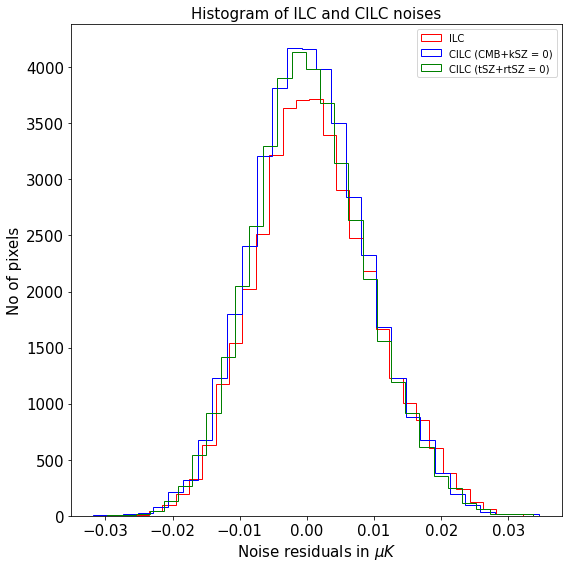

In [357]:
######################## Stacked #########################################

fig = plt.figure(figsize=(8,8))
ax = plt.gca()





plt.hist(ilc_error_noises_stacked_tksz.ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_stacked_tksz_1.ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC (CMB+kSZ = 0)')
plt.hist(cilc_error_noises_stacked_filtered_tksz_2.ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC (tSZ+rtSZ = 0)')

plt.title("Histogram of ILC and CILC noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()


print(np.std(cilc_error_noises_stacked_filtered_tksz_2), np.std(cilc_error_noises_stacked_tksz_1), np.std(ilc_error_noises_stacked_tksz) )


0.00850221551894273 0.008475446909474636 0.008435365949220765


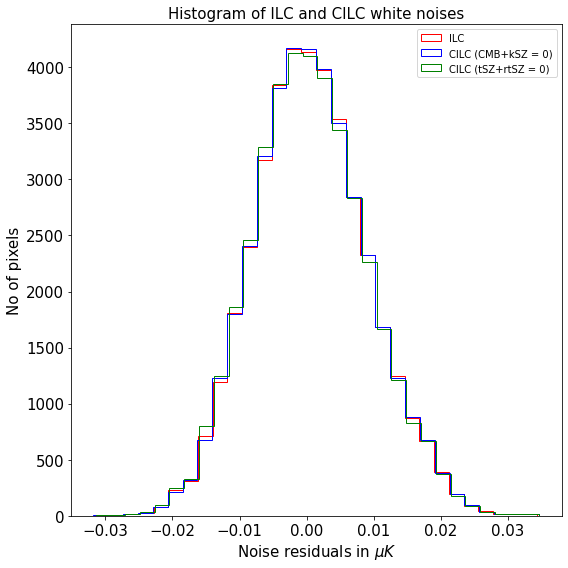

In [182]:

############################ ILC error noises = weight * instrumental ###########################


ilc_error_noises_tksz_instrumental_only =  ilc_error_noises_instrumental_tksz

ilc_error_noises_stacked_tksz_instrumental_only = np.sum(ilc_error_noises_tksz_instrumental_only, axis = 0)/len(red_shifts)


############################ CILC error noises 1 = weights * instrumental noise ###########################


cilc_error_noises_stacked_tksz_1 = np.sum(cilc_error_noises_tksz_1, axis = 0)/len(red_shifts)


########################### CILC error noises 2 = weights * (CMB + instrumental) ####################################

cilc_error_noises_filtered_tksz_instrumental_only_2 = cilc_error_noises_intrumental_filtered_tksz_2 

cilc_error_noises_stacked_filtered_tksz_instrumental_only_2 = np.sum(cilc_error_noises_filtered_tksz_instrumental_only_2, axis = 0)/len(red_shifts)


######################## Stacked #########################################

fig = plt.figure(figsize=(8,8))
ax = plt.gca()





plt.hist(ilc_error_noises_stacked_tksz_instrumental_only.ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_stacked_tksz_1.ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC (CMB+kSZ = 0)')
plt.hist(cilc_error_noises_stacked_filtered_tksz_instrumental_only_2.ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC (tSZ+rtSZ = 0)')

plt.title("Histogram of ILC and CILC white noises", fontsize=15)
plt.xlabel('Noise residuals in $\mu K$', fontsize=15)
plt.ylabel("No of pixels", fontsize=15)
plt.legend()


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/hist_tksz_errors.png", dpi =150)

print(np.std(cilc_error_noises_stacked_filtered_tksz_instrumental_only_2), np.std(cilc_error_noises_stacked_tksz_1), np.std(ilc_error_noises_stacked_tksz_instrumental_only) )



0.19929478722411337 0.19832973262517153 0.19827709840825264


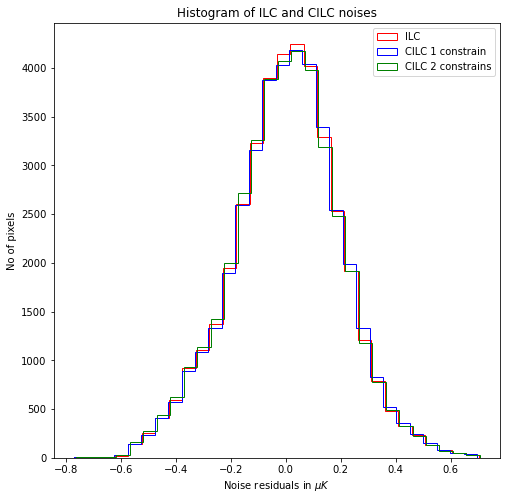

In [168]:
######################## Single cluster #########################################


plt.gcf().set_size_inches(8,8)



plt.hist(ilc_error_noises_tksz[498].ravel(), bins=30,  histtype ='step', color = 'red', label = 'ILC')
plt.hist(cilc_error_noises_tksz_1[498].ravel(), bins=30, histtype ='step', color = 'blue', label = 'CILC 1 constrain')
plt.hist(cilc_error_noises_filtered_tksz_2[498].ravel(), bins=30, histtype ='step', color = 'green', label = 'CILC 2 constrains')

plt.title("Histogram of ILC and CILC noises")
plt.xlabel('Noise residuals in $\mu K$')
plt.ylabel("No of pixels")
plt.legend()

print(np.std(cilc_error_noises_filtered_tksz_2[498]), np.std(cilc_error_noises_tksz_1[498]), np.std(ilc_error_noises_tksz[498]) )


# Defining radial profile function

In [169]:
def dist(image, pix_size):
    
    nx, ny = image.shape[0], image.shape[1]
    center = (nx//2, ny//2)
    YY, XX = np.indices((nx,ny))
    Ra = np.sqrt((XX-center[0])**2 + (YY-center[1])**2) * pix_size

    return(Ra)



def radial_profile(image, n_bins, pix_size):
    
    Ra = dist(image, pix_size)
    profiles = np.zeros((2,n_bins))
    bin_size = np.linspace(0,np.max(Ra),n_bins+1)

    print("bin_size = ",bin_size,'\n')
    
    each_bin_width = bin_size[1:]-bin_size[:-1]
   
   
    print("Each bin width = ", each_bin_width[0], 'arcmins','\n')

    for i in np.arange(n_bins):
        
        indices = (Ra >= bin_size[i]) & (Ra < bin_size[i+1])
        signals = image[indices]
        profiles[0,i] = len(signals)
        profiles[1,i] = np.mean(signals)
        
         
    return np.array(profiles)


def radial_array(n_bins, image, pix_size):
    
    Ra = dist(image, pix_size)
    rad_arr = np.linspace(0,np.max(Ra),n_bins+1) 

    return rad_arr



#print(radial_profile(ilc_extracted_y_tsz, 20, 0.20)[0])

n_cb = radial_profile(y_maps_smoothed_stacked, 20, 0.20)[0][0]


print("Num of pixels in central bin", n_cb)

bin_size =  [ 0.          1.41421356  2.82842712  4.24264069  5.65685425  7.07106781
  8.48528137  9.89949494 11.3137085  12.72792206 14.14213562 15.55634919
 16.97056275 18.38477631 19.79898987 21.21320344 22.627417   24.04163056
 25.45584412 26.87005769 28.28427125] 

Each bin width =  1.4142135623730951 arcmins 

Num of pixels in central bin 149.0


bin_size =  [ 0.          3.53553391  7.07106781 10.60660172 14.14213562 17.67766953
 21.21320344 24.74873734 28.28427125 31.81980515 35.35533906] 

Each bin width =  3.5355339059327378 arcmins 



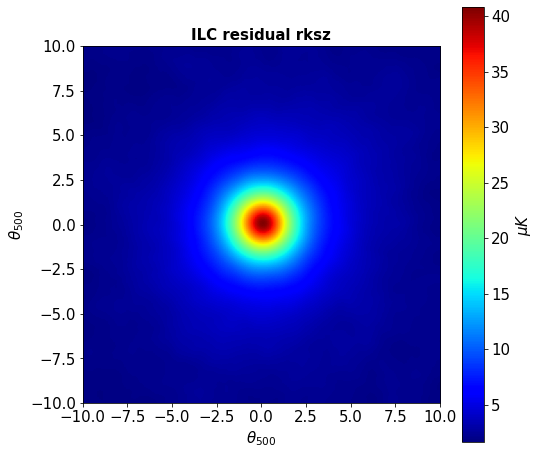

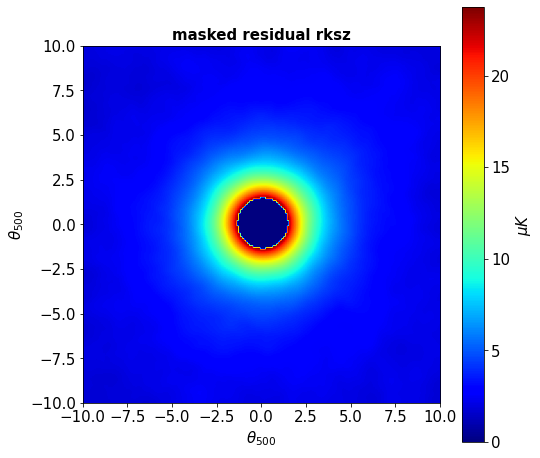

3.1505769373950208 4.586414056924541


In [170]:


def masking(image, n_bins, pix_size):
    
    Ra = dist(image, pix_size)
    
    bin_size = np.linspace(0,np.max(Ra),n_bins+1)

    print("bin_size = ",bin_size,'\n')
    
    each_bin_width = bin_size[1:]-bin_size[:-1]
   
   
    print("Each bin width = ", each_bin_width[0], 'arcmins','\n')

    masked_maps = np.copy(image)
        
    maskd_indices = (Ra >= bin_size[0]) & (Ra < bin_size[1])
    masked_maps[maskd_indices] = 0
        
        
        
         
    return  masked_maps



masked_ilc_rksz =  masking(ilc_residual_rksz*1e6, 10, 0.25)


SZ.plot_map_500(8,8,r"ILC residual rksz",ilc_residual_rksz*1e6,r"$\mu K$", 200,0)
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_res_gilc.png", dpi =150)
plt.show()

SZ.plot_map_500(8,8,r"masked residual rksz",masked_ilc_rksz,r"$\mu K$", 200,0)
#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_res_gilc.png", dpi =150)
plt.show()


print(np.std(masked_ilc_rksz), np.std(ilc_residual_rksz*1e6))


(array([1.8379e+04, 9.6210e+03, 3.9320e+03, 1.9790e+03, 1.2240e+03,
        8.4400e+02, 6.1500e+02, 4.8100e+02, 3.7300e+02, 3.0100e+02,
        2.5100e+02, 2.2000e+02, 1.7700e+02, 1.5500e+02, 1.4300e+02,
        1.2100e+02, 1.1100e+02, 1.0300e+02, 9.1000e+01, 8.3000e+01,
        7.1000e+01, 6.5000e+01, 6.7000e+01, 6.0000e+01, 4.8000e+01,
        5.1000e+01, 5.0000e+01, 3.7000e+01, 5.0000e+01, 2.6000e+01,
        3.3000e+01, 4.4000e+01, 1.7000e+01, 3.6000e+01, 2.9000e+01,
        2.3000e+01, 2.0000e+01, 2.6000e+01, 2.2000e+01, 2.1000e+01]),
 array([ 1.64202063,  2.62178181,  3.601543  ,  4.58130419,  5.56106538,
         6.54082657,  7.52058776,  8.50034895,  9.48011014, 10.45987133,
        11.43963252, 12.41939371, 13.3991549 , 14.37891609, 15.35867728,
        16.33843847, 17.31819966, 18.29796085, 19.27772204, 20.25748323,
        21.23724442, 22.21700561, 23.1967668 , 24.17652799, 25.15628917,
        26.13605036, 27.11581155, 28.09557274, 29.07533393, 30.05509512,
        31.03485

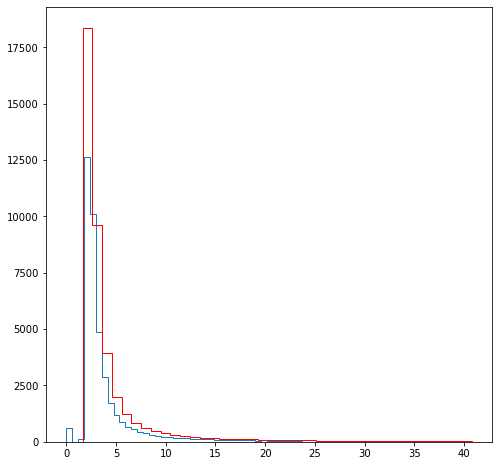

In [171]:
plt.gcf().set_size_inches(8,8)



plt.hist(masked_ilc_rksz.ravel(), bins=40, histtype ='step')
plt.hist((ilc_residual_rksz*1e6).ravel(), bins=40, histtype ='step', color = 'red')


# Noise residual bin to bin covariance function¶

In [172]:

def bin_to_bin_covariance(residual_noise_realisations, no_of_realisations, pix_size, n_bins):
    
    nx, ny = np.array(residual_noise_realisations).shape[1], np.array(residual_noise_realisations).shape[2]
    center = (nx//2, ny//2)
    YY, XX = np.indices((nx,ny))
    R = np.sqrt((XX-center[0])**2 + (YY-center[1])**2) * pix_size

    profiles = np.zeros((n_bins,no_of_realisations))
    bin_width = np.linspace(0,np.max(R),n_bins+1)

    for k in np.arange(no_of_realisations):
        
        each_residual_map = np.copy(residual_noise_realisations[k]) # take each map from the array
       
        for j in range(n_bins):
    
            mask = (R >= bin_width[j]) & (R < bin_width[j+1])
            signals = each_residual_map[mask]
            profiles[j,k] = np.mean(signals)
            

    bin_cov = np.cov(profiles)
    
    return bin_cov

In [259]:
def plot_cov_matrix(x,y,map_title,map_plot,cbar_label, N, pix_size):
    
    plt.gcf().set_size_inches(x,y)

    plt.title(map_title, fontsize=18, fontweight='bold')
    image = plt.imshow(map_plot, cmap = 'jet', origin = 'lower')
    cb = plt.colorbar(image)
    cb.set_label(label = cbar_label, fontsize=18, fontweight='bold')
    cb.ax.tick_params(labelsize=18)
    
    X_width = N * pix_size/60.  # horizontal map width in degrees
    Y_width = N * pix_size/60.  # vertical map width in degrees
    

    #image.set_extent([0,X_width,0,Y_width])
    plt.ylabel('Bins', fontsize=18)
    plt.xlabel('Bins', fontsize=18) 
    ax = plt.gca()


    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

# SNR for the extracted signals 

## tSZ

## From all signals + noise by ILC 
## SNR = $\frac{\text{Central bin of input y map}}{\text{rms of noise map}}$

In [173]:

############### Noises =  instrumental + other signals ###############

ilc_rms_residual_tsz_all_signals = np.sqrt(np.mean((ilc_error_noises_cmb_tsz)**2))/(1e6)            # from muK to unitless 

ilc_rms_residual_tsz_all_signals_CB = ilc_rms_residual_tsz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_y_tsz = y_maps_smoothed[0] # unitless

CB_signal_y_tsz = SZ.radial_profile(signal_y_tsz, 20, 0.25)[0]


################ SNR = Central bin value of the signal/rms noise ################


ilc_snr_tsz_all_signals = CB_signal_y_tsz/ilc_rms_residual_tsz_all_signals

ilc_snr_tsz_all_signals_CB = CB_signal_y_tsz/ilc_rms_residual_tsz_all_signals_CB



print(r"rms residuals = ", ilc_rms_residual_tsz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_tsz_all_signals,'\n')
print("SNR brighest pixels = ",ilc_snr_tsz_all_signals_CB,'\n')


rms residuals =  0.8209050709276897 mu K_CMB

SNR =  31.31454072276303 

SNR brighest pixels =  382.24268291356475 



## rkSZ

## From all signals + noise by ILC 
## SNR = $\frac{\text{Central bin of input $v^2 \tau$ map}}{\text{rms of noise map}}$

In [174]:

############### Noises =  instrumental + other signals ###############

ilc_rms_residual_rksz_all_signals = np.sqrt(np.mean((ilc_error_noises_stacked_rksz)**2))/1e6         # unitless

ilc_rms_residual_rksz_all_signals_CB = ilc_rms_residual_rksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v2_tau_rksz = input_rksz_maps_smoothed_stacked # unitless

CB_signal_v2_tau_rksz = SZ.radial_profile(signal_v2_tau_rksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


ilc_snr_rksz_all_signals = CB_signal_v2_tau_rksz/ilc_rms_residual_rksz_all_signals

ilc_snr_rksz_all_signals_CB = CB_signal_v2_tau_rksz/ilc_rms_residual_rksz_all_signals_CB



print(r"rms residuals = ", ilc_rms_residual_rksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_rksz_all_signals,'\n')
print("SNR brighest pixels = ",ilc_snr_rksz_all_signals_CB,'\n')


rms residuals =  0.6171372858957633 mu K_CMB

SNR =  0.002220448616626922 

SNR brighest pixels =  0.02710402953073549 



## From all signals + noise by cILC

## rksz = 1, kSZ = 0

In [175]:

############### Noises =  instrumental + other signals ###############

cilc_rms_residual_rksz_all_signals = np.sqrt(np.mean((cilc_error_noises_stacked_rksz_1)**2))/1e6         # unitless

cilc_rms_residual_rksz_all_signals_CB = cilc_rms_residual_rksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v2_tau_rksz = input_rksz_maps_smoothed_stacked # unitless

CB_signal_v2_tau_rksz = SZ.radial_profile(signal_v2_tau_rksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


cilc_snr_rksz_all_signals = CB_signal_v2_tau_rksz/cilc_rms_residual_rksz_all_signals

cilc_snr_rksz_all_signals_CB = CB_signal_v2_tau_rksz/cilc_rms_residual_rksz_all_signals_CB



print(r"rms residuals = ", cilc_rms_residual_rksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_rksz_all_signals,'\n')
print("SNR brighest pixels = ",cilc_snr_rksz_all_signals_CB,'\n')


rms residuals =  0.15758846591614983 mu K_CMB

SNR =  0.008695570610258153 

SNR brighest pixels =  0.10614296626465558 



## rksz = 1, tsz = 0, rtsz = 0 

In [176]:




############### Noises =  instrumental + other signals ###############

gilc_rms_residual_rksz_all_signals = np.sqrt(np.mean((cilc_error_noises_stacked_filtered_rksz_2)**2))/1e6         # unitless

gilc_rms_residual_rksz_all_signals_CB = gilc_rms_residual_rksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v2_tau_rksz = input_rksz_maps_smoothed_stacked # unitless

CB_signal_v2_tau_rksz = SZ.radial_profile(signal_v2_tau_rksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


gilc_snr_rksz_all_signals = CB_signal_v2_tau_rksz/gilc_rms_residual_rksz_all_signals

gilc_snr_rksz_all_signals_CB = CB_signal_v2_tau_rksz/gilc_rms_residual_rksz_all_signals_CB



print(r"rms residuals = ", gilc_rms_residual_rksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",gilc_snr_rksz_all_signals,'\n')
print("SNR brighest pixels = ",gilc_snr_rksz_all_signals_CB,'\n')


rms residuals =  0.6723465083821789 mu K_CMB

SNR =  0.002038118166231653 

SNR brighest pixels =  0.024878402747543858 



## tkSZ

## From all signals + noise by ILC 
## SNR = $\frac{\text{Central bin of input $v\theta_e\tau$ map}}{\text{rms of noise map}}$

In [177]:

############### Noises =  instrumental + other signals ###############

ilc_rms_residual_tksz_all_signals = np.sqrt(np.mean((ilc_error_noises_stacked_tksz)**2)) /1e6        # unitless

ilc_rms_residual_tksz_all_signals_CB = ilc_rms_residual_tksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v_tau_theta_e_tksz = input_tksz_maps_smoothed_stacked # unitless

CB_signal_v_tau_theta_e_tksz = SZ.radial_profile(signal_v_tau_theta_e_tksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


ilc_snr_tksz_all_signals = CB_signal_v_tau_theta_e_tksz/ilc_rms_residual_tksz_all_signals

ilc_snr_tksz_all_signals_CB = CB_signal_v_tau_theta_e_tksz/ilc_rms_residual_tksz_all_signals_CB



print(r"rms residuals = ", ilc_rms_residual_tksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",ilc_snr_tksz_all_signals,'\n')
print("SNR brighest pixels = ",ilc_snr_tksz_all_signals_CB,'\n')


rms residuals =  0.008801843491896184 mu K_CMB

SNR =  1.5004331303586302 

SNR brighest pixels =  18.31512045341204 



## From all signals + noise by cILC

## tkSZ = 1, kSZ = 0

In [178]:

############### Noises =  instrumental + CMB  ###############

cilc_rms_residual_tksz_all_signals = np.sqrt(np.mean((cilc_error_noises_stacked_tksz_1)**2)) /1e6        # unitless

cilc_rms_residual_tksz_all_signals_CB = cilc_rms_residual_tksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v_tau_theta_e_tksz = input_tksz_maps_smoothed_stacked # unitless

CB_signal_v_tau_theta_e_tksz = SZ.radial_profile(signal_v_tau_theta_e_tksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


cilc_snr_tksz_all_signals = CB_signal_v_tau_theta_e_tksz/cilc_rms_residual_tksz_all_signals

cilc_snr_tksz_all_signals_CB = CB_signal_v_tau_theta_e_tksz/cilc_rms_residual_tksz_all_signals_CB



print(r"rms residuals = ", cilc_rms_residual_tksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",cilc_snr_tksz_all_signals,'\n')
print("SNR brighest pixels = ",cilc_snr_tksz_all_signals_CB,'\n')


rms residuals =  0.008497862721589386 mu K_CMB

SNR =  1.5541057812007646 

SNR brighest pixels =  18.970278650960406 



## tkSZ = 1, tSZ = 0, rtSZ = 0

In [179]:

############### Noises =  instrumental + CMB ###############

gilc_rms_residual_tksz_all_signals = np.sqrt(np.mean((cilc_error_noises_stacked_filtered_tksz_2)**2)) /1e6        # unitless

gilc_rms_residual_tksz_all_signals_CB = gilc_rms_residual_tksz_all_signals/np.sqrt(n_cb)

############### Signal = Central bin of smoothed rkSZ map ###############

signal_v_tau_theta_e_tksz = input_tksz_maps_smoothed_stacked # unitless

CB_signal_v_tau_theta_e_tksz = SZ.radial_profile(signal_v_tau_theta_e_tksz, 20, 0.20)[0]


################ SNR = Central bin value of the signal/rms noise ################


gilc_snr_tksz_all_signals = CB_signal_v_tau_theta_e_tksz/gilc_rms_residual_tksz_all_signals

gilc_snr_tksz_all_signals_CB = CB_signal_v_tau_theta_e_tksz/gilc_rms_residual_tksz_all_signals_CB



print(r"rms residuals = ", gilc_rms_residual_tksz_all_signals*1e6,"mu K_CMB"'\n')
print("SNR = ",gilc_snr_tksz_all_signals,'\n')
print("SNR brighest pixels = ",gilc_snr_tksz_all_signals_CB,'\n')


rms residuals =  0.00846883564507386 mu K_CMB

SNR =  1.5594325048868451 

SNR brighest pixels =  19.035299599884194 



# Radial profiles of the extracted signals 

In [ ]:
%%time

def ilc_error_realisations_each_rksz(no_of_realisations, ilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps)




        
        signal_noises = ilc_signals_each(z, cmb_ksz_maps_smoothed, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, ilc_weights, nu)
            
        instrumental_noises = ilc_noise_each(z, ilc_weights, noise_maps_smoothed, nu_cmbs4)
            
            
        total_residual_noises = signal_noises + instrumental_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

ilc_error_realn_each_rksz = ilc_error_realisations_each_rksz(no_of_realisations, ilc_weights_each_rksz, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                             tsz_clusters_maps_smoothed, 
                                                             tksz_clusters_maps_smoothed, 
                                                             rtsz_clusters_maps_smoothed)


In [ ]:

sd_ilc_error_realn_each_rksz, ilc_error_covariance_each_rksz = SZ.noise_covariance(ilc_error_realn_each_rksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix rksz ",ilc_error_covariance_each_rksz,"residuals", 200, 1)

plt.show()

cov_ilc_rksz = np.corrcoef(cilc_error_covariance_each_rksz)

SZ.plot_map(8,8," Error correlation matrix rksz ",cov_cilc_rksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# rkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_rksz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_rksz, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_each_rksz = sd_ilc_error_realn_each_rksz/1e6


plt.errorbar(radius_rksz_x_axis, signal_rksz_y_axis_ilc, yerr = ilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def cilc_error_realisations_each_rksz(no_of_realisations, cilc_weights ,pix_size, z, nu, fwhm, noises, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        
        cilc_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, cilc_weights, nu)
        
                
        cilc_noises_stacked = np.sum(cilc_noises, axis = 0)/len(z)
            
       
        error_realisations.append(cilc_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_rksz = cilc_error_realisations_each_rksz(no_of_realisations, cilc_weights_each_rksz_1, pix_size, red_shifts, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, mu, t_cmb, 
                                                               tsz_clusters_maps_smoothed, 
                                                               tksz_clusters_maps_smoothed, 
                                                               rtsz_clusters_maps_smoothed)

In [ ]:

sd_cilc_error_realn_each_rksz, cilc_error_covariance_each_rksz = SZ.noise_covariance(cilc_error_realn_each_rksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix rksz ",cilc_error_covariance_each_rksz,"residuals", 200, 1)

plt.show()

cov_cilc_rksz = np.corrcoef(cilc_error_covariance_each_rksz)

SZ.plot_map(8,8," Error correlation matrix rksz ",cov_cilc_rksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# rkSZ profile from all signals + noise by CILC  ##################
############# rkSZ = 1 , CMB+kSZ = 0 #####################


n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_rksz_y_axis_cilc = SZ.radial_profile(cilc_extracted_each_stacked_rksz_1, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_rksz = sd_cilc_error_realn_each_rksz/1e6


plt.errorbar(radius_rksz_x_axis, signal_rksz_y_axis_ilc, yerr = cilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_profile_cilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def gilc_error_realisations_each_filtered_rksz(no_of_realisations, gilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        cmb_ksz_maps_filtered = cmb_ksz_map_filtered(cmb_ksz_maps, z, 2, N )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_filtered_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps_filtered)

        
        signal_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, gilc_weights, nu)
            
        cmb_noises = cilc_each_cmb(z, gilc_weights, cmb_ksz_maps_filtered_smoothed, nu)
            
            
        total_residual_noises = signal_noises + cmb_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

gilc_error_realn_each_filtered_rksz = gilc_error_realisations_each_filtered_rksz(no_of_realisations, gilc_weights_each_filtered_rksz_1, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                                                 np.zeros((500,4,200,200)), 
                                                                                 tksz_clusters_maps_smoothed, 
                                                                                 np.zeros((500,4,200,200)))




In [ ]:

sd_gilc_error_realn_each_filtered_rksz, gilc_error_covariance_each_rksz = SZ.noise_covariance(gilc_error_realn_each_filtered_rksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix rksz ",gilc_error_covariance_each_rksz,"residuals", 200, 1)

plt.show()

cov_gilc_rksz = np.corrcoef(gilc_error_covariance_each_rksz)

SZ.plot_map(8,8," Error correlation matrix rksz ",cov_gilc_rksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# rkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_filtered_rksz_y_axis_gilc = SZ.radial_profile(gilc_extracted_each_filtered_stacked_rksz_1, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.25)[0:n_bins]


gilc_error_bars_each_filtered_rksz = sd_gilc_error_realn_each_filtered_rksz/1e6


plt.errorbar(radius_rksz_x_axis, signal_filtered_rksz_y_axis_gilc, yerr = gilc_error_bars_each_filtered_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_filtered_profile_gilc.png", dpi =150)
plt.show()

rp_3 = SZ.radial_profile(gilc_extracted_each_filtered_stacked_tksz_1, 20, 0.20) 
rp1 = SZ.radial_profile(input_tksz_maps_smoothed_stacked, 20, 0.20)
plt.plot(radius_rksz_x_axis, rp_3,'-o')
plt.plot(radius_rksz_x_axis, rp1,'-o')
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
%%time

def ilc_error_realisations_each_tksz(no_of_realisations, ilc_weights, tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps)




        
        signal_noises = ilc_signals_each(z, cmb_ksz_maps_smoothed, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, ilc_weights, nu)
            
        instrumental_noises = ilc_noise_each(z, ilc_weights, noise_maps_smoothed, nu_cmbs4)
            
            
        total_residual_noises = signal_noises + instrumental_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

ilc_error_realn_each_tksz = ilc_error_realisations_each_tksz(no_of_realisations, ilc_weights_each_tksz, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                             tsz_clusters_maps_smoothed, 
                                                             rksz_clusters_maps_smoothed, 
                                                             rtsz_clusters_maps_smoothed)


In [ ]:

sd_ilc_error_realn_each_tksz, ilc_error_covariance_each_tksz = SZ.noise_covariance(ilc_error_realn_each_tksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix tksz ",ilc_error_covariance_each_tksz,"residuals", 200, 1)

plt.show()

cov_ilc_tksz = np.corrcoef(ilc_error_covariance_each_tksz)

SZ.plot_map(8,8," Error correlation matrix tksz ",cov_ilc_tksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_tksz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_tksz, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_each_tksz = sd_ilc_error_realn_each_tksz/1e6


plt.errorbar(radius_tksz_x_axis, signal_tksz_y_axis_ilc, yerr = ilc_error_bars_each_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def cilc_error_realisations_each_tksz(no_of_realisations, cilc_weights ,pix_size, z, nu, fwhm, noises, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        
        cilc_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, cilc_weights, nu)
        
                
        cilc_noises_stacked = np.sum(cilc_noises, axis = 0)/len(z)
            
       
        error_realisations.append(cilc_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_tksz = cilc_error_realisations_each_rksz(no_of_realisations, cilc_weights_each_tksz_1, pix_size, red_shifts, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, mu, t_cmb, 
                                                               tsz_clusters_maps_smoothed, 
                                                               rksz_clusters_maps_smoothed, 
                                                               rtsz_clusters_maps_smoothed)


In [ ]:

sd_cilc_error_realn_each_tksz, cilc_error_covariance_each_tksz = SZ.noise_covariance(cilc_error_realn_each_tksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix tksz ",cilc_error_covariance_each_tksz,"residuals", 200, 1)

plt.show()

cov_cilc_tksz = np.corrcoef(cilc_error_covariance_each_tksz)

SZ.plot_map(8,8," Error correlation matrix tksz ",cov_cilc_tksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by CILC  ##################
############# tkSZ = 1 , CMB+kSZ = 0 #####################


n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_tksz_y_axis_cilc = SZ.radial_profile(cilc_extracted_each_stacked_tksz_1, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_tksz = sd_cilc_error_realn_each_tksz/1e6


plt.errorbar(radius_tksz_x_axis, signal_tksz_y_axis_ilc, yerr = cilc_error_bars_each_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_profile_cilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def gilc_error_realisations_each_filtered_tksz(no_of_realisations, gilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        cmb_ksz_maps_filtered = cmb_ksz_map_filtered(cmb_ksz_maps, z, 2, N )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_filtered_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps_filtered)

        
        signal_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, gilc_weights, nu)
            
        cmb_noises = cilc_each_cmb(z, gilc_weights, cmb_ksz_maps_filtered_smoothed, nu)
            
            
        total_residual_noises = signal_noises + cmb_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

gilc_error_realn_each_filtered_tksz = gilc_error_realisations_each_filtered_tksz(no_of_realisations, gilc_weights_each_filtered_tksz_1, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                                                 np.zeros((500,4,200,200)), 
                                                                                 rksz_clusters_maps_smoothed, 
                                                                                 np.zeros((500,4,200,200)))




In [ ]:

sd_gilc_error_realn_each_filtered_tksz, gilc_error_covariance_each_filtered_tksz = SZ.noise_covariance(gilc_error_realn_each_filtered_tksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix tksz ",gilc_error_covariance_each_filtered_tksz,"residuals", 200, 1)

plt.show()

cov_gilc_tksz = np.corrcoef(gilc_error_covariance_each_filtered_tksz)

SZ.plot_map(8,8," Error correlation matrix tksz ",cov_gilc_tksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by gILC  ##################

n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_filtered_tksz_y_axis_gilc = SZ.radial_profile(gilc_extracted_each_filtered_stacked_tksz_1, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


gilc_error_bars_each_filtered_tksz = sd_gilc_error_realn_each_filtered_tksz/(1e6)


plt.errorbar(radius_tksz_x_axis, signal_filtered_tksz_y_axis_gilc, yerr = gilc_error_bars_each_filtered_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_profile_gilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def ilc_error_realisations_each_tsz(no_of_realisations, ilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps)




        
        signal_noises = ilc_signals_each(z, cmb_ksz_maps_smoothed, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, ilc_weights, nu)
            
        instrumental_noises = ilc_noise_each(z, ilc_weights, noise_maps_smoothed, nu_cmbs4)
            
            
        total_residual_noises = signal_noises + instrumental_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

ilc_error_realn_each_tsz = ilc_error_realisations_each_tsz(no_of_realisations, ilc_weights_each_tsz, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                             rksz_clusters_maps_smoothed, 
                                                             tksz_clusters_maps_smoothed, 
                                                             rtsz_clusters_maps_smoothed)


In [ ]:

sd_ilc_error_realn_each_tsz, ilc_error_covariance_each_tsz = SZ.noise_covariance(ilc_error_realn_each_tsz,500, 0.20, 20 )

plot_cov_matrix(8,8," Error covariance matrix tksz ",ilc_error_covariance_each_tsz,"residuals", 200, 1)

plt.show()

In [ ]:
cov_tsz = np.corrcoef(ilc_error_covariance_each_tsz)

plot_cov_matrix(8,8," Error covariance matrix tksz ",cov,"residuals", 200, 1)

plt.show()

In [ ]:
############# tSZ profile from tSZ + all signals ##################

n_bins = 20

binned_input_tsz_maps_smoothed_stacked = SZ.radial_profile(y_maps_smoothed_stacked, n_bins, 0.20)
signal_tsz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_y_tsz, n_bins, 0.20) 
radius_tsz_x_axis = SZ.radial_array(n_bins,y_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_y_tsz = sd_ilc_error_realn_each_tsz/1e6


plt.errorbar(radius_tsz_x_axis, signal_tsz_y_axis_ilc, yerr = ilc_error_bars_y_tsz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output y")
plt.plot(radius_tsz_x_axis, binned_input_tsz_maps_smoothed_stacked, '--', label = 'input y')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"y", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial y profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tsz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
sss

# rkSZ radial profiles 

## ILC 

In [ ]:
%%time

def ilc_error_realisations_each_rksz(no_of_realisations, ilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps)




        
        signal_noises = ilc_signals_each(z, cmb_ksz_maps_smoothed, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, ilc_weights, nu)
            
        instrumental_noises = ilc_noise_each(z, ilc_weights, noise_maps_smoothed, nu)
            
            
        total_residual_noises = signal_noises + instrumental_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

ilc_error_realn_each_rksz = ilc_error_realisations_each_rksz(no_of_realisations, ilc_weights_each_rksz, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                             np.zeros((500,4,200,200)), 
                                                             np.zeros((500,4,200,200)), 
                                                             np.zeros((500,4,200,200)))


In [ ]:

sd_ilc_error_realn_each_rksz, ilc_error_covariance_each_rksz = SZ.noise_covariance(ilc_error_realn_each_rksz,5, 0.20, 20 )

plot_cov_matrix(8,8," Error covariance matrix rksz ",ilc_error_covariance_each_rksz,"residuals", 200, 1)

plt.show()

cov_ilc_rksz = np.corrcoef(ilc_error_covariance_each_rksz)

plot_cov_matrix(8,8," Error correlation matrix rksz ",cov_ilc_rksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# rkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_rksz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_rksz, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_each_rksz = sd_ilc_error_realn_each_rksz/1e6


plt.errorbar(radius_rksz_x_axis, signal_rksz_y_axis_ilc, yerr = ilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:

sd_ilc_error_realn_each_rksz, ilc_error_covariance_each_rksz = SZ.noise_covariance(ilc_error_realn_each_rksz,500, 0.20, 20 )

plot_cov_matrix(8,8," Error covariance matrix rksz ",ilc_error_covariance_each_rksz,"residuals", 200, 1)

plt.show()

cov_ilc_rksz = np.corrcoef(cilc_error_covariance_each_rksz)

plot_cov_matrix(8,8," Error correlation matrix rksz ",cov_cilc_rksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# rkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_rksz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_rksz, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_each_rksz = sd_ilc_error_realn_each_rksz/1e6


plt.errorbar(radius_rksz_x_axis, signal_rksz_y_axis_ilc, yerr = ilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
############# rkSZ profile from all signals + noise by ILC  ##################




ilc_error_bars_each_rksz = sd_ilc_error_realn_each_rksz/1e6


plt.errorbar(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, yerr = ilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "input rkSZ errrors" )
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("ILC errors on rkSZ profile", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_error_profile_ilc.png", dpi =150)
plt.show()


## CILC ------>                                                                       rkSZ = 1, CMB+kSZ = 0 

In [273]:
%%time

def cilc_error_realisations_each_rksz_1(no_of_realisations, cilc_weights ,pix_size, z, nu, fwhm, noises, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        
        cilc_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, cilc_weights, nu)
        
                
        cilc_noises_stacked = np.sum(cilc_noises, axis = 0)/len(z)
            
       
        error_realisations.append(cilc_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_rksz_1 = cilc_error_realisations_each_rksz_1(no_of_realisations, cilc_weights_each_rksz_1, pix_size, red_shifts, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, mu, t_cmb, 
                                                                   np.zeros((500,4,200,200)), 
                                                                   np.zeros((500,4,200,200)), 
                                                                   np.zeros((500,4,200,200)))


CPU times: user 3min 10s, sys: 3.33 s, total: 3min 13s
Wall time: 3min 13s


In [278]:

# sd_cilc_error_realn_each_rksz_1, cilc_error_covariance_each_rksz_1 = SZ.noise_covariance(cilc_error_realn_each_rksz_1,10, 0.20, 20 )

# plot_cov_matrix(8,8," Error covariance matrix rksz ",cilc_error_covariance_each_rksz_1,"residuals", 200, 1)

# plt.show()

# cov_cilc_rksz_1 = np.corrcoef(cilc_error_covariance_each_rksz_1)

# plot_cov_matrix(8,8," Error correlation matrix rksz ",cov_cilc_rksz_1,"residuals", 200, 1)

# plt.show()

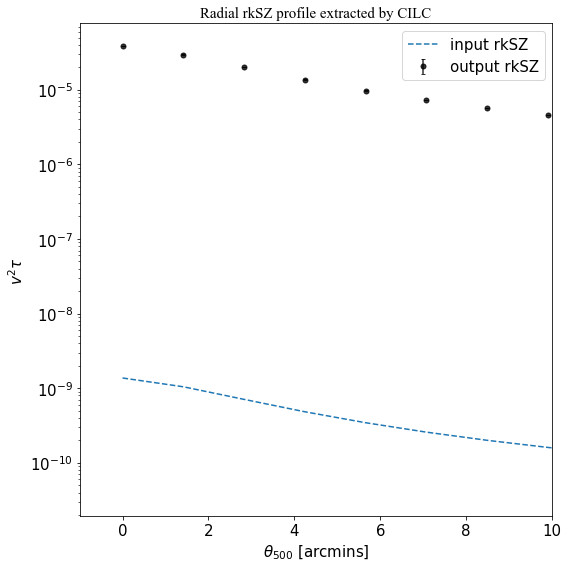

In [276]:
############# rkSZ profile from all signals + noise by CILC  ##################
############# rkSZ = 1 , CMB+kSZ = 0 #####################


n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_rksz_y_axis_cilc = SZ.radial_profile(cilc_extracted_each_stacked_rksz_1, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_rksz = sd_cilc_error_realn_each_rksz_1/1e6


plt.errorbar(radius_rksz_x_axis, signal_rksz_y_axis_cilc, yerr = cilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

#plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_profile_cilc_1.png", dpi =150)
plt.show()


In [277]:

print('input signals = ',binned_input_rksz_maps_smoothed_stacked,'\n' )
print('signals = ',signal_rksz_y_axis_cilc,'\n')
print('errors = ',cilc_error_bars_each_rksz,'\n')


input signals =  [1.37032163e-09 1.04483123e-09 7.08549614e-10 4.83277499e-10
 3.44799804e-10 2.57786977e-10 2.00372306e-10 1.60910656e-10
 1.32599793e-10 1.11572539e-10 9.55473205e-11 8.29074949e-11
 7.28382457e-11 6.50282045e-11 5.89114408e-11 5.27254911e-11
 4.78500318e-11 4.37618066e-11 4.04630945e-11 3.82337782e-11] 

signals =  [3.85915636e-05 2.95136028e-05 2.00640591e-05 1.36598726e-05
 9.73462928e-06 7.29607152e-06 5.69415371e-06 4.58156609e-06
 3.79800597e-06 3.23349172e-06 2.77794860e-06 2.40506031e-06
 2.10223615e-06 1.89739132e-06 1.74726498e-06 1.60300858e-06
 1.48770259e-06 1.40335409e-06 1.30795763e-06 1.24767795e-06] 

errors =  [1.21065969e-07 1.19499569e-07 9.96389712e-08 6.37609541e-08
 4.51870842e-08 4.87863290e-08 5.03284915e-08 5.86046828e-08
 4.77868224e-08 3.71279321e-08 3.23778054e-08 2.71662461e-08
 1.77986554e-08 1.92324678e-08 2.95774662e-08 3.79577216e-08
 5.59739910e-08 5.97284295e-08 5.64181385e-08 6.63458482e-08] 



In [ ]:
############# rkSZ profile from all signals + noise by CILC  ##################




cilc_error_bars_each_rksz = sd_cilc_error_realn_each_rksz_1/1e6


plt.errorbar(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, yerr = cilc_error_bars_each_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "input rkSZ errors")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("CILC errors on rkSZ profile", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_error_profile_cilc.png", dpi =150)
plt.show()


## CILC ------>                                                                       rkSZ = 1, tSZ+rtSZ = 0 

In [240]:
%%time

def cilc_error_realisations_each_filtered_rksz_2(no_of_realisations, gilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        cmb_ksz_maps_filtered = cmb_ksz_map_filtered(cmb_ksz_maps, z, 2, N )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_filtered_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps_filtered)

        
        signal_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, gilc_weights, nu)
            
        cmb_noises = cilc_each_cmb(z, gilc_weights, cmb_ksz_maps_filtered_smoothed, nu)
            
            
        total_residual_noises = signal_noises + cmb_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_filtered_rksz_2 = cilc_error_realisations_each_filtered_rksz_2(no_of_realisations, cilc_weights_each_filtered_rksz_2, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                                                     np.zeros((500,4,200,200)), 
                                                                                     np.zeros((500,4,200,200)), 
                                                                                     np.zeros((500,4,200,200)))


CPU times: user 2d 15h 15min 59s, sys: 2h 42min 36s, total: 2d 17h 58min 35s
Wall time: 8h 7min 4s


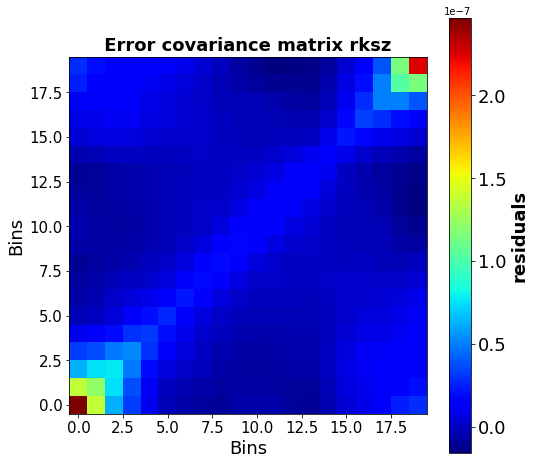

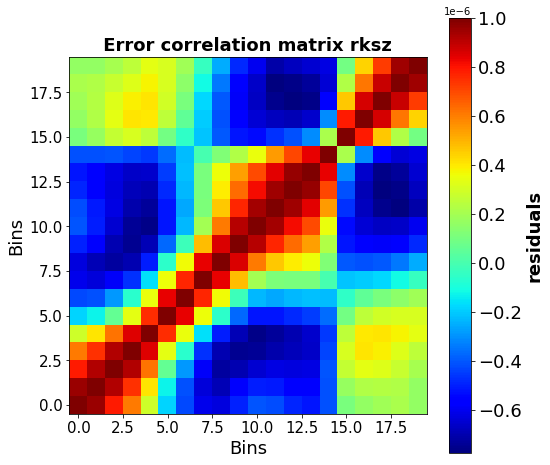

In [261]:

sd_cilc_error_realn_each_filtered_rksz_2, cilc_error_covariance_each_filtered_rksz_2 = SZ.noise_covariance(cilc_error_realn_each_filtered_rksz_2,500, 0.20, 20 )

plot_cov_matrix(8,8," Error covariance matrix rksz ",cilc_error_covariance_each_filtered_rksz_2/1e6,"residuals", 200, 1)

plt.show()

cov_cilc_rksz_2 = np.corrcoef(cilc_error_covariance_each_filtered_rksz_2)

plot_cov_matrix(8,8," Error correlation matrix rksz ",cov_cilc_rksz_2/1e6,"residuals", 200, 1)

plt.show()

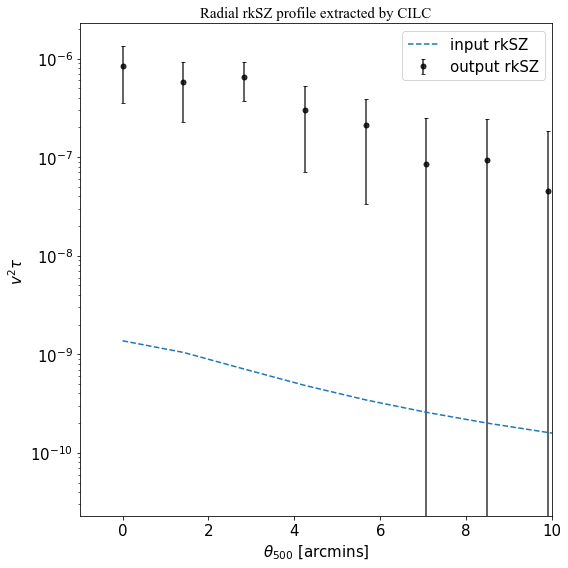

In [293]:
############# rkSZ profile from all signals + noise by CILC  ##################

n_bins = 20

binned_input_rksz_maps_smoothed_stacked = SZ.radial_profile(input_rksz_maps_smoothed_stacked, n_bins, 0.20)
signal_filtered_rksz_y_axis_cilc = SZ.radial_profile(cilc_extracted_each_filtered_stacked_rksz_2, n_bins, 0.20) 
radius_rksz_x_axis = SZ.radial_array(n_bins,input_rksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_filtered_rksz = sd_cilc_error_realn_each_filtered_rksz_2/(1e6)


plt.errorbar(radius_rksz_x_axis, signal_filtered_rksz_y_axis_cilc, yerr = cilc_error_bars_each_filtered_rksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output rkSZ")
plt.plot(radius_rksz_x_axis, binned_input_rksz_maps_smoothed_stacked, '--', label = 'input rkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v^2\tau$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial rkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/rksz_filtered_profile_cilc_2.png", dpi =150)
plt.show()


In [274]:

print('input signals = ',binned_input_rksz_maps_smoothed_stacked,'\n' )
print('signals = ',signal_filtered_rksz_y_axis_cilc,'\n')
print('errors = ',cilc_error_bars_each_filtered_rksz,'\n')


input signals =  [1.37032163e-09 1.04483123e-09 7.08549614e-10 4.83277499e-10
 3.44799804e-10 2.57786977e-10 2.00372306e-10 1.60910656e-10
 1.32599793e-10 1.11572539e-10 9.55473205e-11 8.29074949e-11
 7.28382457e-11 6.50282045e-11 5.89114408e-11 5.27254911e-11
 4.78500318e-11 4.37618066e-11 4.04630945e-11 3.82337782e-11] 

signals =  [ 8.50463877e-07  5.76926874e-07  6.45839435e-07  2.99229000e-07
  2.12108471e-07  8.46479052e-08  9.26178407e-08  4.49949973e-08
  1.62714973e-07  3.42312800e-07  3.33313557e-07  1.95680808e-07
  2.19940140e-08  6.50632826e-08  6.68918106e-08  6.37442120e-08
  1.35624643e-07  1.51138286e-07 -7.79052951e-08 -4.51054615e-08] 

errors =  [4.96798078e-07 3.49592386e-07 2.78339124e-07 2.28341713e-07
 1.78440204e-07 1.64976610e-07 1.50553574e-07 1.40482502e-07
 1.39287836e-07 1.35508268e-07 1.34725823e-07 1.28352495e-07
 1.25270048e-07 1.29862402e-07 1.19569958e-07 1.52107714e-07
 1.83302515e-07 2.24603222e-07 3.20362397e-07 4.74460477e-07] 



# tkSZ radial profiles 

## ILC 

In [ ]:
%%time

def ilc_error_realisations_each_tksz(no_of_realisations, ilc_weights, tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps)




        
        signal_noises = ilc_signals_each(z, cmb_ksz_maps_smoothed, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, ilc_weights, nu)
            
        instrumental_noises = ilc_noise_each(z, ilc_weights, noise_maps_smoothed, nu_cmbs4)
            
            
        total_residual_noises = signal_noises + instrumental_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

ilc_error_realn_each_tksz = ilc_error_realisations_each_tksz(no_of_realisations, ilc_weights_each_tksz, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                             np.zeros((500,4,200,200)), 
                                                             np.zeros((500,4,200,200)), 
                                                             np.zeros((500,4,200,200)))


In [ ]:

sd_ilc_error_realn_each_tksz, ilc_error_covariance_each_tksz = SZ.noise_covariance(ilc_error_realn_each_tksz,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix tksz ",ilc_error_covariance_each_tksz,"residuals", 200, 1)

plt.show()

cov_ilc_tksz = np.corrcoef(ilc_error_covariance_each_tksz)

SZ.plot_map(8,8," Error correlation matrix tksz ",cov_ilc_tksz,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by ILC  ##################

n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_tksz_y_axis_ilc = SZ.radial_profile(ilc_extracted_each_stacked_tksz, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


ilc_error_bars_each_tksz = sd_ilc_error_realn_each_tksz/1e6


plt.errorbar(radius_tksz_x_axis, signal_tksz_y_axis_ilc, yerr = ilc_error_bars_each_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by ILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
############# tkSZ profile from all signals + noise by ILC  ##################


ilc_error_bars_each_tksz = sd_ilc_error_realn_each_tksz/1e6


plt.errorbar(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, yerr = ilc_error_bars_each_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "input tkSZ errors")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("ILC error on tkSZ profile ", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_error_profile_ilc.png", dpi =150)
plt.show()


In [ ]:
%%time

def cilc_error_realisations_each_tksz_1(no_of_realisations, cilc_weights ,pix_size, z, nu, fwhm, noises, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        
        cilc_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, cilc_weights, nu)
        
                
        cilc_noises_stacked = np.sum(cilc_noises, axis = 0)/len(z)
            
       
        error_realisations.append(cilc_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_tksz_1 = cilc_error_realisations_each_tksz_1(no_of_realisations, cilc_weights_each_tksz_1, pix_size, red_shifts, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, mu, t_cmb, 
                                                               np.zeros((500,4,200,200)), 
                                                               np.zeros((500,4,200,200)), 
                                                               np.zeros((500,4,200,200)))


In [ ]:

sd_cilc_error_realn_each_tksz_1, cilc_error_covariance_each_tksz_1 = SZ.noise_covariance(cilc_error_realn_each_tksz_1,500, 0.20, 20 )

SZ.plot_map(8,8," Error covariance matrix tksz ",cilc_error_covariance_each_tksz_1,"residuals", 200, 1)

plt.show()

cov_cilc_tksz_1 = np.corrcoef(cilc_error_covariance_each_tksz_1)

SZ.plot_map(8,8," Error correlation matrix tksz ",cov_cilc_tksz_1,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by CILC  ##################
############# tkSZ = 1 , CMB+kSZ = 0 #####################


n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_tksz_y_axis_cilc_1 = SZ.radial_profile(cilc_extracted_each_stacked_tksz_1, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_tksz_1 = sd_cilc_error_realn_each_tksz_1/1e6


plt.errorbar(radius_tksz_x_axis, signal_tksz_y_axis_cilc_1, yerr = cilc_error_bars_each_tksz_1, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_profile_cilc_1.png", dpi =150)
plt.show()


In [ ]:
############# tkSZ profile from all signals + noise by CILC  ##################
############# tkSZ = 1 , CMB+kSZ = 0 #####################


cilc_error_bars_each_tksz_1 = sd_cilc_error_realn_each_tksz_1/1e6


plt.errorbar(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, yerr = cilc_error_bars_each_tksz_1, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "input tkSZ error")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("CILC errors on tkSZ profile ", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_error_profile_cilc_1.png", dpi =150)
plt.show()


In [ ]:
bb

In [ ]:
%%time

def cilc_error_realisations_each_filtered_tksz_2(no_of_realisations, cilc_weights,tau_map, pix_size, z, v, nu, fwhm, noises, ell, DlTT, mu, t_cmb, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3):
    
    N =  smoothed_signal_1.shape[2]
    
    error_realisations = []
    
    for t in range(no_of_realisations):
        
        
        
        noise_maps = SZ.all_channel_noise_maps(N, z, pix_size, noises)
        
        cmb_ksz_maps = calculate_cmb_ksz_map(tau_map, z, v, 200 , pix_size, ell, DlTT, mu, t_cmb )
        
        cmb_ksz_maps_filtered = cmb_ksz_map_filtered(cmb_ksz_maps, z, 2, N )
        
        
        noise_maps_smoothed = SZ.calculate_smoothed_maps(z, pix_size, fwhm, noise_maps)
        
        cmb_ksz_maps_filtered_smoothed = SZ.calculate_smoothed_maps_freq_independent(z, pix_size, fwhm, cmb_ksz_maps_filtered)

        
        signal_noises = cilc_each_noise(z, smoothed_signal_1, smoothed_signal_2, smoothed_signal_3, noise_maps_smoothed, cilc_weights, nu)
            
        cmb_noises = cilc_each_cmb(z, cilc_weights, cmb_ksz_maps_filtered_smoothed, nu)
            
            
        total_residual_noises = signal_noises + cmb_noises
        
                
        total_residual_noises_stacked = np.sum(total_residual_noises, axis = 0)/len(z)
            
       
        error_realisations.append(total_residual_noises_stacked)
           
    return np.array(error_realisations)


no_of_realisations = 500

cilc_error_realn_each_filtered_tksz_2 = cilc_error_realisations_each_filtered_tksz_2(no_of_realisations, cilc_weights_each_filtered_tksz_2, tau_map, pix_size, red_shifts, v, nu_cmbs4, fwhm_cmbs4, noises_cmbs4, ell, DlTT, mu, t_cmb, 
                                                                                     np.zeros((500,4,200,200)), 
                                                                                     np.zeros((500,4,200,200)), 
                                                                                     np.zeros((500,4,200,200)))


In [ ]:

sd_cilc_error_realn_each_filtered_tksz_2, cilc_error_covariance_each_filtered_tksz_2 = SZ.noise_covariance(cilc_error_realn_each_filtered_tksz_2,500, 0.20, 20 )

plot_cov_matrix(8,8," Error covariance matrix tksz ",cilc_error_covariance_each_filtered_tksz_2,"residuals", 200, 1)

plt.show()

cov_cilc_tksz_2 = np.corrcoef(cilc_error_covariance_each_filtered_tksz_2)

plot_cov_matrix(8,8," Error correlation matrix tksz ",cov_cilc_tksz_2,"residuals", 200, 1)

plt.show()

In [ ]:
############# tkSZ profile from all signals + noise by gILC  ##################

n_bins = 20

binned_input_tksz_maps_smoothed_stacked = SZ.radial_profile(input_tksz_maps_smoothed_stacked, n_bins, 0.20)
signal_filtered_tksz_y_axis_cilc = SZ.radial_profile(cilc_extracted_each_filtered_stacked_tksz_2, n_bins, 0.20) 
radius_tksz_x_axis = SZ.radial_array(n_bins,input_tksz_maps_smoothed_stacked,0.20)[0:n_bins]


cilc_error_bars_each_filtered_tksz = sd_cilc_error_realn_each_filtered_tksz_2/(1e6)


plt.errorbar(radius_tksz_x_axis, signal_filtered_tksz_y_axis_cilc, yerr = cilc_error_bars_each_filtered_tksz, fmt='o', ms=5, color='k', alpha=0.80, capsize = 2, label = "output tkSZ")
plt.plot(radius_tksz_x_axis, binned_input_tksz_maps_smoothed_stacked, '--', label = 'input tkSZ')

plt.gcf().set_size_inches(8,8)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,10)
plt.ylabel(r"$v\tau\theta_e$", fontsize=15)
plt.xlabel(r"$\theta_{500}$ [arcmins]", fontsize=15)
plt.title("Radial tkSZ profile extracted by CILC", fontsize=15, fontname = 'Times New Roman')
plt.legend(fontsize=15)

ax = plt.gca()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_linewidth(0.8)
ax.spines['right'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)
plt.tight_layout()

plt.savefig("/users/kmukherjee/Masters_thesis/Plots_M_z/tksz_filtered_profile_cilc_2.png", dpi =150)
plt.show()


In [ ]:

print('input signals = ',binned_input_tksz_maps_smoothed_stacked,'\n' )
print('signals = ',signal_filtered_tksz_y_axis_cilc,'\n')
print('errors = ',cilc_error_bars_each_filtered_tksz,'\n')
